# **Analyzing Trends in the Music Industry: A Decade of Spotify and Billboard Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re


In [ ]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 6.6 MB/s eta 0:00:00


#Data collecting

## bilboard charts 2014-2023 web scrapping

In [ ]:

# Define the base URL and years to scrape
years = range(2014, 2024)
base_url = 'https://www.billboard.com/charts/year-end/{}/hot-100-songs/'

# Prepare a list to hold all the data
all_songs = []

# Iterate through each year
for year in years:
    url = base_url.format(year)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Adjust the selector based on actual page structure
    containers = soup.find_all('div', class_='o-chart-results-list-row-container')

    rank = 1  # Initialize rank for each song in the top 100 list
    for container in containers:
        song_entries = container.find_all('li', class_='o-chart-results-list__item')
        for entry in song_entries:
            title_tag = entry.find('h3')
            artist_tag = entry.find('span', class_='c-label')

            if title_tag and artist_tag:
                song_title = title_tag.get_text(strip=True)
                artist_name = artist_tag.get_text(strip=True)
                all_songs.append({
                    'Year': year,
                    'Rank': rank,
                    'Song Title': song_title,
                    'Artist': artist_name
                })
                rank += 1
                if rank > 100:
                    break
        if rank > 100:
            break

    # Polite delay between requests to avoid overloading the server
    time.sleep(1)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(all_songs)

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/billboard analysis/raw_data/billboard_top_100_data.txt', index=False)

# Optionally, print or return the DataFrame to check
print(df.head())


   Year  Rank      Song Title                            Artist
0  2014     1           Happy                 Pharrell Williams
1  2014     2      Dark Horse      Katy Perry Featuring Juicy J
2  2014     3       All Of Me                       John Legend
3  2014     4           Fancy  Iggy Azalea Featuring Charli XCX
4  2014     5  Counting Stars                       OneRepublic


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/billboard analysis/raw_data/billboard_top_100_data.txt')

In [ ]:
df.groupby('Year')['Rank'].nunique()


,Rank
Year,
2014,100
2015,100
2016,99
2017,100
2018,100
2019,100
2020,100
2021,100
2022,100


In [ ]:
df[df['Year']==2016]

,Year,Rank,Song Title,Artist
200,2016,1,Love Yourself,Justin Bieber
201,2016,2,Sorry,Justin Bieber
202,2016,3,One Dance,Drake Featuring WizKid & Kyla
203,2016,4,Work,Rihanna Featuring Drake
204,2016,5,Stressed Out,Twenty One Pilots
...,...,...,...,...
294,2016,95,Humble And Kind,Tim McGraw
295,2016,96,Wicked,Future
296,2016,97,Tiimmy Turner,Desiigner
297,2016,98,See You Again,Wiz Khalifa Featuring Charlie Puth


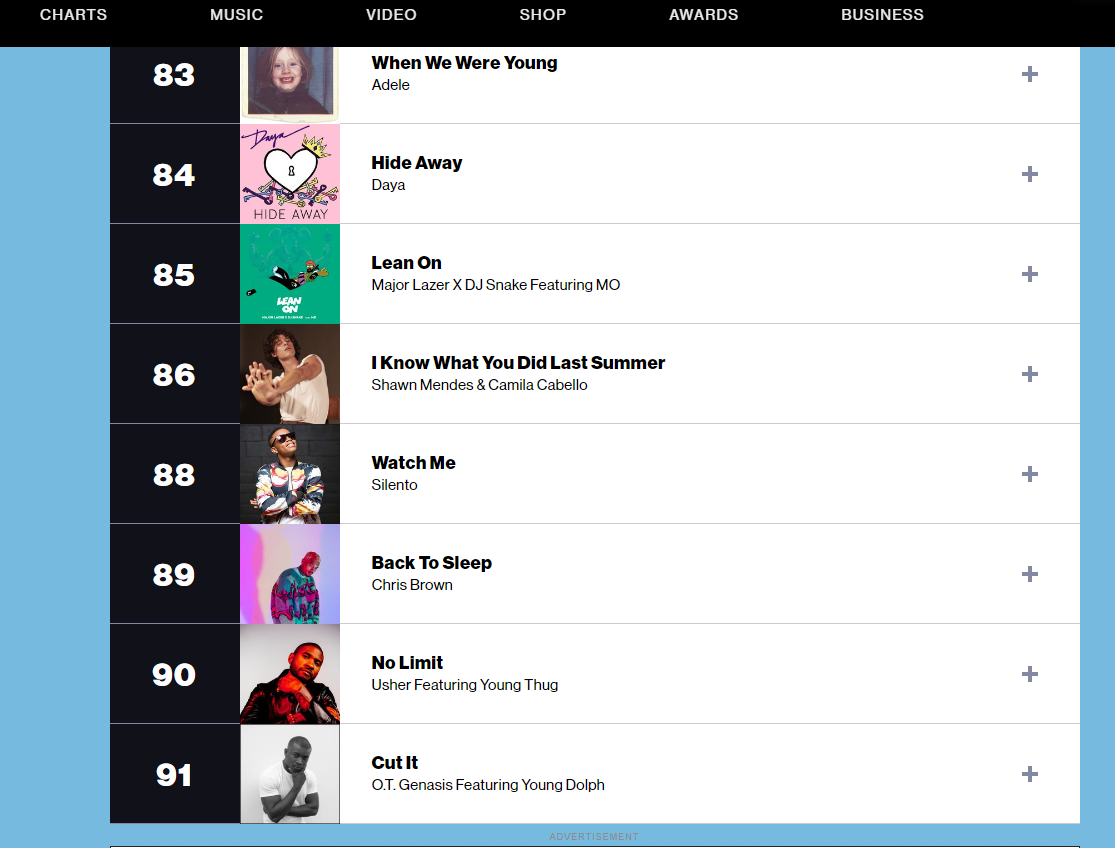

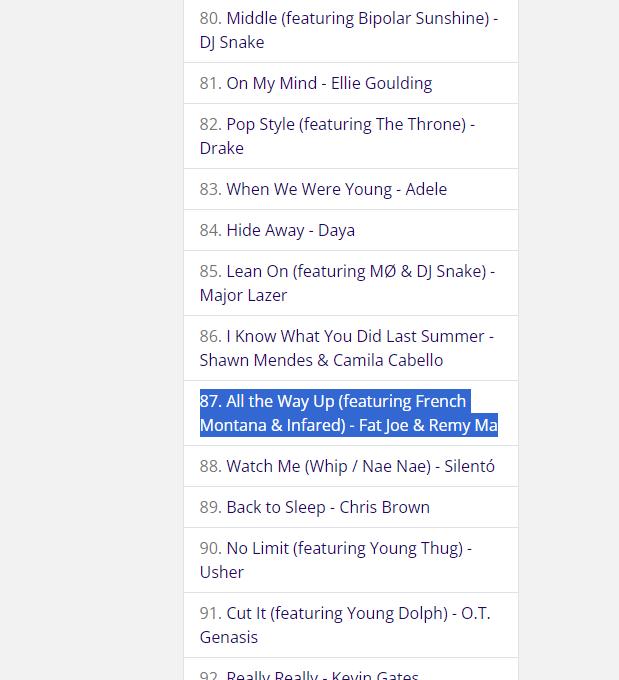

The missing song is rank:87 year: 2016 song_title: 'All the Way Up (featuring French Montana & Infared)

In [ ]:
missing_song_data = {
    'Year': [2016],
    'Rank': [87],
    'Song Title': ['All the Way Up (featuring French Montana & Infared)'],
    'Artist': ['Fat Joe & Remy Ma']
}
missing_song_df = pd.DataFrame(missing_song_data)

# Concatenating the new song DataFrame to the existing DataFrame
df = pd.concat([df, missing_song_df], ignore_index=True)


In [ ]:
df.sort_values(by=['Year','Rank'],inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df

,index,Year,Rank,Song Title,Artist
0,0,2014,1,Happy,Pharrell Williams
1,1,2014,2,Dark Horse,Katy Perry Featuring Juicy J
2,2,2014,3,All Of Me,John Legend
3,3,2014,4,Fancy,Iggy Azalea Featuring Charli XCX
4,4,2014,5,Counting Stars,OneRepublic
...,...,...,...,...,...
995,994,2023,96,"Bzrp Music Sessions, Vol. 53",Bizarrap & Shakira
996,995,2023,97,Meltdown,Travis Scott Featuring Drake
997,996,2023,98,Put It On Da Floor Again,Latto Featuring Cardi B
998,997,2023,99,Bloody Mary,Lady Gaga


In [ ]:
df.drop(columns='index',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        1000 non-null   int64 
 1   Rank        1000 non-null   int64 
 2   Song Title  1000 non-null   object
 3   Artist      1000 non-null   object
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


In [ ]:
df.describe()

,Year,Rank
count,1000.000000,1000.000000
mean,2018.500000,50.487000
std,2.873719,28.861129
min,2014.000000,1.000000
25%,2016.000000,25.750000
50%,2018.500000,50.500000
75%,2021.000000,75.250000
max,2023.000000,100.000000


In [ ]:
df.to_csv('/content/drive/MyDrive/billboard analysis/raw_data/billboard_top_100_dataV2.txt',sep='|',index=False)

## Spotify Api scraping

In [ ]:
!pip install spotipy

In [ ]:
import spotipy
from spotipy import SpotifyClientCredentials

In [ ]:
# Set up Spotify client
client_id = 'x'  # Replace with your Spotify client ID
client_secret = 'x'  # Replace with your Spotify client secret
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
def escape_special_chars(text):
    # Escape special characters like apostrophes
    return text.replace("'", "\\'")

def get_spotify_data(song_title, billboard_artist_name):
    # Escape special characters in song title and artist name
    song_title = escape_special_chars(song_title)
    billboard_artist_name = escape_special_chars(billboard_artist_name)

    # Simplify the artist search by splitting and taking the first part (main artist)
    primary_artist = billboard_artist_name.split(' Featuring')[0].split(' &')[0].split(',')[0]

    # Construct a more specific query using track and simplified artist filters
    query = f'track:"{song_title}" artist:"{primary_artist}"'
    print(f"Query: {query}")  # Debugging output

    while True:
        try:
            result = sp.search(q=query, type='track', limit=50)
            items = result['tracks']['items']
            if items:
                for item in items:
                    spotify_artists = [artist['name'] for artist in item['artists']]
                    if any(primary_artist.lower() in artist.lower() for artist in spotify_artists):
                        track_id = item['id']
                        track_details = sp.track(track_id)
                        audio_features = sp.audio_features(track_id)[0]

                        # Get artist image and genre
                        artist_id = track_details['artists'][0]['id']
                        artist_details = sp.artist(artist_id)
                        artist_image = artist_details['images'][0]['url'] if artist_details['images'] else None
                        artist_genres = ', '.join(artist_details['genres'])

                        return {
                            'Spotify Track ID': track_id,
                            'Spotify_song_name':  track_details['name'],
                            'Spotify URL': track_details['external_urls']['spotify'],
                            'Artist Name': spotify_artists[0],
                            'Artist Image': artist_image,
                            'Artist Genres': artist_genres,
                            'Release Date': track_details['album']['release_date'],
                            'Popularity': track_details['popularity'],
                            'Duration (ms)': track_details['duration_ms'],
                            'Explicit': track_details['explicit'],
                            'Danceability': audio_features['danceability'],
                            'Energy': audio_features['energy'],
                            'Key': audio_features['key'],
                            'Loudness': audio_features['loudness'],
                            'Mode': audio_features['mode'],
                            'Speechiness': audio_features['speechiness'],
                            'Acousticness': audio_features['acousticness'],
                            'Instrumentalness': audio_features['instrumentalness'],
                            'Liveness': audio_features['liveness'],
                            'Valence': audio_features['valence'],
                            'Tempo': audio_features['tempo'],
                        }
                print(f"No matching artist found for: {billboard_artist_name} in Spotify results")
                return {}
            else:
                print(f"No results found for: {query}")  # Debugging output
                return {}
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', 1))
                print(f"Rate limit hit. Retrying after {retry_after + 1} seconds...")
                time.sleep(retry_after + 1)
            else:
                print(f"Spotify API error: {str(e)}")
                return {}



In [ ]:
spotify_columns = [ 'Spotify Track ID',
                            'Spotify_song_name',
                            'Spotify URL',
                            'Artist Name',
                            'Artist Image',
                            'Artist Genres',
                            'Release Date',
                            'Popularity',
                            'Duration (ms)',
                            'Explicit',
                            'Danceability',
                            'Energy',
                            'Key',
                            'Loudness',
                            'Mode',
                            'Speechiness',
                            'Acousticness',
                            'Instrumentalness',
                            'Liveness',
                            'Valence',
                            'Tempo',]

In [ ]:
df

,Year,Rank,Song Title,Artist
0,2014,1,Happy,Pharrell Williams
1,2014,2,Dark Horse,Katy Perry Featuring Juicy J
2,2014,3,All Of Me,John Legend
3,2014,4,Fancy,Iggy Azalea Featuring Charli XCX
4,2014,5,Counting Stars,OneRepublic
...,...,...,...,...
995,2023,96,"Bzrp Music Sessions, Vol. 53",Bizarrap & Shakira
996,2023,97,Meltdown,Travis Scott Featuring Drake
997,2023,98,Put It On Da Floor Again,Latto Featuring Cardi B
998,2023,99,Bloody Mary,Lady Gaga


In [ ]:
new_data = []
for index, row in df.iterrows():
    spotify_data = get_spotify_data(row[2], row[3])
    new_data.append(spotify_data)

    # Sleep for a bit between requests to avoid rate limits
    time.sleep(1.5)  # Adjust this as needed based on your rate limit

# Convert the list of dictionaries to a DataFrame
spotify_df = pd.DataFrame(new_data, columns=spotify_columns)

# Combine the new data with the original DataFrame
df = pd.concat([df, spotify_df], axis=1)

# Save the enriched DataFrame to a new CSV
df.to_csv('/content/drive/MyDrive/billboard analysis/raw_data/billboard_top_100_with_spotify_01.txt', sep='|', index=False)

<ipython-input-140-281f54813792>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spotify_data = get_spotify_data(row[2], row[3])


Query: track:"Happy" artist:"Pharrell Williams"
Query: track:"Dark Horse" artist:"Katy Perry"
Query: track:"All Of Me" artist:"John Legend"
Query: track:"Fancy" artist:"Iggy Azalea"
Query: track:"Counting Stars" artist:"OneRepublic"
Query: track:"Talk Dirty" artist:"Jason Derulo"
Query: track:"Rude" artist:"MAGIC!"
Query: track:"All About That Bass" artist:"Meghan Trainor"
Query: track:"Problem" artist:"Ariana Grande"
Query: track:"Stay With Me" artist:"Sam Smith"
Query: track:"Timber" artist:"Pitbull"
Query: track:"Pompeii" artist:"Bastille"
Query: track:"Shake It Off" artist:"Taylor Swift"
Query: track:"Am I Wrong" artist:"Nico"
Query: track:"Turn Down For What" artist:"DJ Snake"
Query: track:"The Monster" artist:"Eminem"
Query: track:"Say Something" artist:"A Great Big World"
Query: track:"Team" artist:"Lorde"
Query: track:"Let Her Go" artist:"Passenger"
Query: track:"Royals" artist:"Lorde"
Query: track:"Let It Go" artist:"Idina Menzel"
Query: track:"Wake Me Up!" artist:"Avicii"
Que

#data cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1000 non-null   int64  
 1   Rank               1000 non-null   int64  
 2   Song Title         1000 non-null   object 
 3   Artist             1000 non-null   object 
 4   Spotify Track ID   942 non-null    object 
 5   Spotify_song_name  942 non-null    object 
 6   Spotify URL        942 non-null    object 
 7   Artist Name        942 non-null    object 
 8   Artist Image       941 non-null    object 
 9   Artist Genres      942 non-null    object 
 10  Release Date       942 non-null    object 
 11  Popularity         942 non-null    float64
 12  Duration (ms)      942 non-null    float64
 13  Explicit           942 non-null    object 
 14  Danceability       942 non-null    float64
 15  Energy             942 non-null    float64
 16  Key                942 no

## dealing with spotify missing value

In [ ]:
df[df['Spotify Track ID'].isna()].iloc[::,0:4]

,Year,Rank,Song Title,Artist
80,2014,81,Bartender,Lady Antebellum
94,2014,95,Partition,Beyonce
98,2014,99,Somethin' Bad,Miranda Lambert Duet With Carrie Underwood
107,2015,8,Watch Me,Silento
115,2015,16,Lean On,Major Lazer X DJ Snake Featuring MO
160,2015,61,7/11,Beyonce
181,2015,82,Tuesday,I LOVE MAKONNEN Featuring Drake
218,2016,19,"Me, Myself & I",G-Eazy x Bebe Rexha
233,2016,34,Broccoli,D.R.A.M. Featuring Lil Yachty
284,2016,85,Lean On,Major Lazer X DJ Snake Featuring MO


In [ ]:
def get_spotify_data_wide_search(song_title, billboard_artist_name):
    # Escape special characters in song title and artist name
    song_title = escape_special_chars(song_title)
    billboard_artist_name = escape_special_chars(billboard_artist_name)



    # Construct a more specific query using track and simplified artist filters
    query = f'track:"{song_title}'
    print(f"Query: {query}")  # Debugging output

    while True:

        result = sp.search(q=query, type='track', limit=50)
        items = result['tracks']['items']
        if items:
            for item in items:
                spotify_artists = [artist['name'] for artist in item['artists']]

                track_id = item['id']
                track_details = sp.track(track_id)
                audio_features = sp.audio_features(track_id)[0]

                # Get artist image and genre
                artist_id = track_details['artists'][0]['id']
                artist_details = sp.artist(artist_id)
                artist_image = artist_details['images'][0]['url'] if artist_details['images'] else None
                artist_genres = ', '.join(artist_details['genres'])

                return {
                    'Spotify Track ID': track_id,
                    'Spotify_song_name':  track_details['name'],
                    'Spotify URL': track_details['external_urls']['spotify'],
                    'Artist Name': spotify_artists[0],
                    'Artist Image': artist_image,
                    'Artist Genres': artist_genres,
                    'Release Date': track_details['album']['release_date'],
                    'Popularity': track_details['popularity'],
                    'Duration (ms)': track_details['duration_ms'],
                    'Explicit': track_details['explicit'],
                    'Danceability': audio_features['danceability'],
                    'Energy': audio_features['energy'],
                    'Key': audio_features['key'],
                    'Loudness': audio_features['loudness'],
                    'Mode': audio_features['mode'],
                    'Speechiness': audio_features['speechiness'],
                    'Acousticness': audio_features['acousticness'],
                    'Instrumentalness': audio_features['instrumentalness'],
                    'Liveness': audio_features['liveness'],
                    'Valence': audio_features['valence'],
                    'Tempo': audio_features['tempo'],
                }
        print(f"No matching artist found for: {billboard_artist_name} in Spotify results")
        return {}
    else:
        print(f"No results found for: {query}")  # Debugging output
        return {}


In [ ]:
df_missing_rows = df[df['Spotify Track ID'].isna()]

In [ ]:
fill_data = []

In [ ]:
for index, row in df_missing_rows.iterrows():

    spotify_data = get_spotify_data_wide_search(row['Song Title'], row['Artist'])
    fill_data.append(spotify_data)

    # Sleep to respect rate limits
    time.sleep(1)  # Adjust as needed


fill_df = pd.DataFrame(fill_data, index=df_missing_rows.index)

df.update(fill_df)


Query: track:"Bartender
Query: track:"Partition
Query: track:"Somethin\' Bad
Query: track:"Watch Me
Query: track:"Lean On
Query: track:"7/11
Query: track:"Tuesday
Query: track:"Me, Myself & I
Query: track:"Broccoli
Query: track:"Lean On
Query: track:"Watch Me
Query: track:"All the Way Up (featuring French Montana & Infared)
No matching artist found for: Fat Joe & Remy Ma in Spotify results
Query: track:"Bodak Yellow (Money Moves)
Query: track:"I Don\'t Wanna Live Forever (Fifty Shades Darker)
Query: track:"It Ain\'t Me
Query: track:"Bad Things
Query: track:"Caroline
Query: track:"Broccoli
Query: track:"Bodak Yellow (Money Moves)
Query: track:"Wolves
Query: track:"Lemon
Query: track:"X
Query: track:"Ran$om
Query: track:"Wake Up In The Sky
Query: track:"Close To Me
Query: track:"Savage Love (Laxed - Siren Beat)
Query: track:"RITMO (Bad Boys For Life)
Query: track:"Nobody But You
Query: track:"Come & Go
Query: track:"Be Like That
Query: track:"P*$$y Fairy (OTW)
Query: track:"Leave The Doo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1000 non-null   int64  
 1   Rank               1000 non-null   int64  
 2   Song Title         1000 non-null   object 
 3   Artist             1000 non-null   object 
 4   Spotify Track ID   999 non-null    object 
 5   Spotify_song_name  999 non-null    object 
 6   Spotify URL        999 non-null    object 
 7   Artist Name        999 non-null    object 
 8   Artist Image       996 non-null    object 
 9   Artist Genres      999 non-null    object 
 10  Release Date       999 non-null    object 
 11  Popularity         999 non-null    float64
 12  Duration (ms)      999 non-null    float64
 13  Explicit           999 non-null    object 
 14  Danceability       999 non-null    float64
 15  Energy             999 non-null    float64
 16  Key                999 no

In [ ]:
#still 1 song missing

In [ ]:
df[df['Spotify Track ID'].isna()]

,Year,Rank,Song Title,Artist,Spotify Track ID,Spotify_song_name,Spotify URL,Artist Name,Artist Image,Artist Genres,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
287,2016,87,All the Way Up (featuring French Montana & Inf...,Fat Joe & Remy Ma,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def extract_track_id(spotify_url):
    """
    Extracts the track ID from a Spotify URL.
    """
    # Guard clause for a potentially malformed URL
    if "spotify.com" not in spotify_url:
        return None
    try:
        return spotify_url.split("/")[-1].split("?")[0]
    except IndexError:
        return None

def get_track_details_from_url(spotify_url):
    """
    Retrieves track details from a Spotify URL.
    """
    track_id = extract_track_id(spotify_url)
    if not track_id:
        return "Invalid URL or track ID not found."

    try:
        track_details = sp.track(track_id)
        audio_features = sp.audio_features(track_id)[0]

        # Handling missing data
        if not track_details or not audio_features:
            return "Track details or audio features not found."

        artist_id = track_details['artists'][0]['id']
        artist_details = sp.artist(artist_id)

        artist_image = artist_details['images'][0]['url'] if artist_details['images'] else None
        artist_genres = ', '.join(artist_details['genres']) if artist_details['genres'] else "No genres listed"

        # Retrieve artist names safely
        spotify_artists = [artist['name'] for artist in track_details['artists']]

        return {
            'Spotify Track ID': track_id,
            'Spotify_song_name': track_details['name'],
            'Spotify URL': spotify_url,
            'Artist Name': spotify_artists[0] if spotify_artists else "No artist info",
            'Artist Image': artist_image,
            'Artist Genres': artist_genres,
            'Release Date': track_details['album']['release_date'],
            'Popularity': track_details['popularity'],
            'Duration (ms)': track_details['duration_ms'],
            'Explicit': track_details['explicit'],
            'Danceability': audio_features['danceability'],
            'Energy': audio_features['energy'],
            'Key': audio_features['key'],
            'Loudness': audio_features['loudness'],
            'Mode': audio_features['mode'],
            'Speechiness': audio_features['speechiness'],
            'Acousticness': audio_features['acousticness'],
            'Instrumentalness': audio_features['instrumentalness'],
            'Liveness': audio_features['liveness'],
            'Valence': audio_features['valence'],
            'Tempo': audio_features['tempo'],
        }
    except spotipy.exceptions.SpotifyException as e:
        return f"Spotify API error: {str(e)}"


In [ ]:
df_missing2= df[df['Spotify Track ID'].isna()].copy()

In [ ]:
df_missing2['Spotify URL'] = ['https://open.spotify.com/track/61QSuw5VlC0LTS8WMO356g?si=1e098ff0429e45d4'] #manual fiill

In [ ]:
manual_data = []

for index, row in df_missing2.iterrows():
    spotify_data = get_track_details_from_url(row['Spotify URL'])
    manual_data.append(spotify_data)

# Convert manual data to a DataFrame with the same index as the problematic rows
manual_df = pd.DataFrame(manual_data, index=df_missing2.index)

# Update the original DataFrame with the manually filled data
df.update(manual_df)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1000 non-null   int64  
 1   Rank               1000 non-null   int64  
 2   Song Title         1000 non-null   object 
 3   Artist             1000 non-null   object 
 4   Spotify Track ID   1000 non-null   object 
 5   Spotify_song_name  1000 non-null   object 
 6   Spotify URL        1000 non-null   object 
 7   Artist Name        1000 non-null   object 
 8   Artist Image       997 non-null    object 
 9   Artist Genres      1000 non-null   object 
 10  Release Date       1000 non-null   object 
 11  Popularity         1000 non-null   float64
 12  Duration (ms)      1000 non-null   float64
 13  Explicit           1000 non-null   object 
 14  Danceability       1000 non-null   float64
 15  Energy             1000 non-null   float64
 16  Key                1000 n

In [ ]:
df.to_csv('/content/drive/MyDrive/billboard analysis/clean_data/clean_01.txt',sep='|',index=False)

##correct the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/billboard analysis/clean_data/clean_01.txt',sep='|')

In [ ]:
df_filtered = df[df.apply(lambda x: x['Song Title'].lower().strip() not in x['Spotify_song_name'].lower().strip(), axis=1)]
df_filtered[['Song Title','Spotify_song_name']]

,Song Title,Spotify_song_name
21,Wake Me Up!,Wake Me Up
100,Uptown Funk!,Uptown Funk (feat. Bruno Mars)
107,Watch Me,watch
118,Where Are U Now,Where Are Ü Now (with Justin Bieber)
124,"Honey, I'm Good.","Honey, I'm Good"
131,G.D.F.R.,Club Can't Handle Me (feat. David Guetta) - Si...
147,B**** Better Have My Money,Bitch Better Have My Money
148,Flex (Ooh Ooh Ooh),"Flex (Ooh, Ooh, Ooh)"
195,El Perdon (Forgiveness),El Perdón - Forgiveness
237,I Hate U I Love U,"i hate u, i love u (feat. olivia o'brien)"


In [ ]:
#131
df_unmatch = df.iloc[131:132,::].copy()

In [ ]:
df_unmatch

,Year,Rank,Song Title,Artist,Spotify Track ID,Spotify_song_name,Spotify URL,Artist Name,Artist Image,Artist Genres,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
131,2015,32,G.D.F.R.,Flo Rida Featuring Sage The Gemini & Lookas,0AjTlkLRzTLP3SWftMzj3F,Club Can't Handle Me (feat. David Guetta) - Si...,https://open.spotify.com/track/0AjTlkLRzTLP3SW...,Flo Rida,https://i.scdn.co/image/ab6761610000e5eb655ca8...,"dance pop, miami hip hop, pop, pop rap",...,0.75,0.0,-5.542,1.0,0.0615,0.00268,0.0307,0.0876,0.595,127.958


In [ ]:
df_unmatch['Spotify URL'] = ['https://open.spotify.com/track/26rdOwwjC2UnweK3xeS58u?si=0f793fad49c04cc6']

In [ ]:
manual_data = []

for index, row in df_unmatch.iterrows():
    spotify_data = get_track_details_from_url(row['Spotify URL'])
    manual_data.append(spotify_data)

# Convert manual data to a DataFrame with the same index as the problematic rows
manual_df = pd.DataFrame(manual_data, index=df_unmatch.index)

# Update the original DataFrame with the manually filled data
df.update(manual_df)

In [ ]:
df.iloc[131]

,131
Year,2015
Rank,32
Song Title,G.D.F.R.
Artist,Flo Rida Featuring Sage The Gemini & Lookas
Spotify Track ID,26rdOwwjC2UnweK3xeS58u
Spotify_song_name,GDFR (feat. Sage the Gemini & Lookas)
Spotify URL,https://open.spotify.com/track/26rdOwwjC2UnweK...
Artist Name,Flo Rida
Artist Image,https://i.scdn.co/image/ab6761610000e5eb655ca8...
Artist Genres,"dance pop, miami hip hop, pop, pop rap"


In [ ]:
df_filtered = df[df.apply(lambda x: x['Artist Name'] not in x['Artist'], axis=1)]
df_filtered[['Artist Name','Artist','Song Title','Spotify_song_name']]

,Artist Name,Artist,Song Title,Spotify_song_name
34,Beyonce Gisselle Knowles,Beyonce Featuring Jay Z,Drunk In Love,Drunk In Love
80,T-Pain,Lady Antebellum,Bartender,Bartender (feat. Akon)
85,5 Seconds of Summer,5 Seconds Of Summer,Amnesia,Amnesia
92,5 Seconds of Summer,5 Seconds Of Summer,She Looks So Perfect,She Looks So Perfect
94,Beyoncé,Beyonce,Partition,Partition
107,Billie Eilish,Silento,Watch Me,watch
118,Jack Ü,Skrillex & Diplo With Justin Bieber,Where Are U Now,Where Are Ü Now (with Justin Bieber)
154,USHER,Usher Featuring Juicy J,I Don't Mind,I Don't Mind (feat. Juicy J)
160,Beyoncé,Beyonce,7/11,7/11
181,Lynyrd Skynyrd,I LOVE MAKONNEN Featuring Drake,Tuesday,Tuesday's Gone


In [ ]:
unmatch_indices = [34, 80, 107, 181, 270, 286,323, 453, 459, 482, 489, 527, 557, 651, 787, 856, 872, 891]
df_unmatch2 = df.loc[unmatch_indices]
df_unmatch2

,Year,Rank,Song Title,Artist,Spotify Track ID,Spotify_song_name,Spotify URL,Artist Name,Artist Image,Artist Genres,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
34,2014,35,Drunk In Love,Beyonce Featuring Jay Z,0oBshCSDR9wRyLBH2klM93,Drunk In Love,https://open.spotify.com/track/0oBshCSDR9wRyLB...,Beyonce Gisselle Knowles,NaN,NaN,...,0.229,9.0,-10.083,1.0,0.0453,0.92000,0.648000,0.1420,0.508,87.749
80,2014,81,Bartender,Lady Antebellum,1RGIjMFMgJxkZHMDXVYzOJ,Bartender (feat. Akon),https://open.spotify.com/track/1RGIjMFMgJxkZHM...,T-Pain,https://i.scdn.co/image/ab6761610000e5eb10b37a...,"dance pop, gangster rap, hip hop, pop rap, r&b...",...,0.391,8.0,-8.504,1.0,0.0628,0.05640,0.000000,0.2240,0.436,104.961
107,2015,8,Watch Me,Silento,7eB1V5LvAdxCc7brfGhRRo,watch,https://open.spotify.com/track/7eB1V5LvAdxCc7b...,Billie Eilish,https://i.scdn.co/image/ab6761610000e5eb4a21b4...,"art pop, pop",...,0.599,0.0,-8.985,1.0,0.2250,0.33300,0.001980,0.1030,0.350,165.212
181,2015,82,Tuesday,I LOVE MAKONNEN Featuring Drake,64sn7wgJfeQKY3Jisnl59w,Tuesday's Gone,https://open.spotify.com/track/64sn7wgJfeQKY3J...,Lynyrd Skynyrd,https://i.scdn.co/image/ab6761610000e5eb451eb0...,"album rock, classic rock, hard rock, rock, sou...",...,0.615,9.0,-8.636,1.0,0.0295,0.07780,0.000006,0.0602,0.410,145.593
270,2016,71,Sorry,Beyonce,4k8Kq3yLE7I7umYfN08YCU,Sorry,https://open.spotify.com/track/4k8Kq3yLE7I7umY...,Ava Ayanna,https://i.scdn.co/image/ab67616d0000b2731a2a71...,NaN,...,0.110,11.0,-17.493,0.0,0.0482,0.94200,0.001060,0.1000,0.169,129.935
286,2016,87,Watch Me,Silento,7eB1V5LvAdxCc7brfGhRRo,watch,https://open.spotify.com/track/7eB1V5LvAdxCc7b...,Billie Eilish,https://i.scdn.co/image/ab6761610000e5eb4a21b4...,"art pop, pop",...,0.599,0.0,-8.985,1.0,0.2250,0.33300,0.001980,0.1030,0.350,165.212
323,2017,24,Bodak Yellow (Money Moves),Cardi B,4vULYQPAhL2maOdy9LXWZM,Bodak Yellow - Money Moves Remix,https://open.spotify.com/track/4vULYQPAhL2maOd...,DJ Mich,NaN,NaN,...,0.903,9.0,-2.741,1.0,0.0675,0.00864,0.002420,0.0760,0.779,126.027
453,2018,54,Bodak Yellow (Money Moves),Cardi B,4vULYQPAhL2maOdy9LXWZM,Bodak Yellow - Money Moves Remix,https://open.spotify.com/track/4vULYQPAhL2maOd...,DJ Mich,NaN,NaN,...,0.903,9.0,-2.741,1.0,0.0675,0.00864,0.002420,0.0760,0.779,126.027
459,2018,60,Wolves,Selena Gomez X Marshmello,7yyRhjoCsdt5dDpFz2CImD,Wolves Cry,https://open.spotify.com/track/7yyRhjoCsdt5dDp...,Bryan Martin,https://i.scdn.co/image/ab6761610000e5ebe6776b...,modern country pop,...,0.742,6.0,-5.723,1.0,0.0425,0.06250,0.000008,0.0970,0.518,76.969
482,2018,83,Lemon,N*E*R*D & Rihanna,1p0rEzrK7YtdRZVtiyV7RN,Lemonade (feat. NAV),https://open.spotify.com/track/1p0rEzrK7YtdRZV...,Internet Money,https://i.scdn.co/image/ab6761610000e5eb30cc15...,"pop rap, trap",...,0.658,1.0,-6.142,0.0,0.0790,0.25000,0.000000,0.1110,0.462,140.042


In [ ]:
new_url = ['https://open.spotify.com/track/6jG2YzhxptolDzLHTGLt7S?si=bd2bdcca157e4e02','https://open.spotify.com/track/1qFQKFt9fp1LU9QsvFbyPS?si=7c62079c8cd84e7e','https://open.spotify.com/track/5RIVoVdkDLEygELLCniZFr?si=2d40fcc5dacf4637','https://open.spotify.com/track/35rSpXB5bk9ega9jsjcRts?si=20c6fd9751694fb9','https://open.spotify.com/track/0lnIJmgcUpEpe4AZACjayW?si=0212f7652f864a4c','https://open.spotify.com/track/5RIVoVdkDLEygELLCniZFr?si=a8dff261ff554f69','https://open.spotify.com/track/6KBYefIoo7KydImq1uUQlL?si=f2156b4ac0564010','https://open.spotify.com/track/6KBYefIoo7KydImq1uUQlL?si=0e3e130a899745b5','https://open.spotify.com/track/0tBbt8CrmxbjRP0pueQkyU?si=af89b8be45124bcd','https://open.spotify.com/track/4PpuH4mxL0rD35mOWaLoKS?si=cc2a6f6c724b4b37','https://open.spotify.com/track/5YUyW9opqNsMSEzzecZih1?si=a6acf5cdefdb4cc5','https://open.spotify.com/track/1lOe9qE0vR9zwWQAOk6CoO?si=9962f27a8fd04f3a','https://open.spotify.com/track/2GjMaJ7DacMIkgoe8oMXGg?si=174d6419dd0946dc','https://open.spotify.com/track/5M8goiFYynmNxhueYW6grR?si=84f4ec8c3e0a40a7','https://open.spotify.com/track/4h5OVQQbeqw3lNaFIbmlzG?si=cd31d73642094ea0','https://open.spotify.com/track/3ncmoWTwJgx63LwMTyBCXf?si=1785b2f000ba48b3','https://open.spotify.com/track/39d8i8QClsLa8Lm78w0UTB?si=e6087538b7d44efe','https://open.spotify.com/track/3iYEsBl8NBq1o1j5uY2Noe?si=829a036f71054420']

In [ ]:
len(new_url)

18

In [ ]:
df_unmatch2['Spotify URL'] = new_url

In [ ]:
manual_data = []

for index, row in df_unmatch2.iterrows():
    spotify_data = get_track_details_from_url(row['Spotify URL'])
    manual_data.append(spotify_data)

# Convert manual data to a DataFrame with the same index as the problematic rows
manual_df = pd.DataFrame(manual_data, index=df_unmatch2.index)

# Update the original DataFrame with the manually filled data
df.update(manual_df)

In [ ]:
df_filtered = df[df.apply(lambda x: x['Artist Name'] not in x['Artist'], axis=1)]
df_filtered[['Artist Name','Artist','Song Title','Spotify_song_name']]

,Artist Name,Artist,Song Title,Spotify_song_name
34,Beyoncé,Beyonce Featuring Jay Z,Drunk In Love,Drunk in Love (feat. Jay-Z)
85,5 Seconds of Summer,5 Seconds Of Summer,Amnesia,Amnesia
92,5 Seconds of Summer,5 Seconds Of Summer,She Looks So Perfect,She Looks So Perfect
94,Beyoncé,Beyonce,Partition,Partition
107,Silentó,Silento,Watch Me,Watch Me (Whip / Nae Nae)
118,Jack Ü,Skrillex & Diplo With Justin Bieber,Where Are U Now,Where Are Ü Now (with Justin Bieber)
154,USHER,Usher Featuring Juicy J,I Don't Mind,I Don't Mind (feat. Juicy J)
160,Beyoncé,Beyonce,7/11,7/11
181,ILOVEMAKONNEN,I LOVE MAKONNEN Featuring Drake,Tuesday,Tuesday (feat. Drake)
221,ZAYN,Zayn,Pillowtalk,PILLOWTALK


In [ ]:
df_filtered = df[df.apply(lambda x: x['Song Title'].lower().strip() not in x['Spotify_song_name'].lower().strip(), axis=1)]
df_filtered[['Song Title','Spotify_song_name','Artist Name','Artist']]

,Song Title,Spotify_song_name,Artist Name,Artist
21,Wake Me Up!,Wake Me Up,Avicii,Avicii
100,Uptown Funk!,Uptown Funk (feat. Bruno Mars),Mark Ronson,Mark Ronson Featuring Bruno Mars
118,Where Are U Now,Where Are Ü Now (with Justin Bieber),Jack Ü,Skrillex & Diplo With Justin Bieber
124,"Honey, I'm Good.","Honey, I'm Good",Andy Grammer,Andy Grammer
131,G.D.F.R.,GDFR (feat. Sage the Gemini & Lookas),Flo Rida,Flo Rida Featuring Sage The Gemini & Lookas
147,B**** Better Have My Money,Bitch Better Have My Money,Rihanna,Rihanna
148,Flex (Ooh Ooh Ooh),"Flex (Ooh, Ooh, Ooh)",Rich Homie Quan,Rich Homie Quan
195,El Perdon (Forgiveness),El Perdón - Forgiveness,Nicky Jam,Nicky Jam & Enrique Iglesias
237,I Hate U I Love U,"i hate u, i love u (feat. olivia o'brien)",gnash,gnash Featuring Olivia O'Brien
287,All the Way Up (featuring French Montana & Inf...,All The Way Up (feat. Infared),Fat Joe,Fat Joe & Remy Ma


In [ ]:
#ok
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               1000 non-null   int64  
 1   Rank               1000 non-null   int64  
 2   Song Title         1000 non-null   object 
 3   Artist             1000 non-null   object 
 4   Spotify Track ID   1000 non-null   object 
 5   Spotify_song_name  1000 non-null   object 
 6   Spotify URL        1000 non-null   object 
 7   Artist Name        1000 non-null   object 
 8   Artist Image       1000 non-null   object 
 9   Artist Genres      994 non-null    object 
 10  Release Date       1000 non-null   object 
 11  Popularity         1000 non-null   float64
 12  Duration (ms)      1000 non-null   float64
 13  Explicit           1000 non-null   object 
 14  Danceability       1000 non-null   float64
 15  Energy             1000 non-null   float64
 16  Key                1000 n

##renaming column

In [ ]:
df.columns

Index(['Year', 'Rank', 'Song Title', 'Artist', 'Spotify Track ID',
       'Spotify_song_name', 'Spotify URL', 'Artist Name', 'Artist Image',
       'Artist Genres', 'Release Date', 'Popularity', 'Duration (ms)',
       'Explicit', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
       'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo'],
      dtype='object')

In [ ]:
new_cols_name = []
for name in df.columns:
    new_name = re.sub('\W+(' ')','_',name)
    if new_name[-1].isalnum() ==False :
        new_name = new_name[:-1]
    new_name = new_name.lower()
    new_cols_name.append(new_name.lower())

In [ ]:
df.columns = new_cols_name

In [ ]:
df.columns

Index(['year', 'rank', 'song_title', 'artist', 'spotify_track_id',
       'spotify_song_name', 'spotify_url', 'artist_name', 'artist_image',
       'artist_genres', 'release_date', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

##dealing missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   int64  
 1   rank               1000 non-null   int64  
 2   song_title         1000 non-null   object 
 3   artist             1000 non-null   object 
 4   spotify_track_id   1000 non-null   object 
 5   spotify_song_name  1000 non-null   object 
 6   spotify_url        1000 non-null   object 
 7   artist_name        1000 non-null   object 
 8   artist_image       1000 non-null   object 
 9   artist_genres      994 non-null    object 
 10  release_date       1000 non-null   object 
 11  popularity         1000 non-null   float64
 12  duration_ms        1000 non-null   float64
 13  explicit           1000 non-null   object 
 14  danceability       1000 non-null   float64
 15  energy             1000 non-null   float64
 16  key                1000 n

In [ ]:
df['artist_genres'].unique()

array(['dance pop, pop', 'pop',
       'neo soul, pop, pop soul, urban contemporary',
       'australian hip hop, dance pop, pop', 'piano rock, pop',
       'pop, reggae fusion', 'hip pop, pop', 'pop, uk pop',
       'dance pop, miami hip hop, pop', 'metropopolis, modern rock, pop',
       'afrobeats', 'dance pop, edm, electronic trap, pop, pop dance',
       'detroit hip hop, hip hop, rap',
       'neo mellow, piano rock, pop rock, viral pop',
       'art pop, metropopolis, nz pop, pop', 'folk-pop, neo mellow',
       'hollywood, movie tunes, show tunes',
       'dance pop, edm, pop, pop dance', 'modern rock, pop, rock',
       'boy band, pop, post-teen pop, talent show',
       'edm, house, indietronica, uk dance', 'r&b, rap',
       'modern rock, pop rock',
       'dance pop, metropopolis, pop, swedish electropop, swedish pop, swedish synthpop',
       'dance pop, edm, electro house, house, pop, progressive house, uk dance',
       'art pop, candy pop, metropopolis, pop, uk pop', 'p

In [ ]:
genre_mapping = {
    # Hip Hop/Rap
    'hip hop': 'Hip Hop/Rap',
    'rap': 'Hip Hop/Rap',
    'trap': 'Hip Hop/Rap',
    'atl hip hop': 'Hip Hop/Rap',
    'dirty south rap': 'Hip Hop/Rap',
    'gangster rap': 'Hip Hop/Rap',
    'miami hip hop': 'Hip Hop/Rap',
    'chicago rap': 'Hip Hop/Rap',
    'detroit hip hop': 'Hip Hop/Rap',
    'southern hip hop': 'Hip Hop/Rap',
    'melodic rap': 'Hip Hop/Rap',
    'pop rap': 'Hip Hop/Rap',
    'nyc rap': 'Hip Hop/Rap',
    'lgbtq+ hip hop': 'Hip Hop/Rap',
    'canadian hip hop': 'Hip Hop/Rap',
    'hip pop': 'Hip Hop/Rap',
    'new orleans rap': 'Hip Hop/Rap',
    'queens hip hop': 'Hip Hop/Rap',
    'pittsburgh rap': 'Hip Hop/Rap',
    'philadelphia rap': 'Hip Hop/Rap',
    'uk hip hop': 'Hip Hop/Rap',
    'cali rap': 'Hip Hop/Rap',

    # Pop
    'pop': 'Pop',
    'dance pop': 'Pop',
    'uk pop': 'Pop',
    'swedish pop': 'Pop',
    'canadian pop': 'Pop',
    'australian pop': 'Pop',
    'k-pop': 'Pop',
    'boy band': 'Pop',
    'girl group': 'Pop',
    'neo mellow': 'Pop',
    'art pop': 'Pop',
    'candy pop': 'Pop',
    'post-teen pop': 'Pop',
    'teen pop': 'Pop',
    'barbadian pop': 'Pop',
    'latin pop': 'Pop',
    'europop': 'Pop',
    'electropop': 'Pop',

    # R&B/Soul
    'r&b': 'R&B/Soul',
    'neo soul': 'R&B/Soul',
    'urban contemporary': 'R&B/Soul',
    'pop soul': 'R&B/Soul',
    'uk contemporary r&b': 'R&B/Soul',
    'alternative r&b': 'R&B/Soul',
    'soul': 'R&B/Soul',

    # Electronic/Dance
    'edm': 'Electronic/Dance',
    'house': 'Electronic/Dance',
    'electro house': 'Electronic/Dance',
    'dubstep': 'Electronic/Dance',
    'progressive house': 'Electronic/Dance',
    'trance': 'Electronic/Dance',
    'indietronica': 'Electronic/Dance',
    'moombahton': 'Electronic/Dance',
    'techno': 'Electronic/Dance',
    'drum and bass': 'Electronic/Dance',

    # Rock/Alternative
    'rock': 'Rock/Alternative',
    'modern rock': 'Rock/Alternative',
    'alternative rock': 'Rock/Alternative',
    'indie rock': 'Rock/Alternative',
    'pop rock': 'Rock/Alternative',
    'piano rock': 'Rock/Alternative',
    'dance rock': 'Rock/Alternative',
    'hard rock': 'Rock/Alternative',

    # Country/Folk
    'country': 'Country/Folk',
    'modern country rock': 'Country/Folk',
    'contemporary country': 'Country/Folk',
    'country pop': 'Country/Folk',
    'folk-pop': 'Country/Folk',
    'folk': 'Country/Folk',

    # Latin
    'reggaeton': 'Latin',
    'latin pop': 'Latin',
    'trap latino': 'Latin',
    'urbano latino': 'Latin',
    'salsa': 'Latin',
    'bachata': 'Latin',

    # Reggae/Caribbean
    'reggae': 'Reggae/Caribbean',
    'reggae fusion': 'Reggae/Caribbean',
    'dancehall': 'Reggae/Caribbean',

    # World Music
    'afrobeats': 'World Music',
    'nigerian pop': 'World Music',
    'bollywood': 'World Music',
    'k-pop': 'World Music',

    # Others
    'soundtrack': 'Soundtrack',
    'jazz': 'Jazz/Blues',
    'blues': 'Jazz/Blues',
    'classical': 'Classical/Opera',
    'opera': 'Classical/Opera',
    'metal': 'Metal',
    'punk': 'Punk',
    'emo': 'Emo',
    'ska': 'Ska',
    'gospel': 'Gospel/Spiritual',
    'spiritual': 'Gospel/Spiritual',
    'anime': 'Other',
    'children\'s music': 'Other',
    'holiday': 'Other',
    'musical': 'Theatre'
}

# Apply this mapping to your data processing and transformation pipeline.


In [ ]:
import pandas as pd

def map_genres(genre_list, mapping):
    if pd.isna(genre_list):
        return ['Other']  # or return an empty list if you prefer not to categorize NaN values as 'Other'

    # Split the genre string and map to defined categories
    mapped_genres = set()
    for genre in genre_list.split(', '):
        genre = genre.strip().lower()  # Normalize the genre string
        mapped_genre = mapping.get(genre, 'Other')  # Get mapped genre, default to 'Other'
        mapped_genres.add(mapped_genre)
    return list(mapped_genres)

# Apply the function to DataFrame

df['mapped_genres'] = df['artist_genres'].apply(lambda x: map_genres(x, genre_mapping))


df['artist_genres'] = df['mapped_genres'].apply(lambda x: ', '.join(x) if x else 'Other')


In [ ]:
df['mapped_genres']

,mapped_genres
0,[Pop]
1,[Pop]
2,"[Pop, R&B/Soul]"
3,"[Pop, Other]"
4,"[Pop, Rock/Alternative]"
...,...
995,"[Latin, Other]"
996,"[Hip Hop/Rap, Other]"
997,[Other]
998,[Pop]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   int64  
 1   rank               1000 non-null   int64  
 2   song_title         1000 non-null   object 
 3   artist             1000 non-null   object 
 4   spotify_track_id   1000 non-null   object 
 5   spotify_song_name  1000 non-null   object 
 6   spotify_url        1000 non-null   object 
 7   artist_name        1000 non-null   object 
 8   artist_image       1000 non-null   object 
 9   artist_genres      1000 non-null   object 
 10  release_date       1000 non-null   object 
 11  popularity         1000 non-null   float64
 12  duration_ms        1000 non-null   float64
 13  explicit           1000 non-null   object 
 14  danceability       1000 non-null   float64
 15  energy             1000 non-null   float64
 16  key                1000 n

In [ ]:
df['norm_genres'] = df['mapped_genres'].apply(lambda x: x[0])

In [ ]:
df['norm_genres'].value_counts()

,count
norm_genres,
Pop,419
Hip Hop/Rap,193
Country/Folk,133
Other,116
R&B/Soul,76
Latin,31
Electronic/Dance,14
World Music,9
Rock/Alternative,6


In [ ]:
df.to_csv('/content/drive/MyDrive/billboard analysis/clean_data/clean_02.txt',sep='|',index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   int64  
 1   rank               1000 non-null   int64  
 2   song_title         1000 non-null   object 
 3   artist             1000 non-null   object 
 4   spotify_track_id   1000 non-null   object 
 5   spotify_song_name  1000 non-null   object 
 6   spotify_url        1000 non-null   object 
 7   artist_name        1000 non-null   object 
 8   artist_image       1000 non-null   object 
 9   artist_genres      1000 non-null   object 
 10  release_date       1000 non-null   object 
 11  popularity         1000 non-null   float64
 12  duration_ms        1000 non-null   float64
 13  explicit           1000 non-null   object 
 14  danceability       1000 non-null   float64
 15  energy             1000 non-null   float64
 16  key                1000 n

In [ ]:
df.describe()

,year,rank,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2018.500000,50.487000,72.887000,209058.922000,0.680545,0.633703,5.306000,-6.170649,0.623000,0.107701,0.194051,0.004524,0.167745,0.496120,121.280992
std,2.873719,28.861129,8.200456,41799.394097,0.138586,0.152233,3.628433,2.043755,0.484877,0.103285,0.215821,0.041374,0.123422,0.217409,29.029439
min,2014.000000,1.000000,26.000000,80927.000000,0.213000,0.074300,0.000000,-18.071000,0.000000,0.023200,0.000185,0.000000,0.021000,0.037600,53.863000
25%,2016.000000,25.750000,68.000000,185145.000000,0.587000,0.530000,2.000000,-7.299250,0.000000,0.041075,0.030475,0.000000,0.093375,0.338000,97.989500
50%,2018.500000,50.500000,73.000000,206312.000000,0.691000,0.637500,6.000000,-5.884000,1.000000,0.061500,0.107000,0.000000,0.120000,0.485000,119.981500
75%,2021.000000,75.250000,79.000000,228400.250000,0.780000,0.745000,8.000000,-4.864250,1.000000,0.129000,0.293000,0.000008,0.193250,0.661000,140.017500
max,2023.000000,100.000000,92.000000,688453.000000,0.970000,0.965000,11.000000,-1.746000,1.000000,0.619000,0.978000,0.715000,0.824000,0.969000,205.972000


##drop duplicated

In [4]:
df = pd.read_csv('/content/drive/MyDrive/billboard analysis/clean_data/clean_02.txt',sep='|')

In [5]:
df

,year,rank,song_title,artist,spotify_track_id,spotify_song_name,spotify_url,artist_name,artist_image,artist_genres,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mapped_genres,norm_genres
0,2014,1,Happy,Pharrell Williams,60nZcImufyMA1MKQY3dcCH,"Happy - From ""Despicable Me 2""",https://open.spotify.com/track/60nZcImufyMA1MK...,Pharrell Williams,https://i.scdn.co/image/ab6761610000e5ebf0789c...,Pop,...,-4.662,0.0,0.1830,0.21900,0.000000,0.0908,0.962,160.019,['Pop'],Pop
1,2014,2,Dark Horse,Katy Perry Featuring Juicy J,4jbmgIyjGoXjY01XxatOx6,Dark Horse,https://open.spotify.com/track/4jbmgIyjGoXjY01...,Katy Perry,https://i.scdn.co/image/ab6761610000e5eb5e5f67...,Pop,...,-6.123,1.0,0.0512,0.00314,0.000000,0.1650,0.353,131.934,['Pop'],Pop
2,2014,3,All Of Me,John Legend,3U4isOIWM3VvDubwSI3y7a,All of Me,https://open.spotify.com/track/3U4isOIWM3VvDub...,John Legend,https://i.scdn.co/image/ab6761610000e5eb01784e...,"Pop, R&B/Soul",...,-7.064,1.0,0.0322,0.92200,0.000000,0.1320,0.331,119.930,"['Pop', 'R&B/Soul']",Pop
3,2014,4,Fancy,Iggy Azalea Featuring Charli XCX,3oiMJQAWVaxSubJ7b2VUtX,Fancy,https://open.spotify.com/track/3oiMJQAWVaxSubJ...,Iggy Azalea,https://i.scdn.co/image/ab6761610000e5eb698a6a...,"Pop, Other",...,-4.141,0.0,0.0698,0.09040,0.000000,0.0491,0.377,94.981,"['Pop', 'Other']",Pop
4,2014,5,Counting Stars,OneRepublic,2tpWsVSb9UEmDRxAl1zhX1,Counting Stars,https://open.spotify.com/track/2tpWsVSb9UEmDRx...,OneRepublic,https://i.scdn.co/image/ab6761610000e5eb57138b...,"Pop, Rock/Alternative",...,-4.972,0.0,0.0383,0.06540,0.000000,0.1180,0.474,122.013,"['Pop', 'Rock/Alternative']",Pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023,96,"Bzrp Music Sessions, Vol. 53",Bizarrap & Shakira,4nrPB8O7Y7wsOCJdgXkthe,"Shakira: Bzrp Music Sessions, Vol. 53",https://open.spotify.com/track/4nrPB8O7Y7wsOCJ...,Bizarrap,https://i.scdn.co/image/ab6761610000e5eb14add0...,"Latin, Other",...,-4.231,0.0,0.0399,0.28100,0.000026,0.1180,0.530,122.060,"['Latin', 'Other']",Latin
996,2023,97,Meltdown,Travis Scott Featuring Drake,67nepsnrcZkowTxMWigSbb,MELTDOWN (feat. Drake),https://open.spotify.com/track/67nepsnrcZkowTx...,Travis Scott,https://i.scdn.co/image/ab6761610000e5eb19c279...,"Hip Hop/Rap, Other",...,-5.275,0.0,0.3510,0.01200,0.000000,0.3960,0.397,111.975,"['Hip Hop/Rap', 'Other']",Hip Hop/Rap
997,2023,98,Put It On Da Floor Again,Latto Featuring Cardi B,6c6WmIHcHlhccEwSFBhzNa,Put It On Da Floor Again (feat. Cardi B),https://open.spotify.com/track/6c6WmIHcHlhccEw...,Latto,https://i.scdn.co/image/ab6761610000e5eba11b0b...,Other,...,-7.323,1.0,0.3170,0.02820,0.000000,0.0603,0.472,111.363,['Other'],Other
998,2023,99,Bloody Mary,Lady Gaga,11BKm0j4eYoCPPpCONAVwA,Bloody Mary,https://open.spotify.com/track/11BKm0j4eYoCPPp...,Lady Gaga,https://i.scdn.co/image/ab6761610000e5eb515dea...,Pop,...,-6.365,0.0,0.0291,0.01070,0.000002,0.1130,0.440,99.998,['Pop'],Pop


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df

,year,rank,song_title,artist,spotify_track_id,spotify_song_name,spotify_url,artist_name,artist_image,artist_genres,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mapped_genres,norm_genres
0,2014,1,Happy,Pharrell Williams,60nZcImufyMA1MKQY3dcCH,"Happy - From ""Despicable Me 2""",https://open.spotify.com/track/60nZcImufyMA1MK...,Pharrell Williams,https://i.scdn.co/image/ab6761610000e5ebf0789c...,Pop,...,-4.662,0.0,0.1830,0.21900,0.000000,0.0908,0.962,160.019,['Pop'],Pop
1,2014,2,Dark Horse,Katy Perry Featuring Juicy J,4jbmgIyjGoXjY01XxatOx6,Dark Horse,https://open.spotify.com/track/4jbmgIyjGoXjY01...,Katy Perry,https://i.scdn.co/image/ab6761610000e5eb5e5f67...,Pop,...,-6.123,1.0,0.0512,0.00314,0.000000,0.1650,0.353,131.934,['Pop'],Pop
2,2014,3,All Of Me,John Legend,3U4isOIWM3VvDubwSI3y7a,All of Me,https://open.spotify.com/track/3U4isOIWM3VvDub...,John Legend,https://i.scdn.co/image/ab6761610000e5eb01784e...,"Pop, R&B/Soul",...,-7.064,1.0,0.0322,0.92200,0.000000,0.1320,0.331,119.930,"['Pop', 'R&B/Soul']",Pop
3,2014,4,Fancy,Iggy Azalea Featuring Charli XCX,3oiMJQAWVaxSubJ7b2VUtX,Fancy,https://open.spotify.com/track/3oiMJQAWVaxSubJ...,Iggy Azalea,https://i.scdn.co/image/ab6761610000e5eb698a6a...,"Pop, Other",...,-4.141,0.0,0.0698,0.09040,0.000000,0.0491,0.377,94.981,"['Pop', 'Other']",Pop
4,2014,5,Counting Stars,OneRepublic,2tpWsVSb9UEmDRxAl1zhX1,Counting Stars,https://open.spotify.com/track/2tpWsVSb9UEmDRx...,OneRepublic,https://i.scdn.co/image/ab6761610000e5eb57138b...,"Pop, Rock/Alternative",...,-4.972,0.0,0.0383,0.06540,0.000000,0.1180,0.474,122.013,"['Pop', 'Rock/Alternative']",Pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023,96,"Bzrp Music Sessions, Vol. 53",Bizarrap & Shakira,4nrPB8O7Y7wsOCJdgXkthe,"Shakira: Bzrp Music Sessions, Vol. 53",https://open.spotify.com/track/4nrPB8O7Y7wsOCJ...,Bizarrap,https://i.scdn.co/image/ab6761610000e5eb14add0...,"Latin, Other",...,-4.231,0.0,0.0399,0.28100,0.000026,0.1180,0.530,122.060,"['Latin', 'Other']",Latin
996,2023,97,Meltdown,Travis Scott Featuring Drake,67nepsnrcZkowTxMWigSbb,MELTDOWN (feat. Drake),https://open.spotify.com/track/67nepsnrcZkowTx...,Travis Scott,https://i.scdn.co/image/ab6761610000e5eb19c279...,"Hip Hop/Rap, Other",...,-5.275,0.0,0.3510,0.01200,0.000000,0.3960,0.397,111.975,"['Hip Hop/Rap', 'Other']",Hip Hop/Rap
997,2023,98,Put It On Da Floor Again,Latto Featuring Cardi B,6c6WmIHcHlhccEwSFBhzNa,Put It On Da Floor Again (feat. Cardi B),https://open.spotify.com/track/6c6WmIHcHlhccEw...,Latto,https://i.scdn.co/image/ab6761610000e5eba11b0b...,Other,...,-7.323,1.0,0.3170,0.02820,0.000000,0.0603,0.472,111.363,['Other'],Other
998,2023,99,Bloody Mary,Lady Gaga,11BKm0j4eYoCPPpCONAVwA,Bloody Mary,https://open.spotify.com/track/11BKm0j4eYoCPPp...,Lady Gaga,https://i.scdn.co/image/ab6761610000e5eb515dea...,Pop,...,-6.365,0.0,0.0291,0.01070,0.000002,0.1130,0.440,99.998,['Pop'],Pop


## format datatype

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   int64  
 1   rank               1000 non-null   int64  
 2   song_title         1000 non-null   object 
 3   artist             1000 non-null   object 
 4   spotify_track_id   1000 non-null   object 
 5   spotify_song_name  1000 non-null   object 
 6   spotify_url        1000 non-null   object 
 7   artist_name        1000 non-null   object 
 8   artist_image       1000 non-null   object 
 9   artist_genres      1000 non-null   object 
 10  release_date       1000 non-null   object 
 11  popularity         1000 non-null   float64
 12  duration_ms        1000 non-null   float64
 13  explicit           1000 non-null   bool   
 14  danceability       1000 non-null   float64
 15  energy             1000 non-null   float64
 16  key                1000 n

In [9]:
df= df.convert_dtypes()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   Int64  
 1   rank               1000 non-null   Int64  
 2   song_title         1000 non-null   string 
 3   artist             1000 non-null   string 
 4   spotify_track_id   1000 non-null   string 
 5   spotify_song_name  1000 non-null   string 
 6   spotify_url        1000 non-null   string 
 7   artist_name        1000 non-null   string 
 8   artist_image       1000 non-null   string 
 9   artist_genres      1000 non-null   string 
 10  release_date       1000 non-null   string 
 11  popularity         1000 non-null   Int64  
 12  duration_ms        1000 non-null   Int64  
 13  explicit           1000 non-null   boolean
 14  danceability       1000 non-null   Float64
 15  energy             1000 non-null   Float64
 16  key                1000 n

In [11]:
df['norm_genres'].astype('category')

,norm_genres
0,Pop
1,Pop
2,Pop
3,Pop
4,Pop
...,...
995,Latin
996,Hip Hop/Rap
997,Other
998,Pop


In [12]:
def parse_date(date_str):
    if len(date_str) == 4:  # Only year provided
        return pd.to_datetime(date_str, format='%Y', errors='coerce')
    else:
        return pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')

# Apply the function to the 'release_date' column
df['release_date'] = df['release_date'].apply(parse_date)

# Check for any invalid dates (NaT values)
df[df['release_date'].isna()]


,year,rank,song_title,artist,spotify_track_id,spotify_song_name,spotify_url,artist_name,artist_image,artist_genres,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mapped_genres,norm_genres


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               1000 non-null   Int64         
 1   rank               1000 non-null   Int64         
 2   song_title         1000 non-null   string        
 3   artist             1000 non-null   string        
 4   spotify_track_id   1000 non-null   string        
 5   spotify_song_name  1000 non-null   string        
 6   spotify_url        1000 non-null   string        
 7   artist_name        1000 non-null   string        
 8   artist_image       1000 non-null   string        
 9   artist_genres      1000 non-null   string        
 10  release_date       1000 non-null   datetime64[ns]
 11  popularity         1000 non-null   Int64         
 12  duration_ms        1000 non-null   Int64         
 13  explicit           1000 non-null   boolean       
 14  danceabil

In [14]:
df['release_date'] =df['release_date'].dt.date

In [21]:
df['norm_genres']= df['norm_genres'].astype('category')

## replacing value

In [15]:
import numpy as np

In [16]:
df['explicit'] = np.where(df['explicit']==True,1,0)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   Int64  
 1   rank               1000 non-null   Int64  
 2   song_title         1000 non-null   string 
 3   artist             1000 non-null   string 
 4   spotify_track_id   1000 non-null   string 
 5   spotify_song_name  1000 non-null   string 
 6   spotify_url        1000 non-null   string 
 7   artist_name        1000 non-null   string 
 8   artist_image       1000 non-null   string 
 9   artist_genres      1000 non-null   string 
 10  release_date       1000 non-null   object 
 11  popularity         1000 non-null   Int64  
 12  duration_ms        1000 non-null   Int64  
 13  explicit           1000 non-null   int64  
 14  danceability       1000 non-null   Float64
 15  energy             1000 non-null   Float64
 16  key                1000 n

In [18]:
df.describe()

,year,rank,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,2018.5,50.487,72.887,209058.922,0.426000,0.680545,0.633703,5.306,-6.170649,0.623,0.107701,0.194051,0.004524,0.167745,0.49612,121.280992
std,2.873719,28.861129,8.200456,41799.394097,0.494741,0.138586,0.152233,3.628433,2.043755,0.484877,0.103285,0.215821,0.041374,0.123422,0.217409,29.029439
min,2014.0,1.0,26.0,80927.0,0.000000,0.213,0.0743,0.0,-18.071,0.0,0.0232,0.000185,0.0,0.021,0.0376,53.863
25%,2016.0,25.75,68.0,185145.0,0.000000,0.587,0.53,2.0,-7.29925,0.0,0.041075,0.030475,0.0,0.093375,0.338,97.9895
50%,2018.5,50.5,73.0,206312.0,0.000000,0.691,0.6375,6.0,-5.884,1.0,0.0615,0.107,0.0,0.12,0.485,119.9815
75%,2021.0,75.25,79.0,228400.25,1.000000,0.78,0.745,8.0,-4.86425,1.0,0.129,0.293,0.000008,0.19325,0.661,140.0175
max,2023.0,100.0,92.0,688453.0,1.000000,0.97,0.965,11.0,-1.746,1.0,0.619,0.978,0.715,0.824,0.969,205.972


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   year               1000 non-null   Int64   
 1   rank               1000 non-null   Int64   
 2   song_title         1000 non-null   string  
 3   artist             1000 non-null   string  
 4   spotify_track_id   1000 non-null   string  
 5   spotify_song_name  1000 non-null   string  
 6   spotify_url        1000 non-null   string  
 7   artist_name        1000 non-null   string  
 8   artist_image       1000 non-null   string  
 9   artist_genres      1000 non-null   string  
 10  release_date       1000 non-null   object  
 11  popularity         1000 non-null   Int64   
 12  duration_ms        1000 non-null   Int64   
 13  explicit           1000 non-null   int64   
 14  danceability       1000 non-null   Float64 
 15  energy             1000 non-null   Float64 
 16  key    

In [22]:
df['duration_s'] = df['duration_ms'].apply(lambda x: round(x/1000,0)).astype(int)

In [23]:
df['duration_s']

,duration_s
0,233
1,216
2,270
3,200
4,257
...,...
995,215
996,246
997,186
998,245


In [24]:
df['loudness_scaled'] = df['loudness'].apply(lambda x: (x - (-60)) / (0 - (-60)))

In [25]:
df['loudness_scaled']

,loudness_scaled
0,0.922300
1,0.897950
2,0.882267
3,0.930983
4,0.917133
...,...
995,0.929483
996,0.912083
997,0.877950
998,0.893917


In [26]:
df.to_csv('/content/drive/MyDrive/billboard analysis/clean_data/clean_03.txt',sep='|',index=False)

# Explotary Data Analysis

In [4]:
df = pd.read_csv('/content/drive/MyDrive/billboard analysis/clean_data/clean_03.txt',sep='|')

In [5]:
df.head()

,year,rank,song_title,artist,spotify_track_id,spotify_song_name,spotify_url,artist_name,artist_image,artist_genres,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mapped_genres,norm_genres,duration_s,loudness_scaled
0,2014,1,Happy,Pharrell Williams,60nZcImufyMA1MKQY3dcCH,"Happy - From ""Despicable Me 2""",https://open.spotify.com/track/60nZcImufyMA1MK...,Pharrell Williams,https://i.scdn.co/image/ab6761610000e5ebf0789c...,Pop,...,0.1830,0.21900,0.0,0.0908,0.962,160.019,['Pop'],Pop,233,0.922300
1,2014,2,Dark Horse,Katy Perry Featuring Juicy J,4jbmgIyjGoXjY01XxatOx6,Dark Horse,https://open.spotify.com/track/4jbmgIyjGoXjY01...,Katy Perry,https://i.scdn.co/image/ab6761610000e5eb5e5f67...,Pop,...,0.0512,0.00314,0.0,0.1650,0.353,131.934,['Pop'],Pop,216,0.897950
2,2014,3,All Of Me,John Legend,3U4isOIWM3VvDubwSI3y7a,All of Me,https://open.spotify.com/track/3U4isOIWM3VvDub...,John Legend,https://i.scdn.co/image/ab6761610000e5eb01784e...,"Pop, R&B/Soul",...,0.0322,0.92200,0.0,0.1320,0.331,119.930,"['Pop', 'R&B/Soul']",Pop,270,0.882267
3,2014,4,Fancy,Iggy Azalea Featuring Charli XCX,3oiMJQAWVaxSubJ7b2VUtX,Fancy,https://open.spotify.com/track/3oiMJQAWVaxSubJ...,Iggy Azalea,https://i.scdn.co/image/ab6761610000e5eb698a6a...,"Pop, Other",...,0.0698,0.09040,0.0,0.0491,0.377,94.981,"['Pop', 'Other']",Pop,200,0.930983
4,2014,5,Counting Stars,OneRepublic,2tpWsVSb9UEmDRxAl1zhX1,Counting Stars,https://open.spotify.com/track/2tpWsVSb9UEmDRx...,OneRepublic,https://i.scdn.co/image/ab6761610000e5eb57138b...,"Pop, Rock/Alternative",...,0.0383,0.06540,0.0,0.1180,0.474,122.013,"['Pop', 'Rock/Alternative']",Pop,257,0.917133


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1000 non-null   int64  
 1   rank               1000 non-null   int64  
 2   song_title         1000 non-null   object 
 3   artist             1000 non-null   object 
 4   spotify_track_id   1000 non-null   object 
 5   spotify_song_name  1000 non-null   object 
 6   spotify_url        1000 non-null   object 
 7   artist_name        1000 non-null   object 
 8   artist_image       1000 non-null   object 
 9   artist_genres      1000 non-null   object 
 10  release_date       1000 non-null   object 
 11  popularity         1000 non-null   int64  
 12  duration_ms        1000 non-null   int64  
 13  explicit           1000 non-null   int64  
 14  danceability       1000 non-null   float64
 15  energy             1000 non-null   float64
 16  key                1000 n

In [7]:
df.describe()

,year,rank,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,loudness_scaled
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2018.500000,50.487000,72.887000,209058.922000,0.426000,0.680545,0.633703,5.306000,-6.170649,0.623000,0.107701,0.194051,0.004524,0.167745,0.496120,121.280992,209.051000,0.897156
std,2.873719,28.861129,8.200456,41799.394097,0.494741,0.138586,0.152233,3.628433,2.043755,0.484877,0.103285,0.215821,0.041374,0.123422,0.217409,29.029439,41.791182,0.034063
min,2014.000000,1.000000,26.000000,80927.000000,0.000000,0.213000,0.074300,0.000000,-18.071000,0.000000,0.023200,0.000185,0.000000,0.021000,0.037600,53.863000,81.000000,0.698817
25%,2016.000000,25.750000,68.000000,185145.000000,0.000000,0.587000,0.530000,2.000000,-7.299250,0.000000,0.041075,0.030475,0.000000,0.093375,0.338000,97.989500,185.000000,0.878346
50%,2018.500000,50.500000,73.000000,206312.000000,0.000000,0.691000,0.637500,6.000000,-5.884000,1.000000,0.061500,0.107000,0.000000,0.120000,0.485000,119.981500,206.000000,0.901933
75%,2021.000000,75.250000,79.000000,228400.250000,1.000000,0.780000,0.745000,8.000000,-4.864250,1.000000,0.129000,0.293000,0.000008,0.193250,0.661000,140.017500,228.000000,0.918929
max,2023.000000,100.000000,92.000000,688453.000000,1.000000,0.970000,0.965000,11.000000,-1.746000,1.000000,0.619000,0.978000,0.715000,0.824000,0.969000,205.972000,688.000000,0.970900


In [8]:
df.describe(include=['object', 'category'])


,song_title,artist,spotify_track_id,spotify_song_name,spotify_url,artist_name,artist_image,artist_genres,release_date,mapped_genres,norm_genres
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,883,600,899,892,901,386,387,42,469,42,11
top,All I Want For Christmas Is You,Drake,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,https://open.spotify.com/track/0bYg9bo50gSsH3L...,Drake,https://i.scdn.co/image/ab6761610000e5eb429338...,Pop,2013-01-01,['Pop'],Pop
freq,4,15,4,4,4,30,30,211,14,211,419


In [9]:
df = df.convert_dtypes()  # Correctly calling the method
df['norm_genres'] = df['norm_genres'].astype('category')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')


In [10]:
df['release_date']

,release_date
0,2014-03-03
1,2013-01-01
2,2013-08-30
3,2014-01-01
4,2013-01-01
...,...
995,2023-01-11
996,2023-07-28
997,2023-06-02
998,2011-01-01


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year               1000 non-null   Int64         
 1   rank               1000 non-null   Int64         
 2   song_title         1000 non-null   string        
 3   artist             1000 non-null   string        
 4   spotify_track_id   1000 non-null   string        
 5   spotify_song_name  1000 non-null   string        
 6   spotify_url        1000 non-null   string        
 7   artist_name        1000 non-null   string        
 8   artist_image       1000 non-null   string        
 9   artist_genres      1000 non-null   string        
 10  release_date       1000 non-null   datetime64[ns]
 11  popularity         1000 non-null   Int64         
 12  duration_ms        1000 non-null   Int64         
 13  explicit           1000 non-null   Int64         
 14  danceabil

In [12]:
df.describe()

,year,rank,release_date,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,loudness_scaled
count,1000.0,1000.0,1000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,2018.5,50.487,2018-01-14 10:50:52.800000,72.887,209058.922,0.426,0.680545,0.633703,5.306,-6.170649,0.623,0.107701,0.194051,0.004524,0.167745,0.49612,121.280992,209.051,0.897156
min,2014.0,1.0,1957-12-02 00:00:00,26.0,80927.0,0.0,0.213,0.0743,0.0,-18.071,0.0,0.0232,0.000185,0.0,0.021,0.0376,53.863,81.0,0.698817
25%,2016.0,25.75,2015-12-14 12:00:00,68.0,185145.0,0.0,0.587,0.53,2.0,-7.29925,0.0,0.041075,0.030475,0.0,0.093375,0.338,97.9895,185.0,0.878346
50%,2018.5,50.5,2018-06-22 00:00:00,73.0,206312.0,0.0,0.691,0.6375,6.0,-5.884,1.0,0.0615,0.107,0.0,0.12,0.485,119.9815,206.0,0.901933
75%,2021.0,75.25,2021-01-08 00:00:00,79.0,228400.25,1.0,0.78,0.745,8.0,-4.86425,1.0,0.129,0.293,0.000008,0.19325,0.661,140.0175,228.0,0.918929
max,2023.0,100.0,2024-08-22 00:00:00,92.0,688453.0,1.0,0.97,0.965,11.0,-1.746,1.0,0.619,0.978,0.715,0.824,0.969,205.972,688.0,0.9709
std,2.873719,28.861129,NaN,8.200456,41799.394097,0.494741,0.138586,0.152233,3.628433,2.043755,0.484877,0.103285,0.215821,0.041374,0.123422,0.217409,29.029439,41.791182,0.034063


In [13]:
df.describe(include =['object', 'category'])

,norm_genres
count,1000
unique,11
top,Pop
freq,419


### Dataset Description: Billboard End Year Charts (2014-2023) with Spotify Audio Features

**1. `year`:**  
The year when the song appeared on the Billboard End Year chart.

**2. `rank`:**  
The rank of the song on the Billboard End Year chart for the given year (1 being the highest).

**3. `song_title`:**  
The title of the song.

**4. `artist`:**  
The name of the artist who performed the song.

**5. `spotify_track_id`:**  
The unique Spotify track ID for the song.

**6. `spotify_song_name`:**  
The name of the song on Spotify (may differ slightly from the original title).

**7. `spotify_url`:**  
The URL to access the song on Spotify.

**8. `artist_name`:**  
The name of the artist as represented on Spotify.

**9. `artist_image`:**  
The URL of the artist image on Spotify.

**10. `artist_genres`:**  
The genres associated with the artist on Spotify.

**11. `release_date`:**  
The date when the song was released.

**12. `popularity`:**  
The popularity score of the song on Spotify, ranging from 0 to 100 (higher means more popular).

**13. `duration_ms`:**  
The duration of the song in milliseconds.

**14. `explicit`:**  
Indicates whether the song contains explicit content (1 for explicit, 0 for clean).

**15. `danceability`:**  
A measure of how suitable a track is for dancing, ranging from 0 to 1 (higher values indicate more danceable tracks).

**16. `energy`:**  
A measure of the intensity and activity of the song, with values between 0 and 1 (higher values indicate more energetic tracks).

**17. `key`:**  
The musical key in which the song is written (0 = C, 1 = C#/Db, etc.).

**18. `loudness`:**  
The loudness of the track in decibels (dB), typically ranging from -60 dB to 0 dB (closer to 0 means louder).

**19. `mode`:**  
Indicates the modality (major or minor) of the song. Major mode is represented by 1, and minor mode by 0.

**20. `speechiness`:**  
A measure of the presence of spoken words in a track, ranging from 0 to 1 (higher values indicate more spoken content).

**21. `acousticness`:**  
A measure of the acoustic nature of a track, ranging from 0 to 1 (higher values indicate more acoustic tracks).

**22. `instrumentalness`:**  
A measure of the absence of vocals in a track. Higher values (closer to 1) indicate more instrumental content.

**23. `liveness`:**  
A measure of the presence of a live audience in the recording. Values closer to 1 indicate higher liveness.

**24. `valence`:**  
A measure of the musical positivity conveyed by a track, ranging from 0 to 1 (higher values indicate more positive, happy sounds).

**25. `tempo`:**  
The speed or pace of the song, measured in beats per minute (BPM).

**26. `mapped_genres`:**  
Genres assigned to the song based on the artist or Spotify data.

**27. `norm_genres`:**  
Normalized genre categories for easier analysis (e.g., pop, rock, hip-hop).

**28. `duration_s`:**  
The duration of the song in seconds (converted from milliseconds).

**29. `loudness_scaled`:**  
The loudness of the track scaled from decibel on 'loudness' column   from range 0 to 1 (close to 1 mean louder)

### Trend over time 2014 -2023

#### spotify popularity score by year

In [14]:
df.groupby('year')['popularity'].mean()

,popularity
year,
2014,69.76
2015,70.98
2016,72.62
2017,73.89
2018,73.38
2019,73.09
2020,72.56
2021,72.37
2022,73.65


<Axes: title={'center': 'Average spotify popularity score by year'}, xlabel='year'>

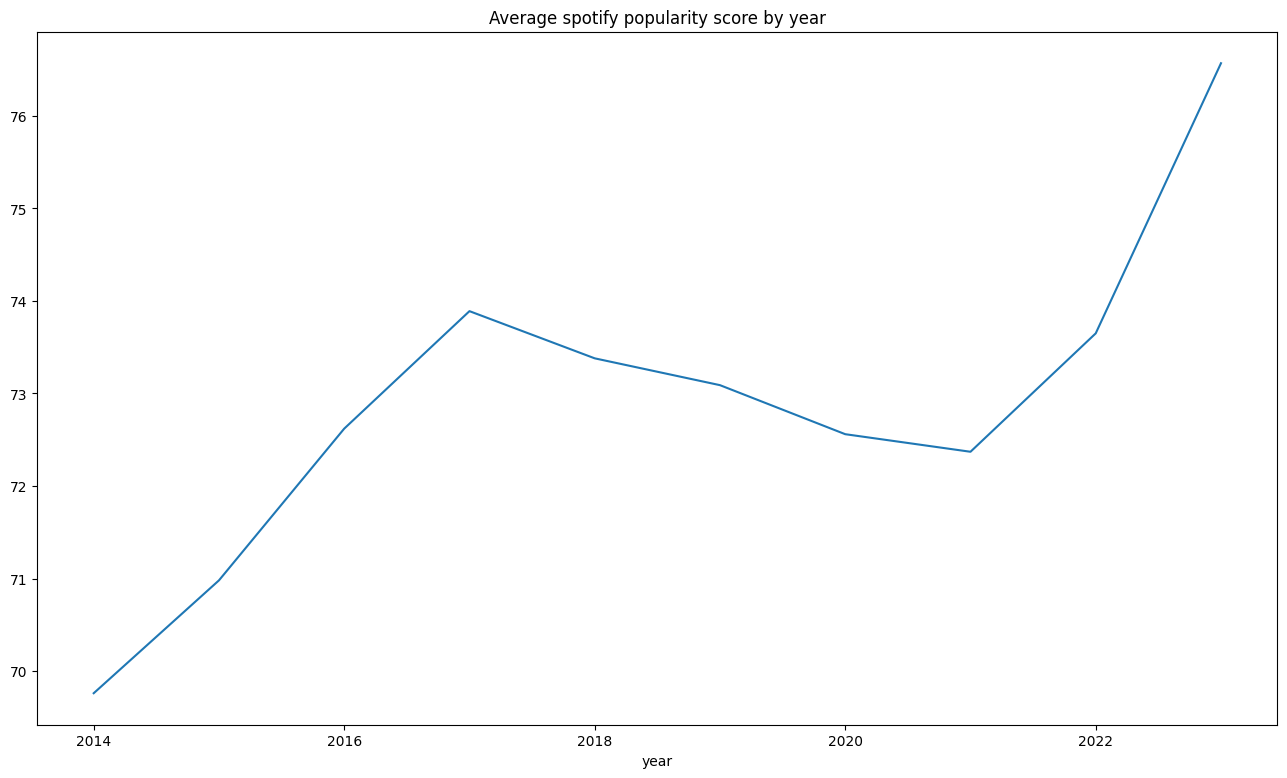

In [15]:
df.groupby('year')['popularity'].mean().plot(kind ='line',figsize=(16,9),title = 'Average spotify popularity score by year')

note: the popularity data from spotify is up -to-date (real time change depend on the often they are played on the present )

In [16]:
!pip install plotly


#### Genre Popularity

In [17]:
df['norm_genres']


,norm_genres
0,Pop
1,Pop
2,Pop
3,Pop
4,Pop
...,...
995,Latin
996,Hip Hop/Rap
997,Other
998,Pop


In [18]:

 df.groupby(['year', 'norm_genres']).size().unstack()

<ipython-input-18-d9495f345453>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['year', 'norm_genres']).size().unstack()


norm_genres,Country/Folk,Electronic/Dance,Hip Hop/Rap,Latin,Other,Pop,R&B/Soul,Reggae/Caribbean,Rock/Alternative,Soundtrack,World Music
year,,,,,,,,,,,
2014,13,2,9,3,9,52,10,0,1,0,1
2015,6,1,10,1,12,52,12,2,3,1,0
2016,3,1,17,0,9,56,13,0,1,0,0
2017,6,1,29,3,8,49,4,0,0,0,0
2018,8,3,30,4,4,48,3,0,0,0,0
2019,13,2,28,3,6,44,4,0,0,0,0
2020,19,0,33,0,9,32,6,0,0,0,1
2021,17,2,18,3,15,34,8,0,0,0,3
2022,23,1,9,10,19,29,6,0,1,0,2


In [19]:
import plotly.graph_objects as go
import pandas as pd

# Your existing groupby statement
grouped_df = df.groupby(['year', 'norm_genres']).size().unstack()

# Reset the index so 'year' becomes a column
grouped_df = grouped_df.reset_index()

# Create a figure
fig = go.Figure()

# Add bars for each genre (separate bars for each year)
for genre in grouped_df.columns[1:]:  # Skip the 'year' column
    fig.add_trace(go.Bar(
        x=grouped_df['year'],
        y=grouped_df[genre],
        name=genre,
        marker_line_width=1.5  # Add a border for larger visual impact
    ))

# Update layout for separate bars and interactivity
fig.update_layout(
    barmode='group',   # Group bars instead of stacking them
    title='Genre Trends Over Time (2014-2023)',
    xaxis_title='Year',
    yaxis_title='Number of Songs',
    height=900,        # Height of the plot
    width=1200,        # Width of the plot
    bargap=0.1,        # Adjust bar gap to make bars bigger
    hovermode='x unified'  # Show hover info for all genres together
)

# Show the interactive plot
fig.show()


<ipython-input-19-dac1c4b652c8>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['year', 'norm_genres']).size().unstack()


#### Audio Feature Trends

In [20]:
df['instrumentalness']

,instrumentalness
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
995,0.000026
996,0.0
997,0.0
998,0.000002


array([<Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>], dtype=object)

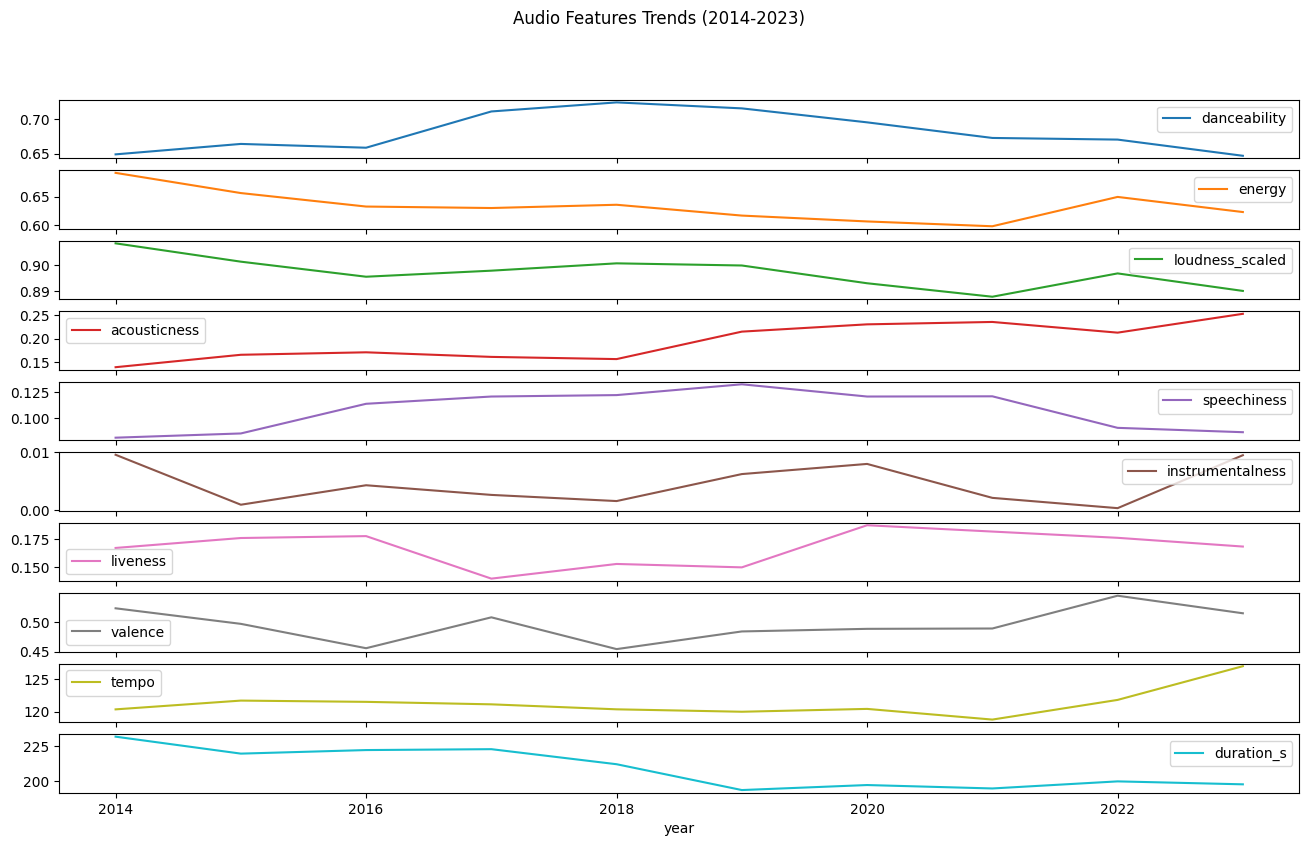

In [21]:
audio_features = ['danceability', 'energy', 'loudness_scaled', 'acousticness','speechiness','instrumentalness','liveness','valence', 'tempo','duration_s']
df.groupby('year')[audio_features].mean().plot(kind='line', figsize=(16,9), subplots=True, title='Audio Features Trends (2014-2023)')


In [29]:
df.groupby('year')['key'].value_counts().dropna().unstack()

key,0,1,2,3,4,5,6,7,8,9,10,11
year,,,,,,,,,,,,
2014,6,14,7,3,4,5,8,13,8,15,8,9
2015,12,17,8,<NA>,10,11,4,10,13,8,2,5
2016,12,9,4,1,7,6,9,16,8,7,8,13
2017,12,18,6,1,3,10,5,7,9,6,9,14
2018,6,15,7,2,2,13,7,7,9,10,9,13
2019,9,19,10,1,8,10,8,6,12,5,7,5
2020,13,10,5,2,7,5,11,12,7,8,9,11
2021,15,14,6,5,8,7,10,6,10,4,4,11
2022,10,17,12,3,8,11,5,7,12,5,5,5


In [30]:
import plotly.express as px
import pandas as pd

# Step 1: Create a mapping from numeric key values to musical keys
key_mapping = {
    0: 'C', 1: 'C#/Db', 2: 'D', 3: 'D#/Eb', 4: 'E', 5: 'F',
    6: 'F#/Gb', 7: 'G', 8: 'G#/Ab', 9: 'A', 10: 'A#/Bb', 11: 'B'
}

# Step 2: Group by year and count the occurrences of each key
key_distribution = df.groupby(['year', 'key']).size().unstack(fill_value=0)

# Step 3: Reset the index and melt the data to a long format for Plotly
key_distribution = key_distribution.reset_index().melt(id_vars='year', var_name='key', value_name='count')

# Step 4: Map the key numbers to their corresponding names
key_distribution['key'] = key_distribution['key'].map(key_mapping)

# Step 5: Create the interactive plot using Plotly
fig = px.bar(key_distribution, x='year', y='count', color='key',
             title='Interactive Key Distribution by Year',
             labels={'count': 'Number of Songs', 'year': 'Year'},
             color_discrete_sequence=px.colors.qualitative.Set3)

# Step 6: Customize the layout
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'},
                  legend_title_text='Musical Key')

# Show the interactive plot
fig.show()


In [31]:
df.groupby('year')['mode'].value_counts().unstack()

mode,0,1
year,,
2014,33,67
2015,33,67
2016,48,52
2017,43,57
2018,37,63
2019,37,63
2020,47,53
2021,35,65
2022,32,68


In [32]:
import plotly.express as px
import pandas as pd

# Step 1: Group by year and count the occurrences of each mode (0 = minor, 1 = major)
mode_distribution = df.groupby(['year', 'mode']).size().unstack(fill_value=0)

# Step 2: Reset index and reshape the data using melt to long format for Plotly
mode_distribution = mode_distribution.reset_index().melt(id_vars='year', var_name='mode', value_name='count')

# Step 3: Map the mode values (0 = Minor, 1 = Major)
mode_mapping = {0: 'Minor (0)', 1: 'Major (1)'}
mode_distribution['mode'] = mode_distribution['mode'].map(mode_mapping)

# Step 4: Create the interactive stacked bar plot using Plotly
fig = px.bar(mode_distribution, x='year', y='count', color='mode',
             title='Interactive Mode Distribution by Year (Major = 1, Minor = 0)',
             labels={'count': 'Number of Songs', 'year': 'Year'},
             color_discrete_sequence=['lightblue', 'orange'])

# Step 5: Customize layout
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'},
                  legend_title_text='Mode')

# Show the interactive plot
fig.show()


###Top Songs and Artists Analysis

In [33]:


# Get the top 5 songs for each year sorted by rank
top_songs = df.groupby('year').apply(lambda x: x.sort_values(by='rank', ascending=True).head(5)).reset_index(drop=True)


def path_to_image_html(path):
    return f'<img src="{path}" width="35" height="35">'

top_songs['artist_image_icon'] = top_songs['artist_image'].apply(path_to_image_html)


columns_to_display = ['year', 'song_title', 'artist', 'rank', 'artist_image_icon']

# Render the DataFrame as an HTML table with images
from IPython.core.display import display, HTML
display(HTML(top_songs[columns_to_display].to_html(escape=False, index=False)))


year,song_title,artist,rank,artist_image_icon
2014,Happy,Pharrell Williams,1,
2014,Dark Horse,Katy Perry Featuring Juicy J,2,
2014,All Of Me,John Legend,3,
2014,Fancy,Iggy Azalea Featuring Charli XCX,4,
2014,Counting Stars,OneRepublic,5,
2015,Uptown Funk!,Mark Ronson Featuring Bruno Mars,1,
2015,Thinking Out Loud,Ed Sheeran,2,
2015,See You Again,Wiz Khalifa Featuring Charlie Puth,3,
2015,Trap Queen,Fetty Wap,4,
2015,Sugar,Maroon 5,5,


####Most appear on the billboard charts 2014-2023 ignoring rank

In [34]:
# Step 1: Count appearances and get the top 10 artists
most_appearances = df.groupby('artist').size().sort_values(ascending=False).reset_index(name='appearances').head(10)

# Step 2: Get unique artist images by merging with the original DataFrame (assuming 'artist_image' exists)
artist_images = df[['artist', 'artist_image']].drop_duplicates()

# Step 3: Merge the top 10 most_appearances DataFrame with the artist images
most_appearances_with_images = pd.merge(most_appearances, artist_images, on='artist', how='left')

# Step 4: Convert image URLs into HTML <img> tags
def path_to_image_html(path):
    return f'<img src="{path}" width="60" height="60">'

most_appearances_with_images['artist_image_html'] = most_appearances_with_images['artist_image'].apply(path_to_image_html)

# Step 5: Display the table with the image, artist name, and appearance count for top 10 artists
columns_to_display = ['artist_image_html', 'artist', 'appearances']

# Render the DataFrame as an HTML table with images
from IPython.core.display import display, HTML
display(HTML(most_appearances_with_images[columns_to_display].to_html(escape=False, index=False)))


artist_image_html,artist,appearances
,Drake,15
,Morgan Wallen,14
,Taylor Swift,14
,Luke Combs,13
,Ed Sheeran,13
,The Weeknd,11
,Ariana Grande,11
,Dua Lipa,8
,Shawn Mendes,8
,Billie Eilish,8


#### Most consistent artist

In [35]:
consistent_artists = df.groupby('artist')['year'].nunique().sort_values(ascending=False).reset_index(name='year_unique').head(10)
artist_images = df[['artist', 'artist_image']].drop_duplicates()
consistent_artist_with_image = pd.merge(consistent_artists, artist_images, on='artist', how='left')
def path_to_image_html(path):
    return f'<img src="{path}" width="60" height="60">'
consistent_artist_with_image['artist_image_html'] =consistent_artist_with_image['artist_image'].apply(path_to_image_html)
columns_to_display = ['artist_image_html', 'artist', 'year_unique']

# Render the DataFrame as an HTML table with images
from IPython.core.display import display, HTML
display(HTML(consistent_artist_with_image[columns_to_display].to_html(escape=False, index=False)))


artist_image_html,artist,year_unique
,Taylor Swift,9
,Drake,8
,Ed Sheeran,7
,Luke Combs,7
,Travis Scott,5
,Ariana Grande,5
,Sam Smith,5
,Dua Lipa,5
,Post Malone,5
,The Weeknd,5


#### Top score artist

In [36]:
import pandas as pd
from IPython.display import display, HTML

# Step 1: Create a new column to calculate the score for each artist based on their rank
df['score'] = 101 - df['rank']  # 100 points for rank 1, 1 point for rank 100

# Step 2: Group by artist and sum the scores
artist_scores = df.groupby('artist')['score'].sum().sort_values(ascending=False).reset_index()

# Step 3: Rename columns for clarity
artist_scores.rename(columns={'score': 'total_score'}, inplace=True)

# Step 4: Get unique artist images (assuming 'artist_image' exists in df)
artist_images = df[['artist', 'artist_image']].drop_duplicates()

# Step 5: Merge the artist scores with the artist images
artist_scores_with_images = pd.merge(artist_scores, artist_images, on='artist', how='left')

# Step 6: Convert image URLs into HTML <img> tags for display
def path_to_image_html(path):
    return f'<img src="{path}" width="60" height="60">'

artist_scores_with_images['artist_image_html'] = artist_scores_with_images['artist_image'].apply(path_to_image_html)

# Step 7: Select columns to display in the table (artist image, name, and total score)
columns_to_display = ['artist_image_html', 'artist', 'total_score']

# Step 8: Render the DataFrame as an HTML table with images
display(HTML(artist_scores_with_images[columns_to_display].head(10).to_html(escape=False, index=False)))


artist_image_html,artist,total_score
,Taylor Swift,924
,Ed Sheeran,866
,Drake,818
,Morgan Wallen,794
,The Weeknd,716
,Ariana Grande,647
,Luke Combs,565
,Post Malone,533
,Justin Bieber,500
,Dua Lipa,489


####The most success artist by my metrics

In [37]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

# Step 1: Create the initial score based on ranks
df['score'] = 101 - df['rank']

# Step 2: Group by artist to calculate various metrics
artist_stats = df.groupby('artist').agg(
    total_appearances=('rank', 'size'),                # Number of chart appearances
    total_score=('score', 'sum'),                      # Total score based on rank
    avg_rank=('rank', 'mean'),                         # Average rank
    best_rank=('rank', 'min'),                         # Best rank achieved (lower is better)
    longevity=('year', 'nunique')                      # Number of unique years on the chart
).reset_index()

# Step 3: Normalize each metric (using MinMaxScaler to bring them to a 0-1 scale)
scaler = MinMaxScaler()

# Normalize total_appearances, total_score, avg_rank, best_rank, longevity
artist_stats[['norm_total_appearances', 'norm_total_score', 'norm_avg_rank', 'norm_best_rank', 'norm_longevity']] = scaler.fit_transform(
    artist_stats[['total_appearances', 'total_score', 'avg_rank', 'best_rank', 'longevity']]
)

# Step 4: Combine the metrics into a composite score (you can tweak the weights)
artist_stats['success_score'] = (
    artist_stats['norm_total_appearances'] * 0.25 +  # Weight of 25% for number of appearances
    artist_stats['norm_total_score'] * 0.35 +        # Weight of 35% for total score based on rank
    (1 - artist_stats['norm_avg_rank']) * 0.15 +     # Weight of 15% for average rank (inverted so lower avg rank is better)
    (1 - artist_stats['norm_best_rank']) * 0.15 +    # Weight of 15% for peak rank (inverted so lower rank is better)
    artist_stats['norm_longevity'] * 0.10            # Weight of 10% for longevity (number of years on the chart)
)

# Step 5: Sort by the success score to get the top 10 successful artists
top_successful_artists = artist_stats.sort_values(by='success_score', ascending=False).head(10)

# Step 6: Merge artist images (assuming 'artist_image' exists in df)
artist_images = df[['artist', 'artist_image']].drop_duplicates()

# Merge the top successful artists with their images
top_successful_artists_with_images = pd.merge(top_successful_artists, artist_images, on='artist', how='left')

# Step 7: Convert image URLs into HTML <img> tags
def path_to_image_html(path):
    return f'<img src="{path}" width="60" height="60">'

top_successful_artists_with_images['artist_image_html'] = top_successful_artists_with_images['artist_image'].apply(path_to_image_html)

# Step 8: Select columns to display
columns_to_display = ['artist_image_html', 'artist', 'total_appearances', 'total_score', 'avg_rank', 'best_rank', 'longevity', 'success_score']

# Step 9: Render the DataFrame as an HTML table with images
display(HTML(top_successful_artists_with_images[columns_to_display].to_html(escape=False, index=False)))


artist_image_html,artist,total_appearances,total_score,avg_rank,best_rank,longevity,success_score
,Taylor Swift,14,924,35.0,4,9,0.926082
,Drake,15,818,46.466667,1,8,0.878416
,Ed Sheeran,13,866,34.384615,1,7,0.866709
,Morgan Wallen,14,794,44.285714,1,4,0.804763
,The Weeknd,11,716,35.909091,1,5,0.746806
,Luke Combs,13,565,57.538462,8,7,0.706883
,Ariana Grande,11,647,42.181818,7,5,0.702046
,Post Malone,8,533,34.375,2,5,0.624650
,Justin Bieber,7,500,29.571429,1,5,0.603073
,Dua Lipa,8,489,39.875,1,5,0.601147


### Analyze audio feature

####Correlation Between Audio Features and Rank

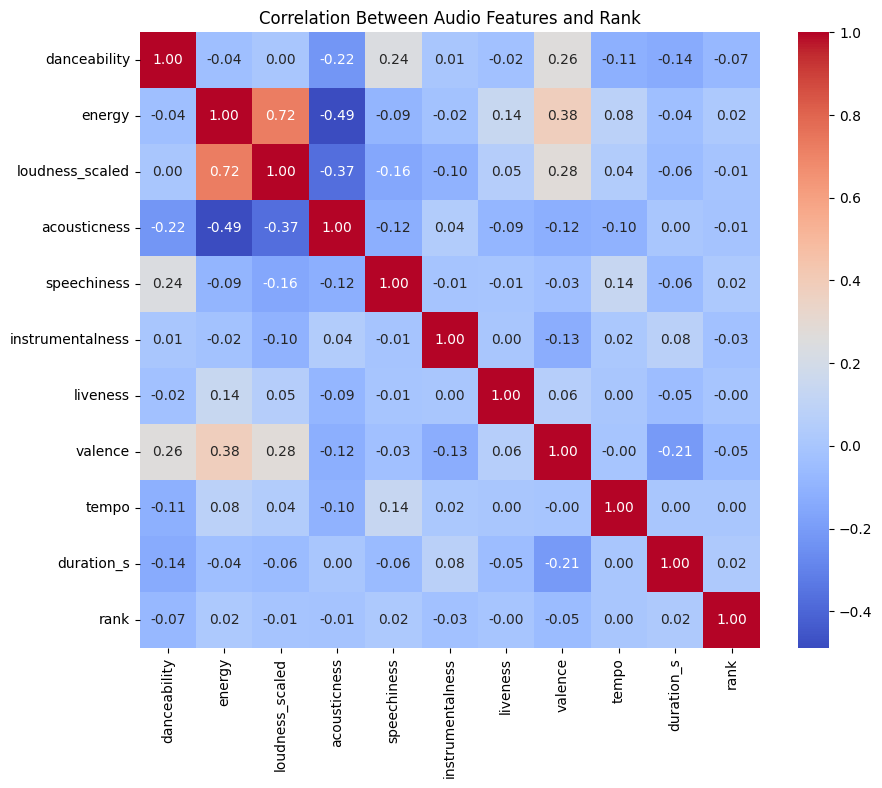

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a correlation heatmap between audio features and rank
plt.figure(figsize=(10, 8))

# Selecting the audio features and rank for correlation
audio_features =['danceability', 'energy', 'loudness_scaled', 'acousticness','speechiness','instrumentalness','liveness','valence', 'tempo','duration_s','rank']
correlation_matrix = df[audio_features].corr()

# Visualizing the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Audio Features and Rank')
plt.show()



In [38]:
import plotly.graph_objects as go

# Step 1: Create an empty DataFrame to store the year-by-year correlations
yearly_correlation = pd.DataFrame()

# Step 2: Calculate the correlation between 'rank' and each audio feature, year by year
for year in df['year'].unique():
    year_data = df[df['year'] == year]
    correlations = year_data[['rank'] + audio_features].corr().loc['rank', audio_features]
    correlations['year'] = year  # Add the year to the correlation results
    yearly_correlation = pd.concat([yearly_correlation, correlations.to_frame().T], ignore_index=True)

# Step 3: Set 'year' as the index for easier plotting
yearly_correlation.set_index('year', inplace=True)

# Step 4: Create the interactive line plot using Plotly
fig = go.Figure()

# Add a trace for each audio feature
for feature in audio_features:
    fig.add_trace(go.Scatter(
        x=yearly_correlation.index,
        y=yearly_correlation[feature],
        mode='lines+markers',
        name=feature
    ))

# Customize layout
fig.update_layout(
    title='Year-by-Year Correlation Between Rank and Audio Features',
    xaxis_title='Year',
    yaxis_title='Correlation',
    legend_title='Audio Features',
    hovermode='x unified',
    template='plotly_white'
)

# Show the interactive plot
fig.show()


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the audio features you want to analyze
audio_features = ['danceability', 'energy', 'loudness_scaled', 'acousticness', 'speechiness',
                  'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']

# Step 1: Create a line plot for each year and each audio feature
for year in df['year'].unique():
    year_data = df[df['year'] == year]

    # Create subplots for each feature (2x5 grid to fit 10 features)
    fig, axes = plt.subplots(2, 5, figsize=(16, 10))
    fig.suptitle(f'Audio Features vs Rank in {year}', fontsize=16, y=1.02)

    # Flatten the axes array for easier access to each subplot
    axes = axes.flatten()

    # Loop through each feature and create a line plot
    for i, feature in enumerate(audio_features):
        sns.lineplot(x='rank', y=feature, data=year_data, ax=axes[i])
        axes[i].set_title(f'{feature.capitalize()} vs Rank')
        axes[i].set_xlabel('Rank')
        axes[i].set_ylabel(feature.capitalize())
        axes[i].grid(True)

    # Adjust the layout for a cleaner appearance
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to make room for the suptitle
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




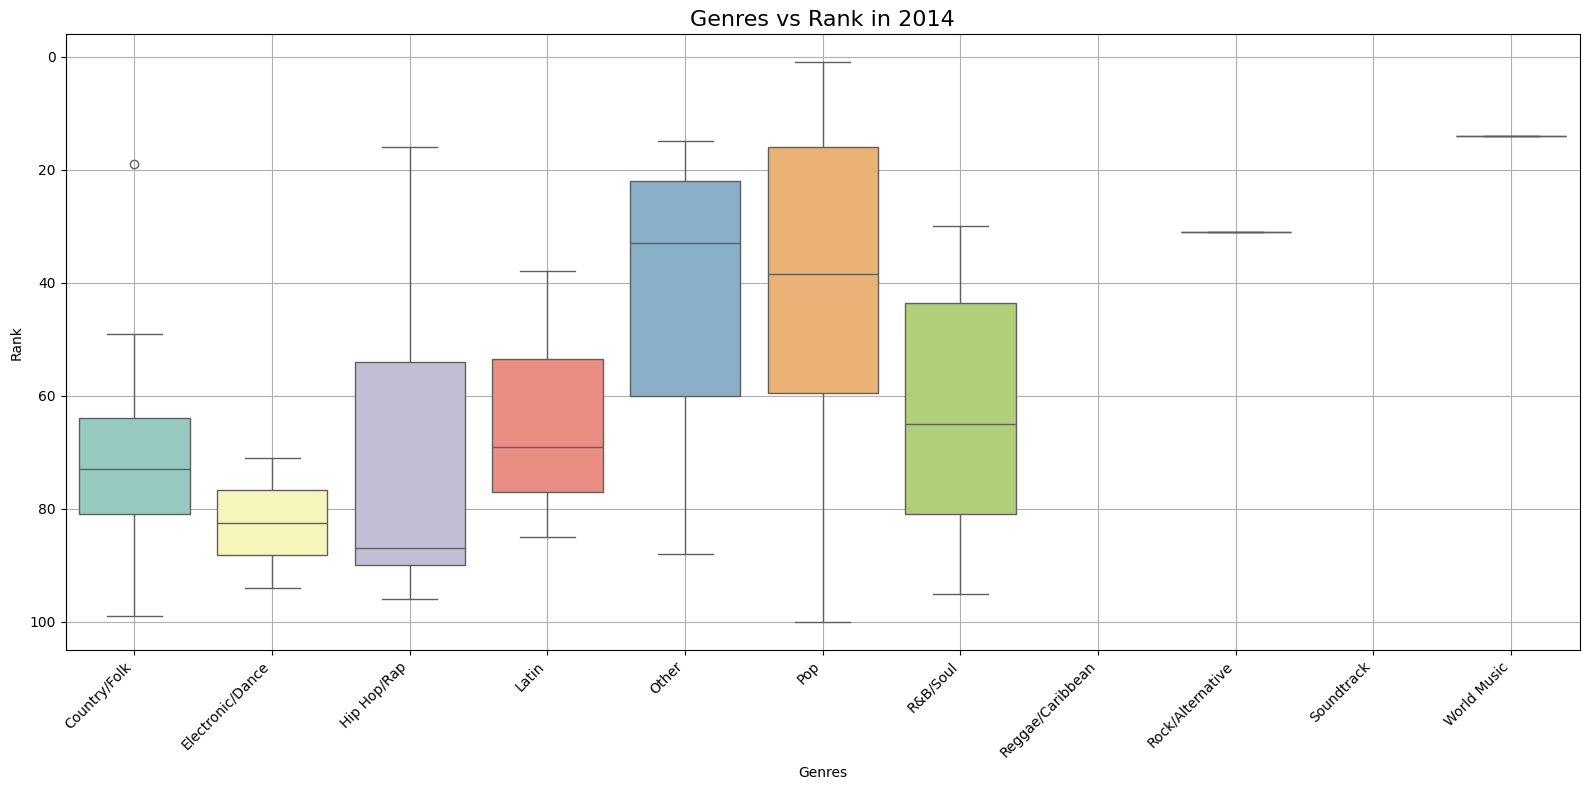

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




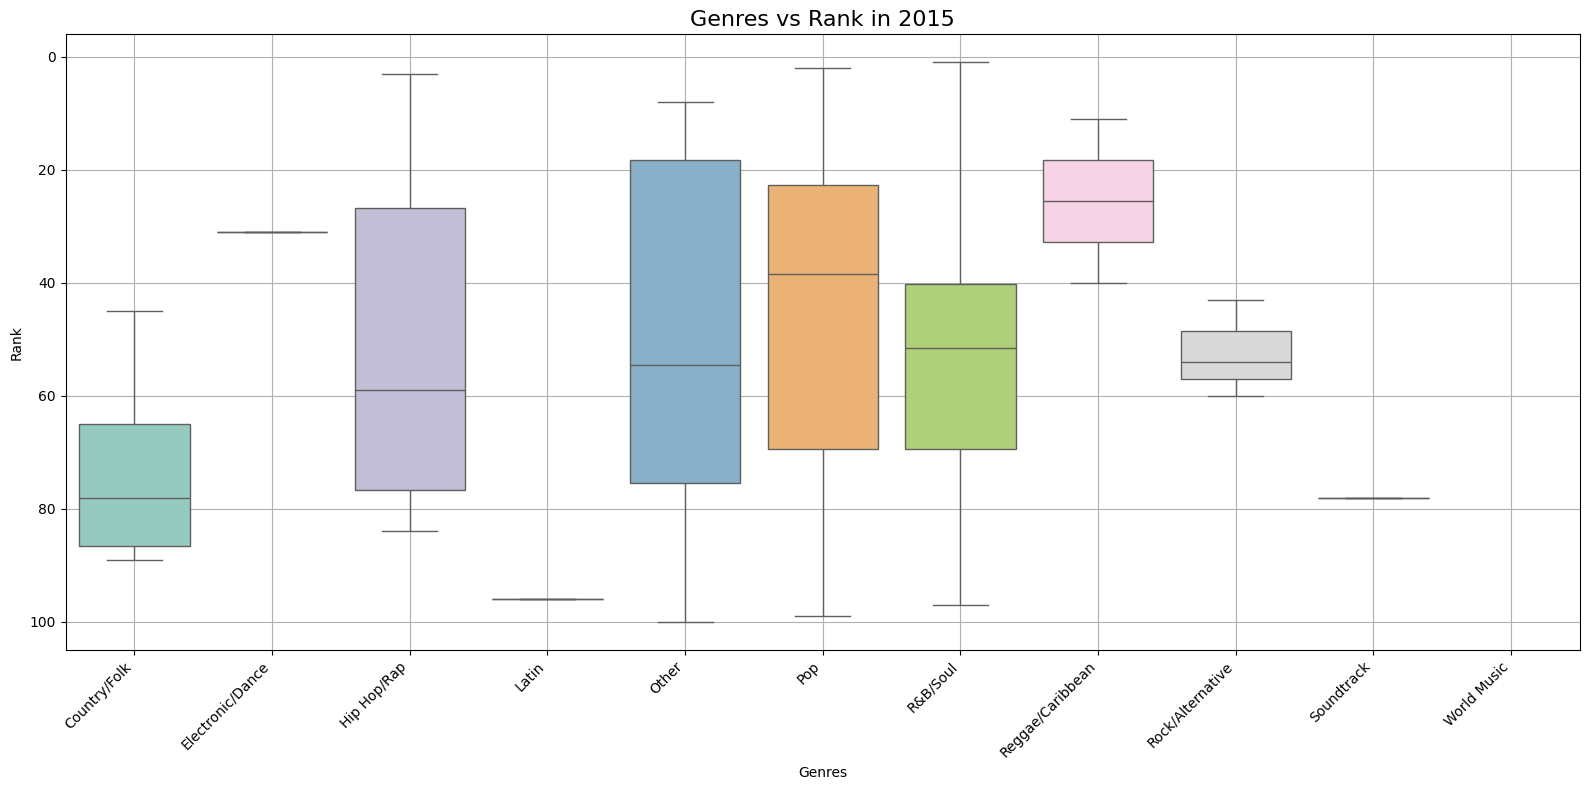

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




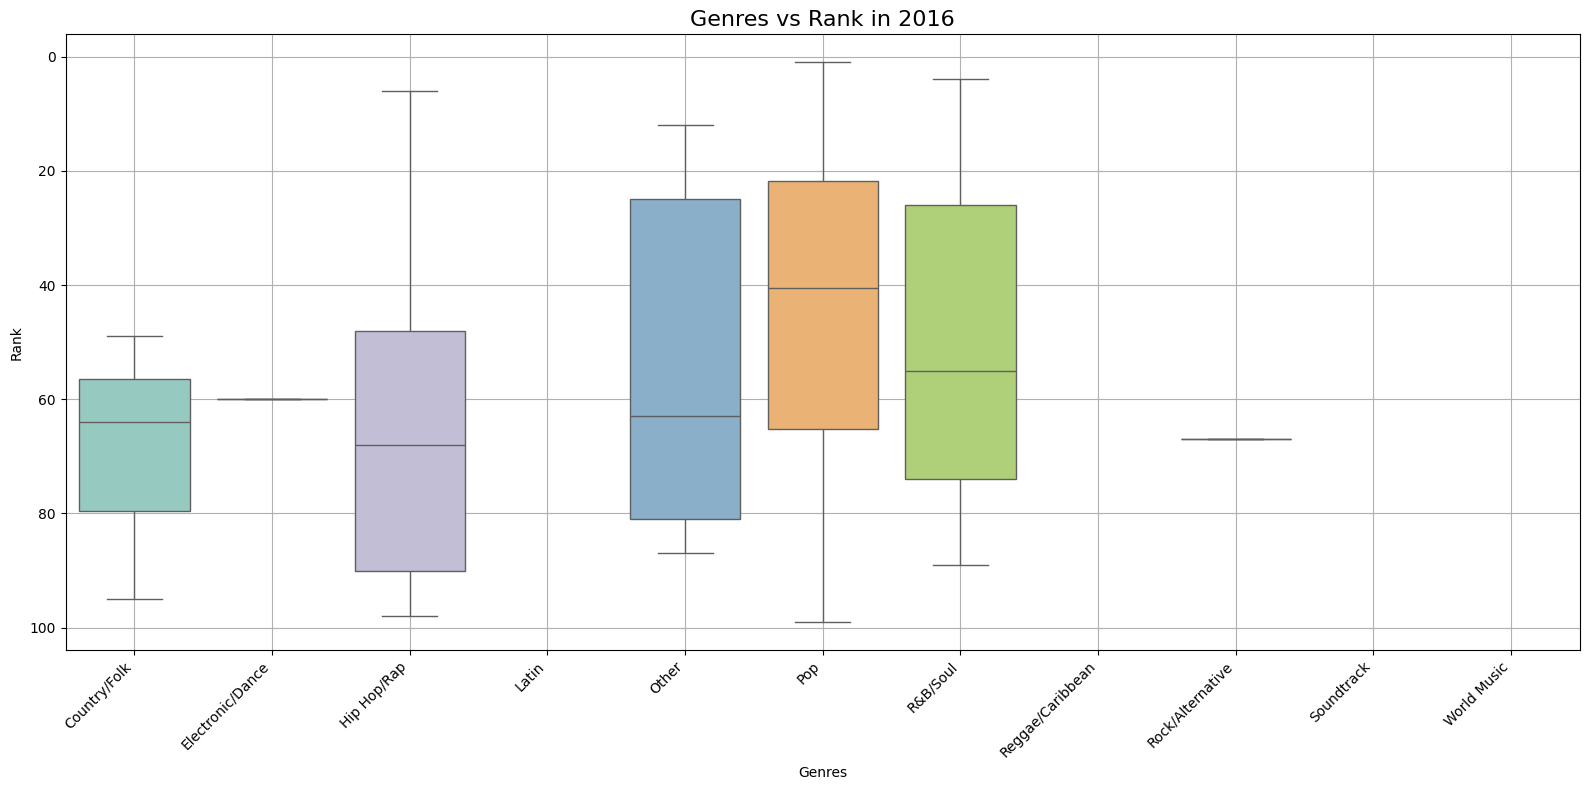

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




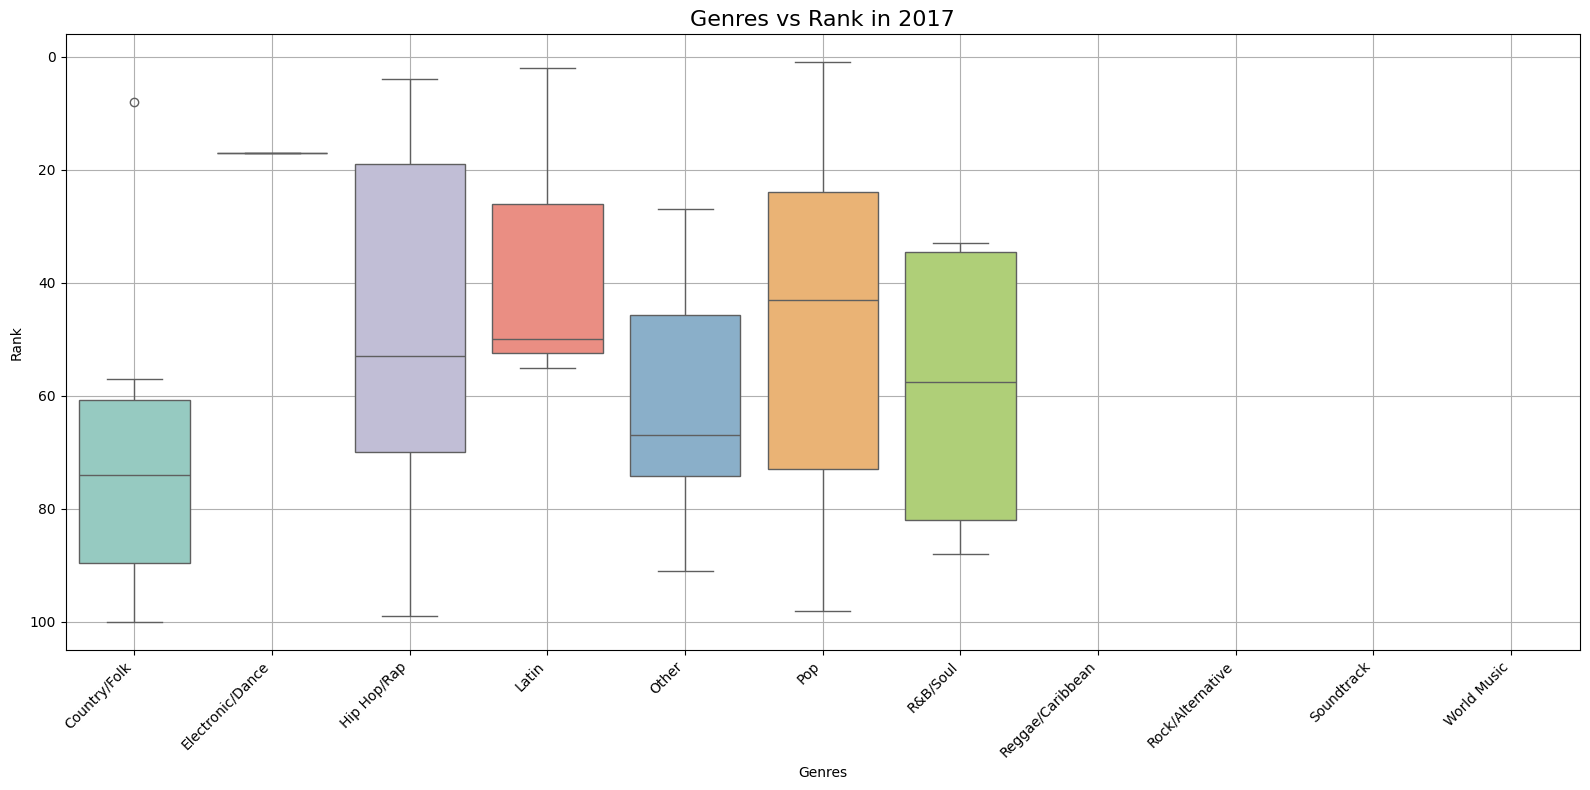

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




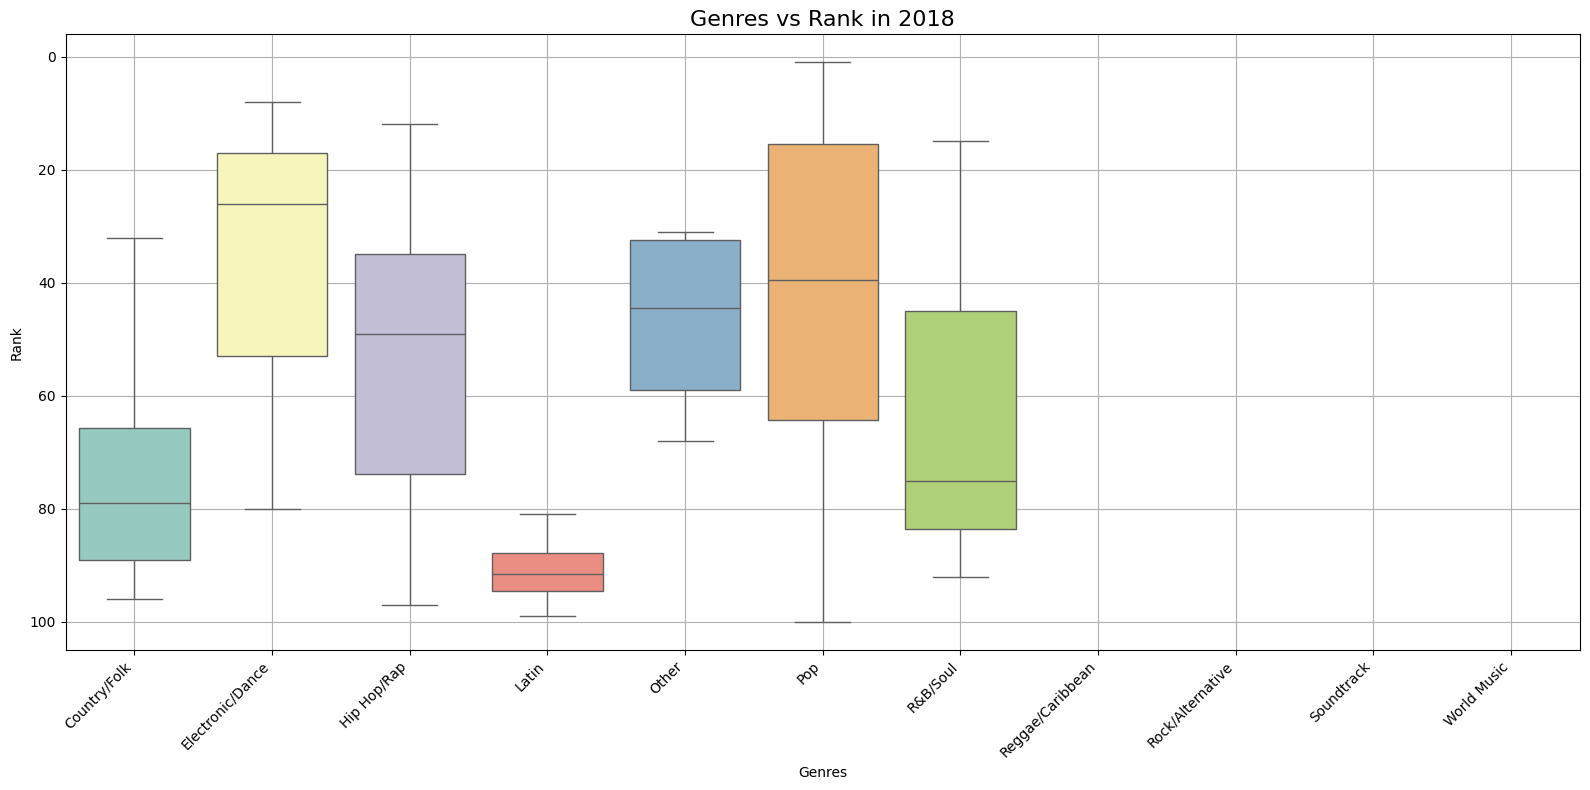

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




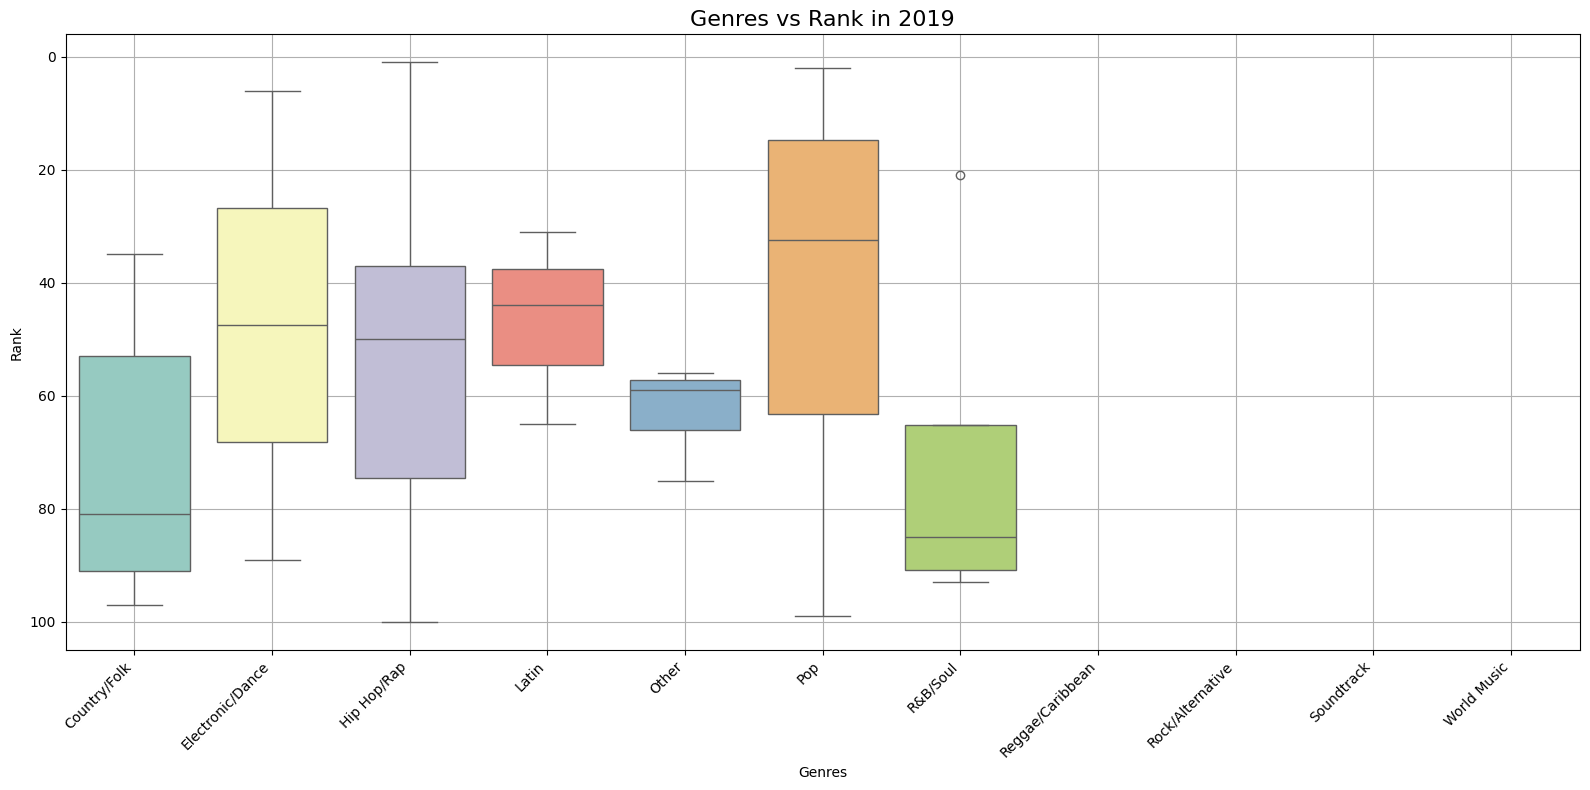

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




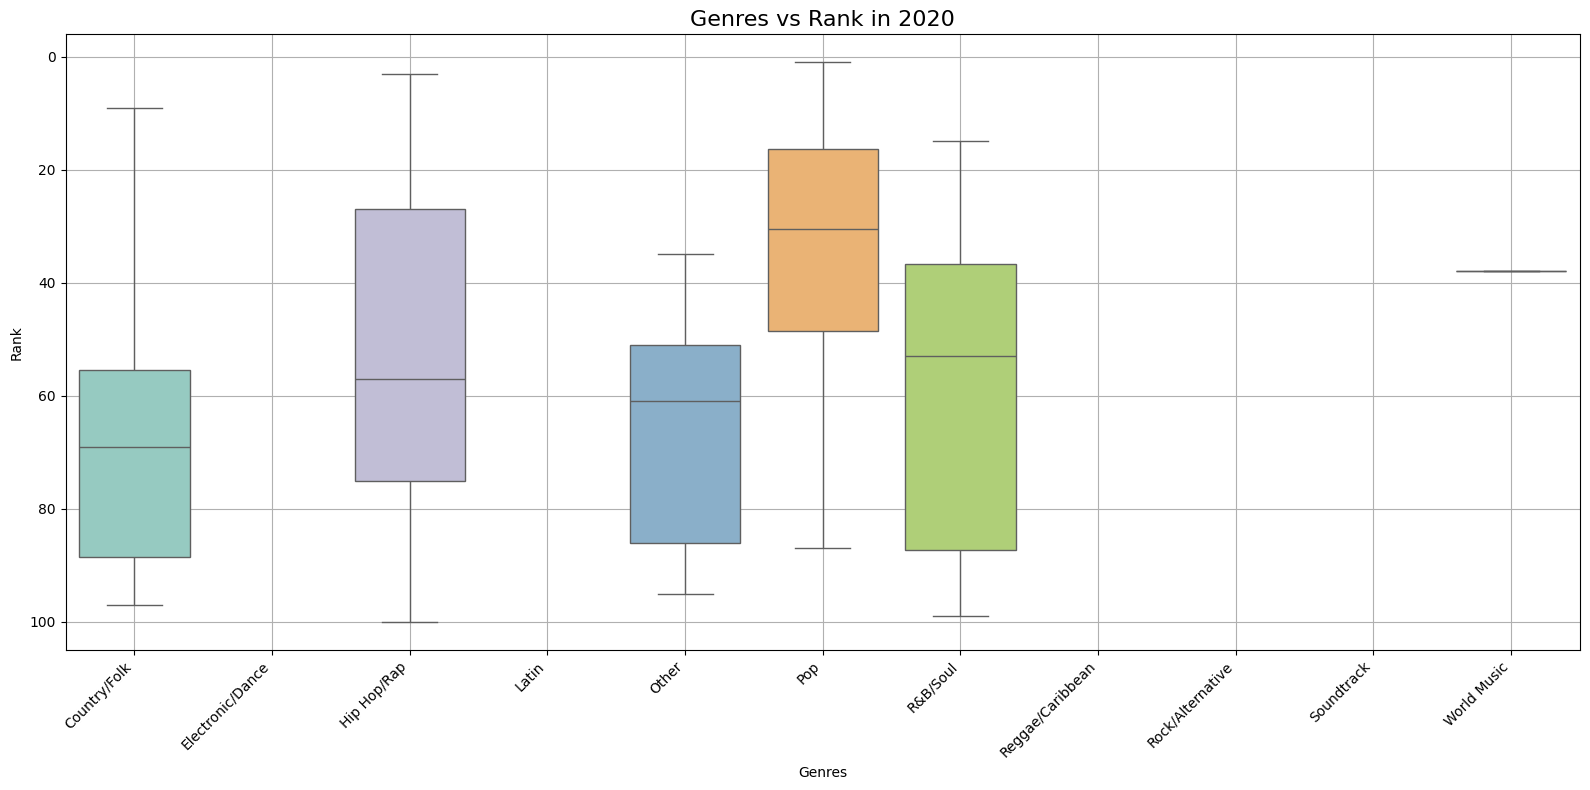

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




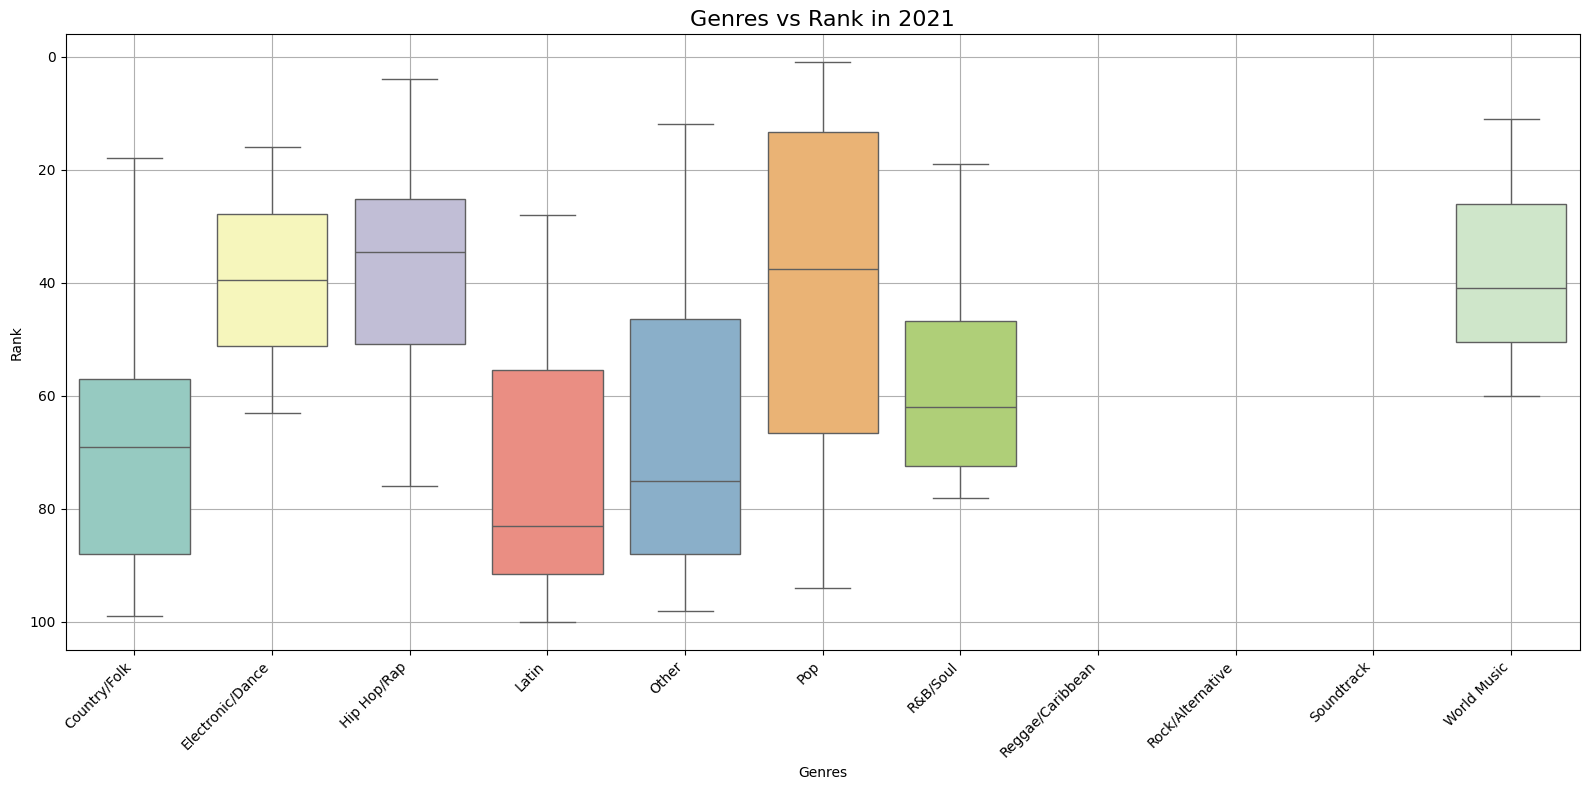

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




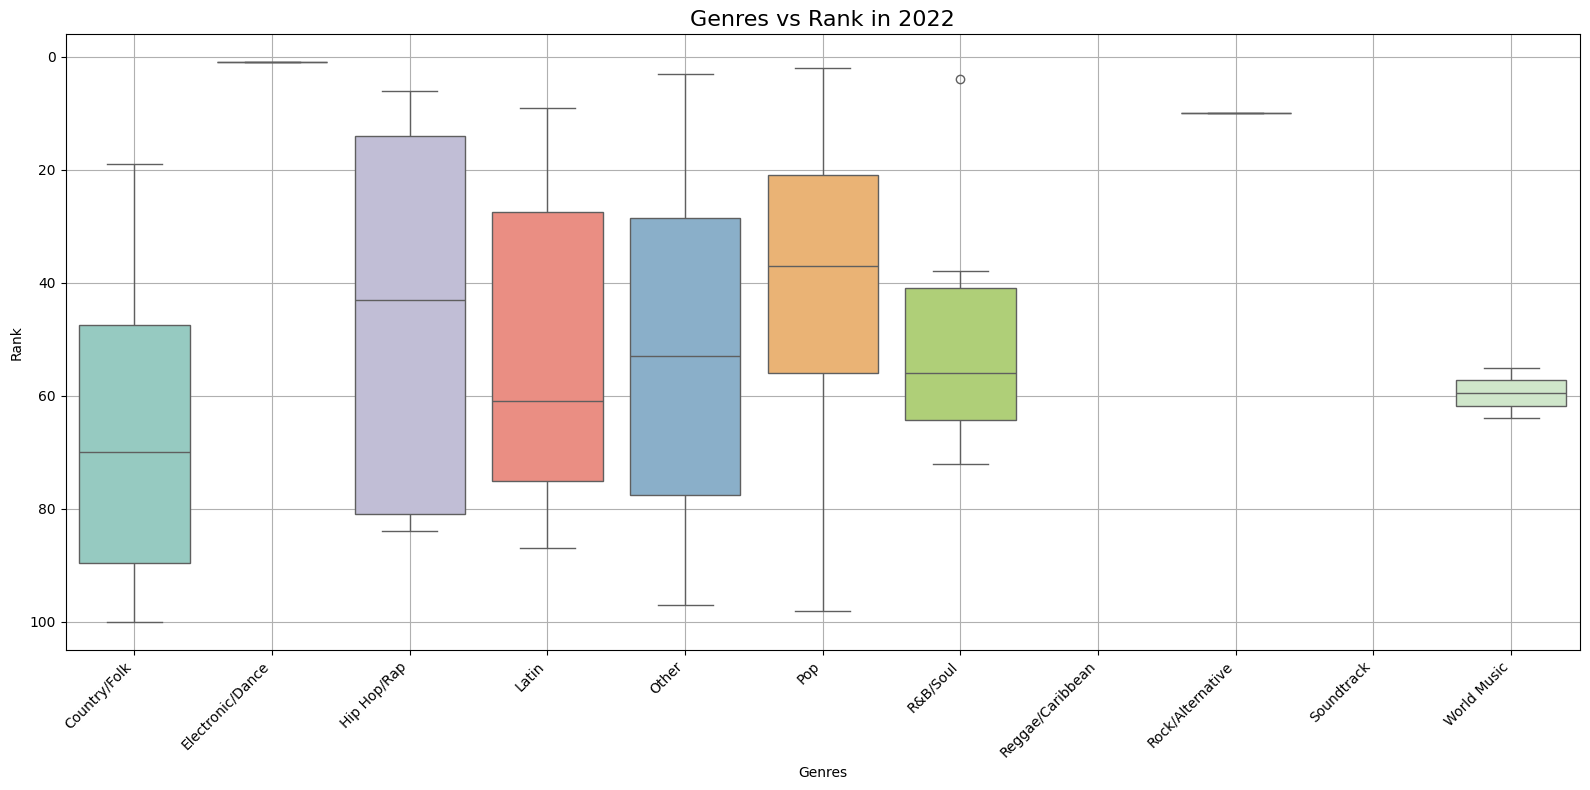

<ipython-input-73-fb8d51ef5410>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




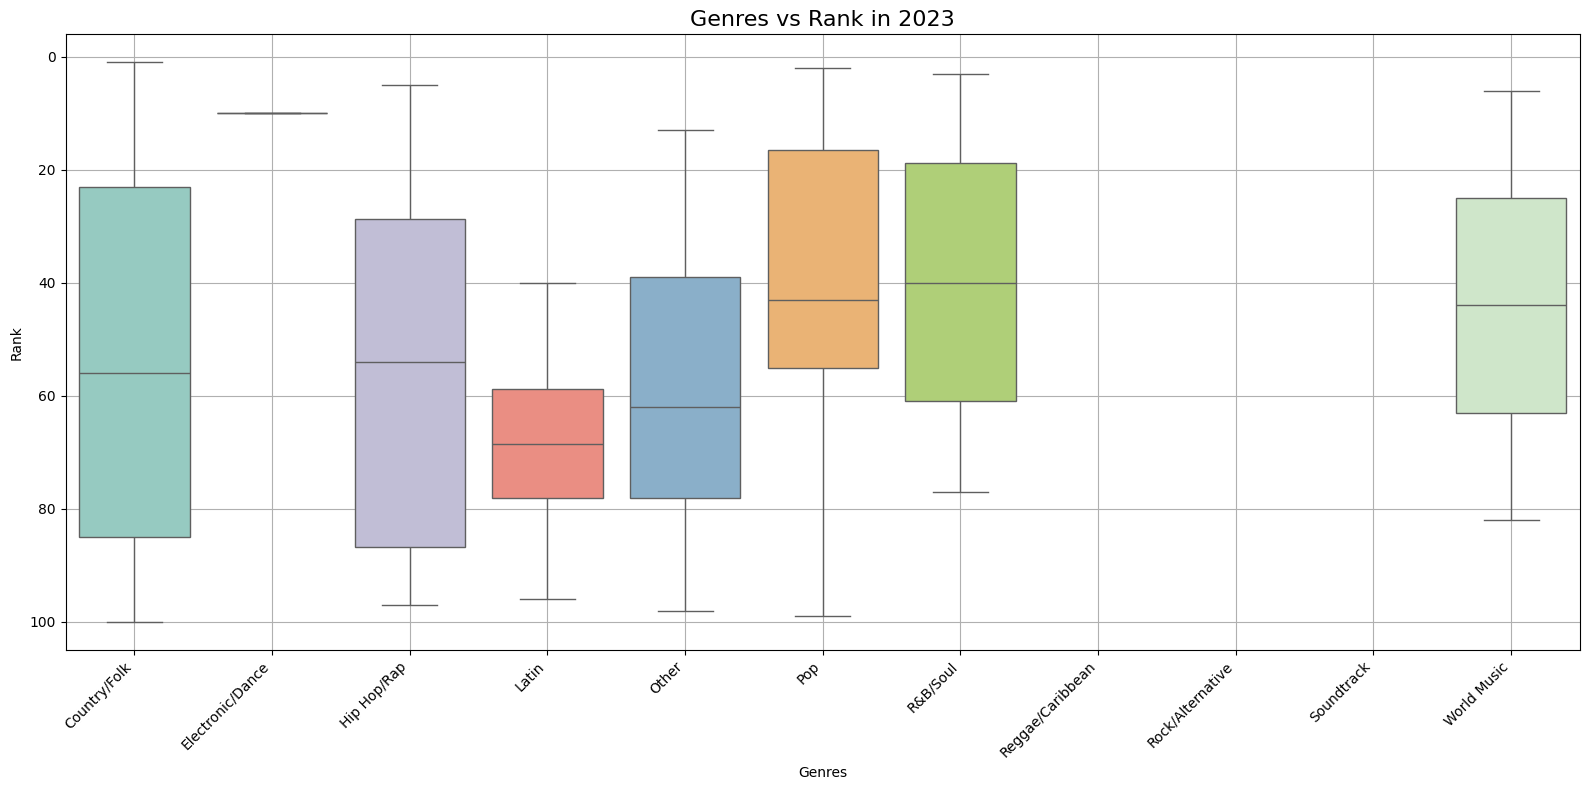

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create a plot for each year to show genres vs rank
for year in df['year'].unique():
    year_data = df[df['year'] == year]

    # Step 2: Create a figure and axis for the current year
    plt.figure(figsize=(16, 8))

    # Step 3: Create a boxplot or stripplot to visualize genre vs rank
    sns.boxplot(x='norm_genres', y='rank', data=year_data, palette='Set3')

    # Step 4: Customize the plot with title and labels
    plt.title(f'Genres vs Rank in {year}', fontsize=16)
    plt.xlabel('Genres')
    plt.ylabel('Rank')
    plt.xticks(rotation=45, ha='right')  # Rotate genre labels for better readability
    plt.gca().invert_yaxis()  # Invert the y-axis because lower rank is better (1 is top rank)
    plt.grid(True)

    # Step 5: Show the plot
    plt.tight_layout()
    plt.show()


#### Correlation Between Audio Features, Mode, Explicit and Genres

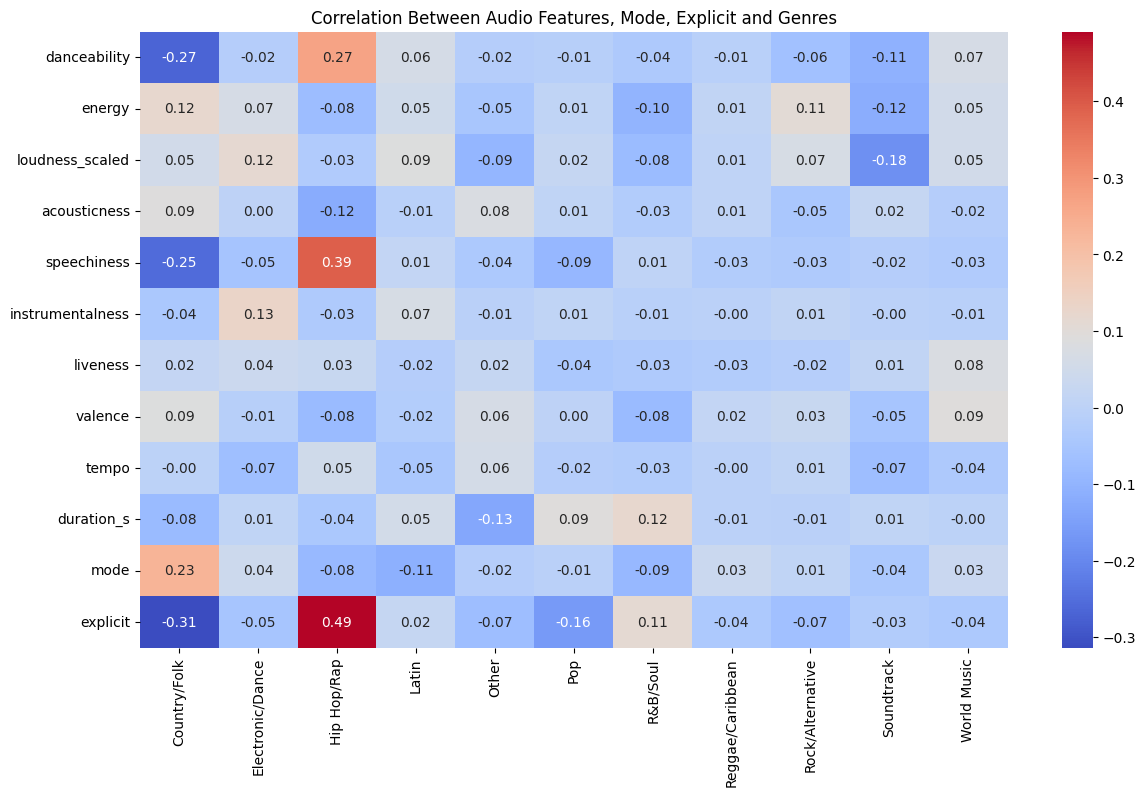

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: One-Hot Encode the genres
df_encoded = pd.get_dummies(df['norm_genres'])

# Step 2: Combine the encoded genres, mode, explicit, and audio features
audio_features = ['danceability', 'energy', 'loudness_scaled', 'acousticness', 'speechiness',
                  'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']

# Include 'mode' and 'explicit' in the list of features
additional_features = ['mode', 'explicit']
df_combined = pd.concat([df[audio_features + additional_features], df_encoded], axis=1)

# Step 3: Calculate the correlation between audio features, mode, explicit, and genres
correlation_matrix = df_combined.corr()

# Step 4: Filter the correlation matrix to show only the correlations between audio features (including mode and explicit) and genres
corr_audio_genres = correlation_matrix.loc[audio_features + additional_features, df_encoded.columns]

# Step 5: Visualize the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(corr_audio_genres, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Audio Features, Mode, Explicit and Genres')
plt.show()


<ipython-input-52-f45f5f8f86cb>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



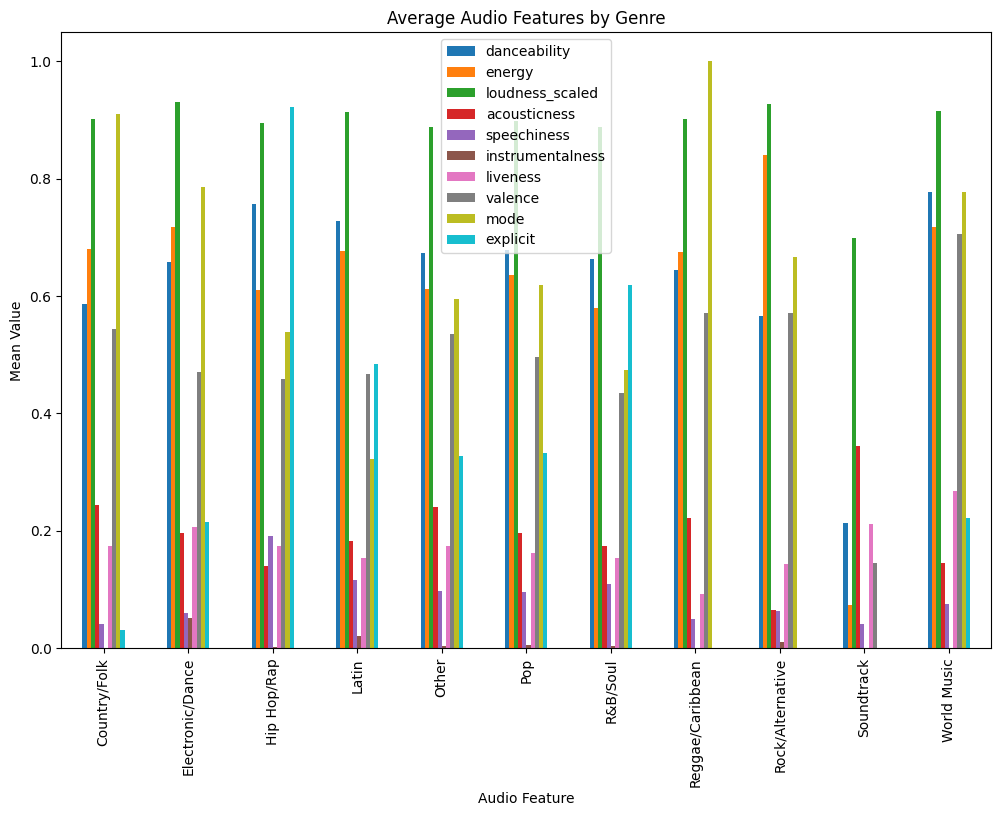

In [52]:

audio_features = ['danceability', 'energy', 'loudness_scaled', 'acousticness', 'speechiness',
                  'instrumentalness', 'liveness', 'valence','mode','explicit']
df.groupby('norm_genres')[audio_features].mean().plot(kind='bar', figsize=(12, 8), title='Average Audio Features by Genre')
plt.ylabel('Mean Value')
plt.xlabel('Audio Feature')
plt.show()


#### Top 25 audio feature and song characteristics of each year

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




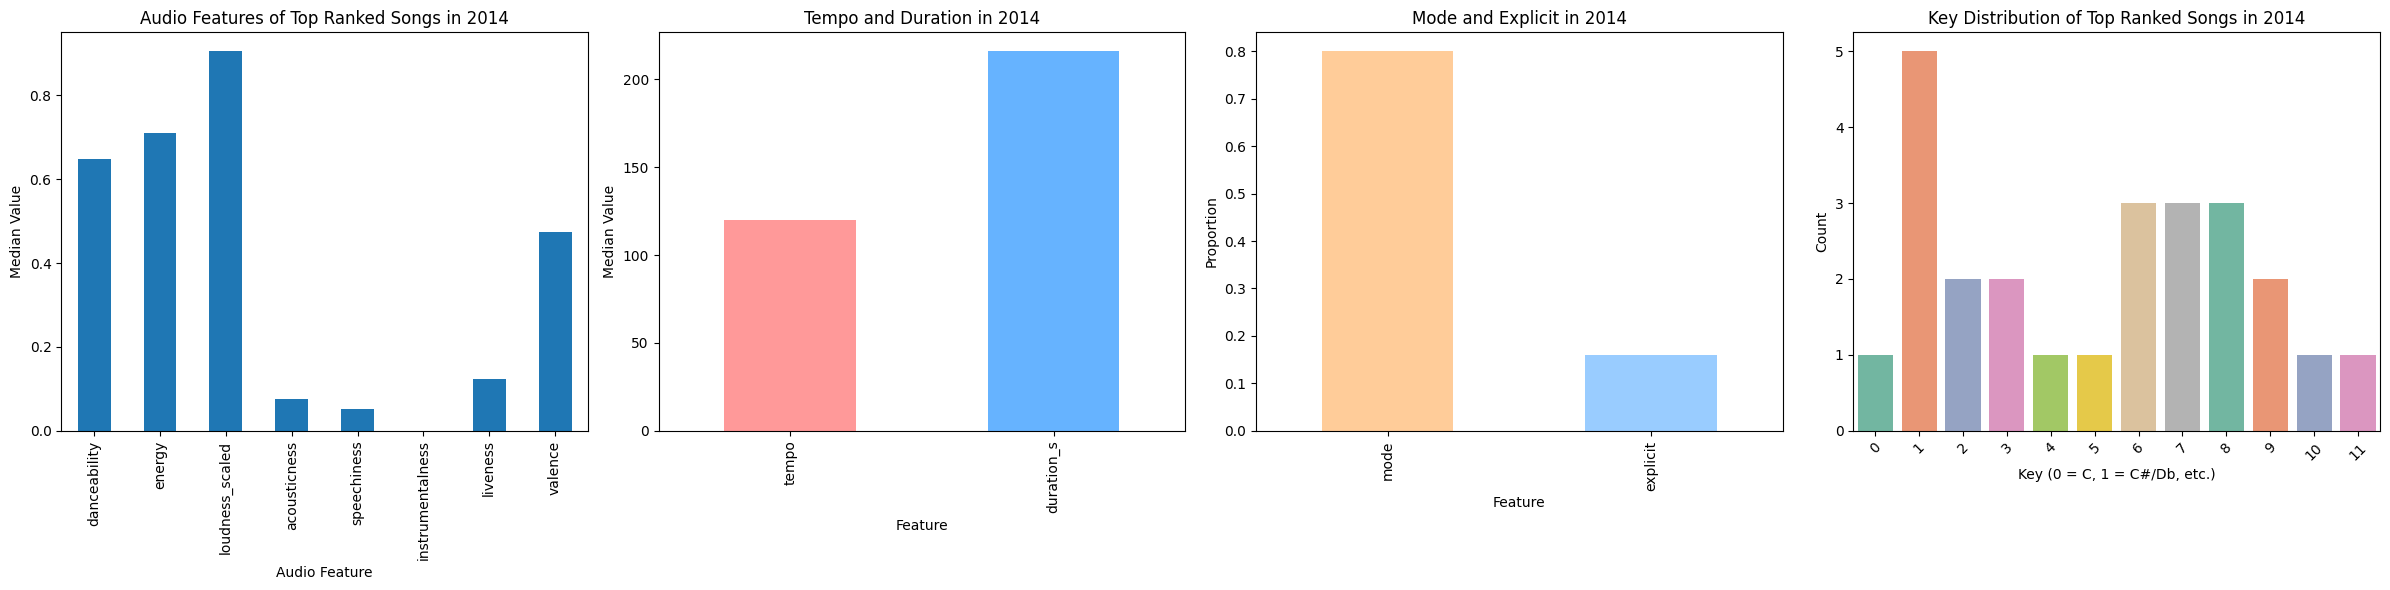

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




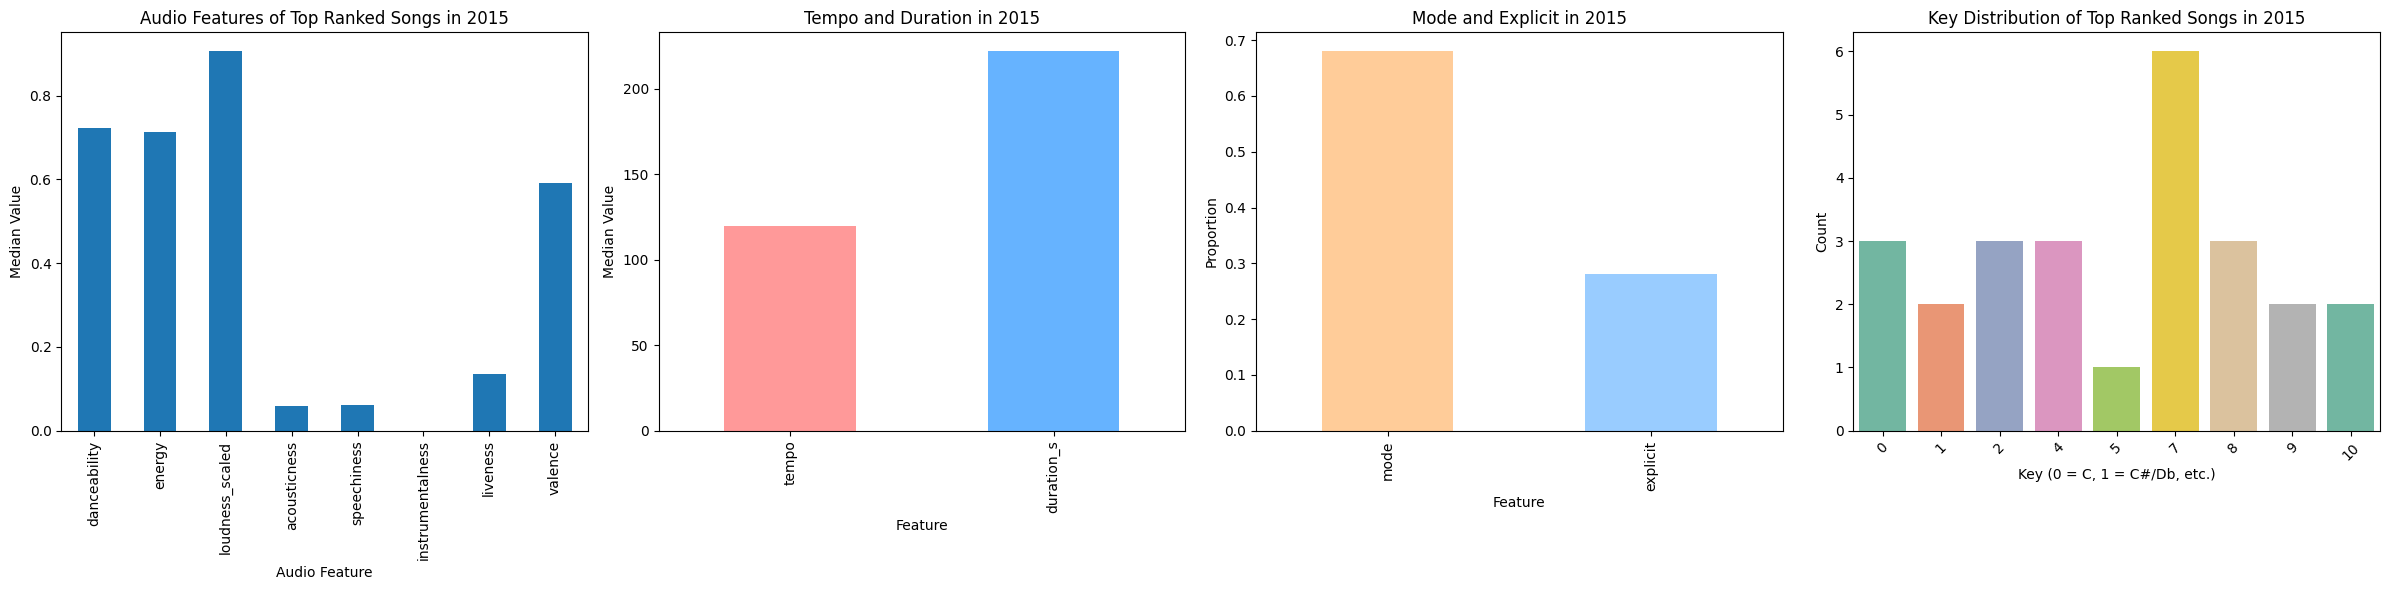

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




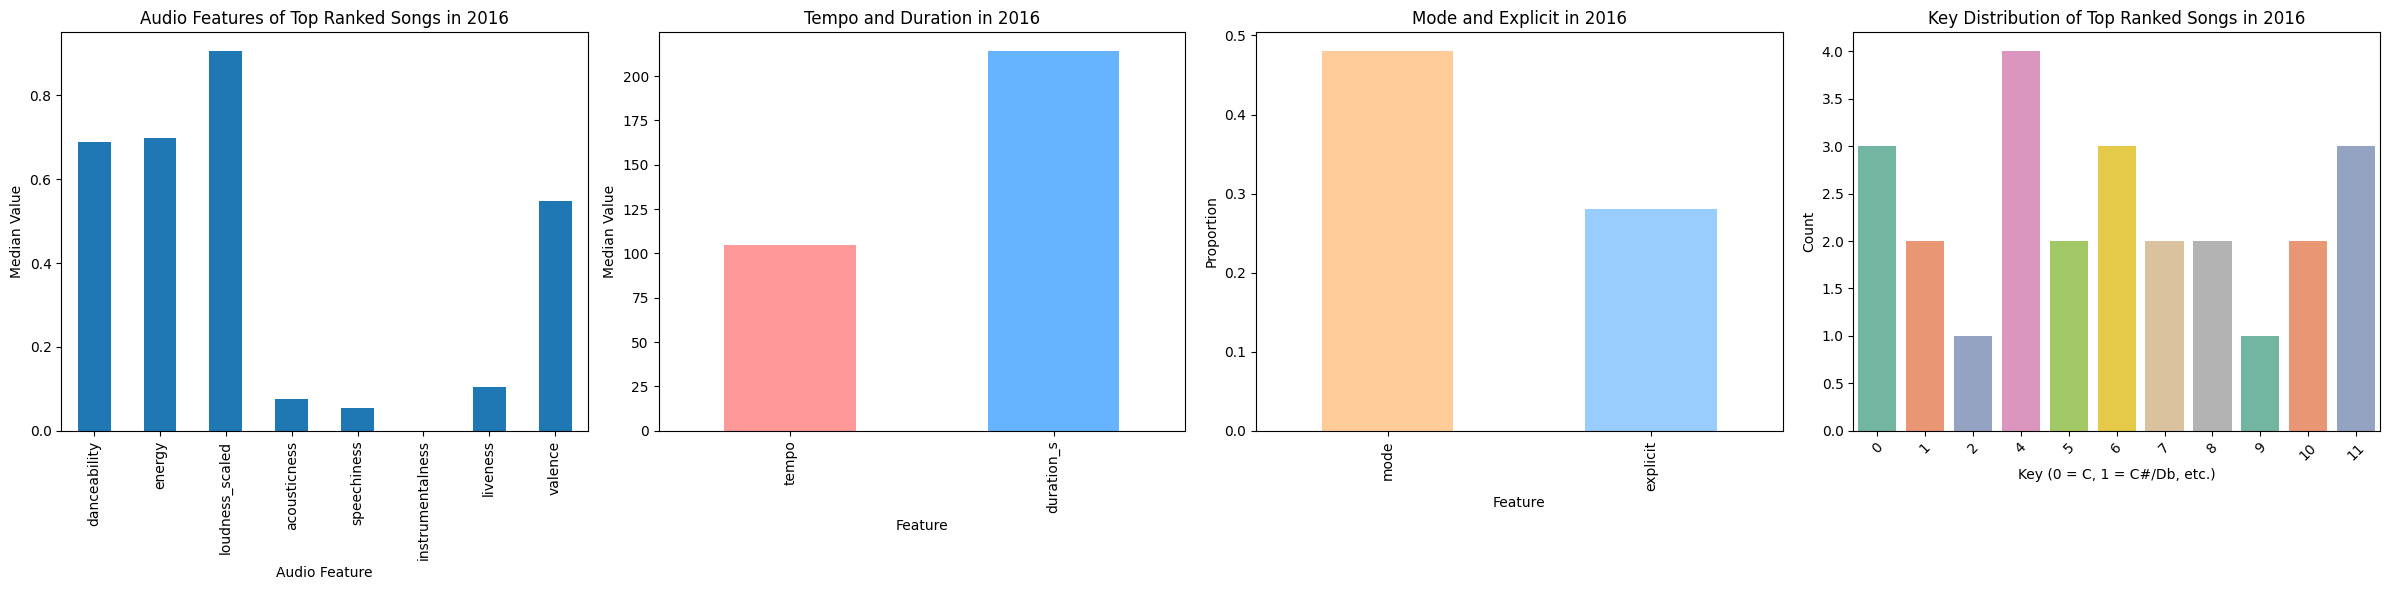

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




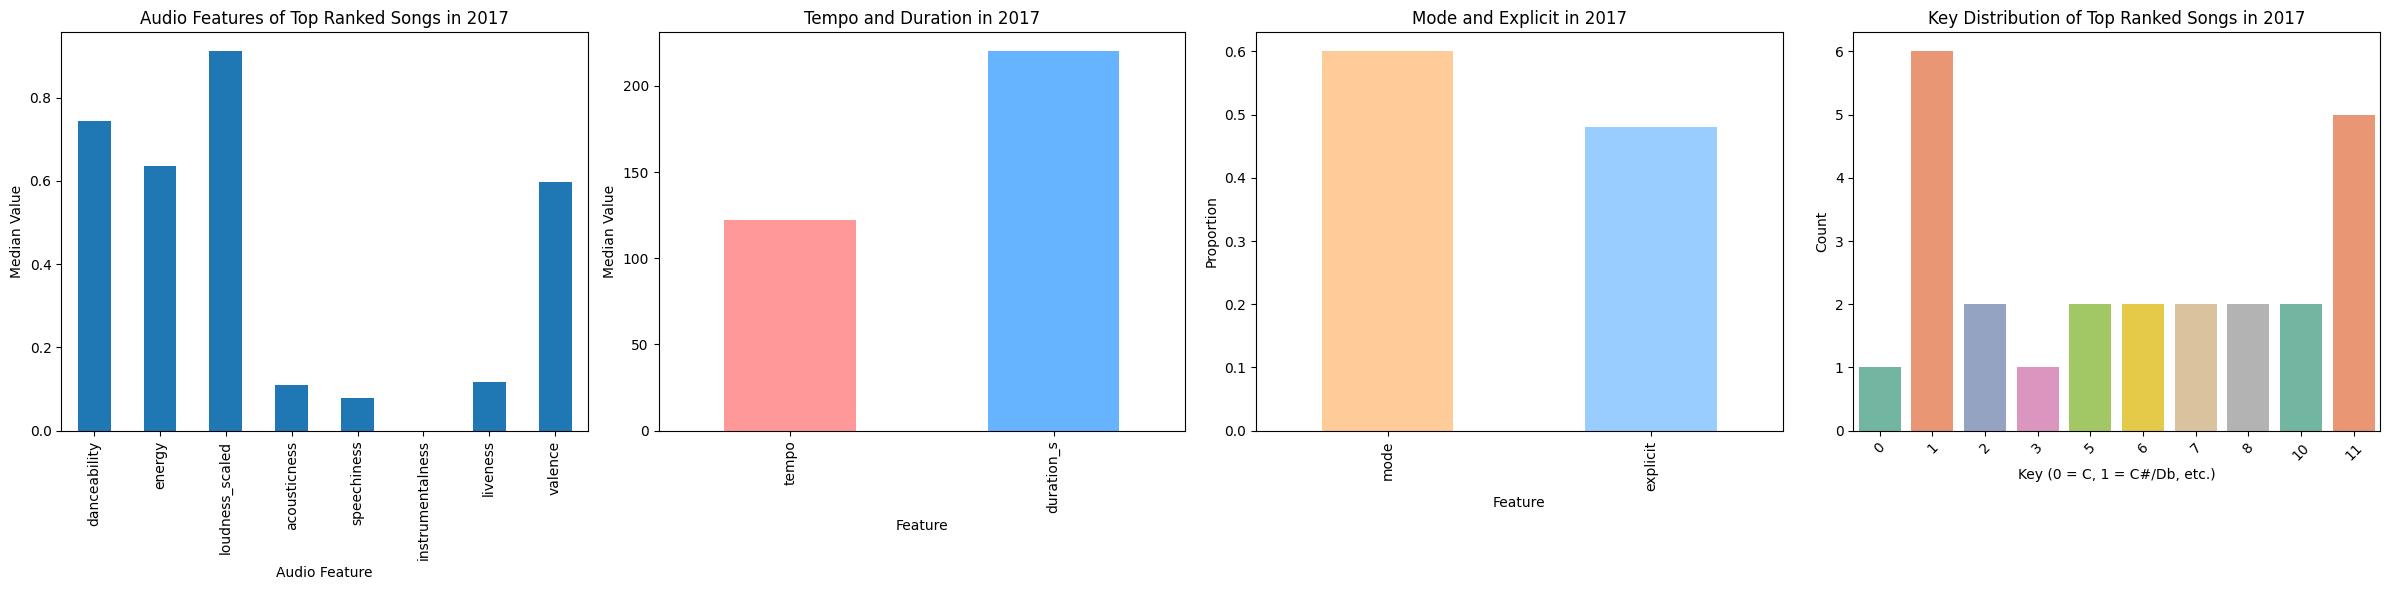

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




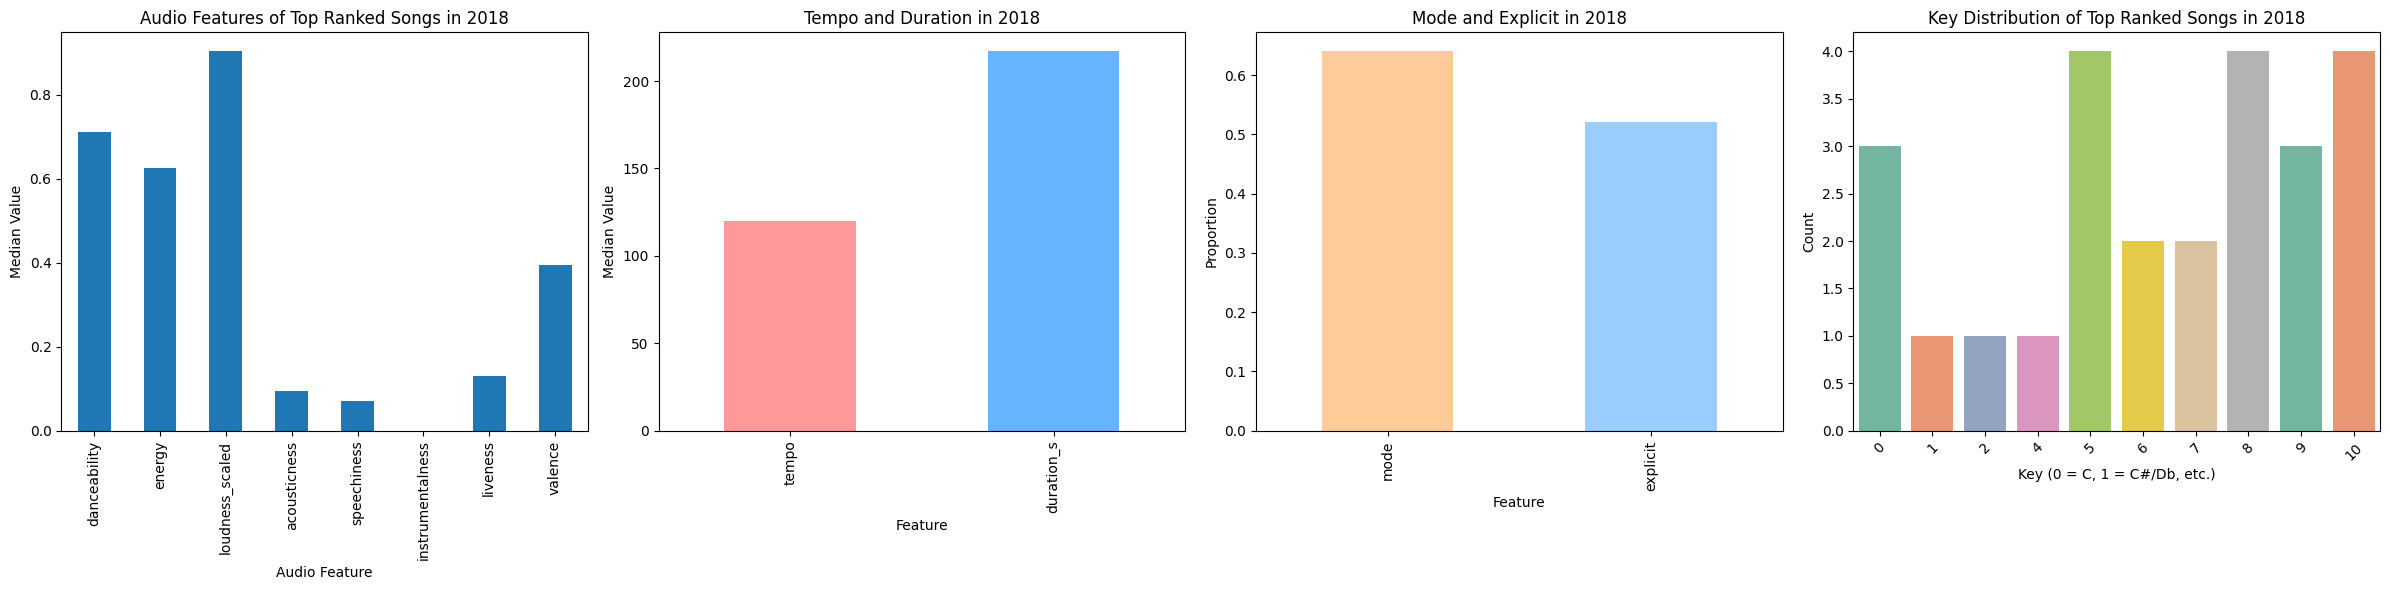

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




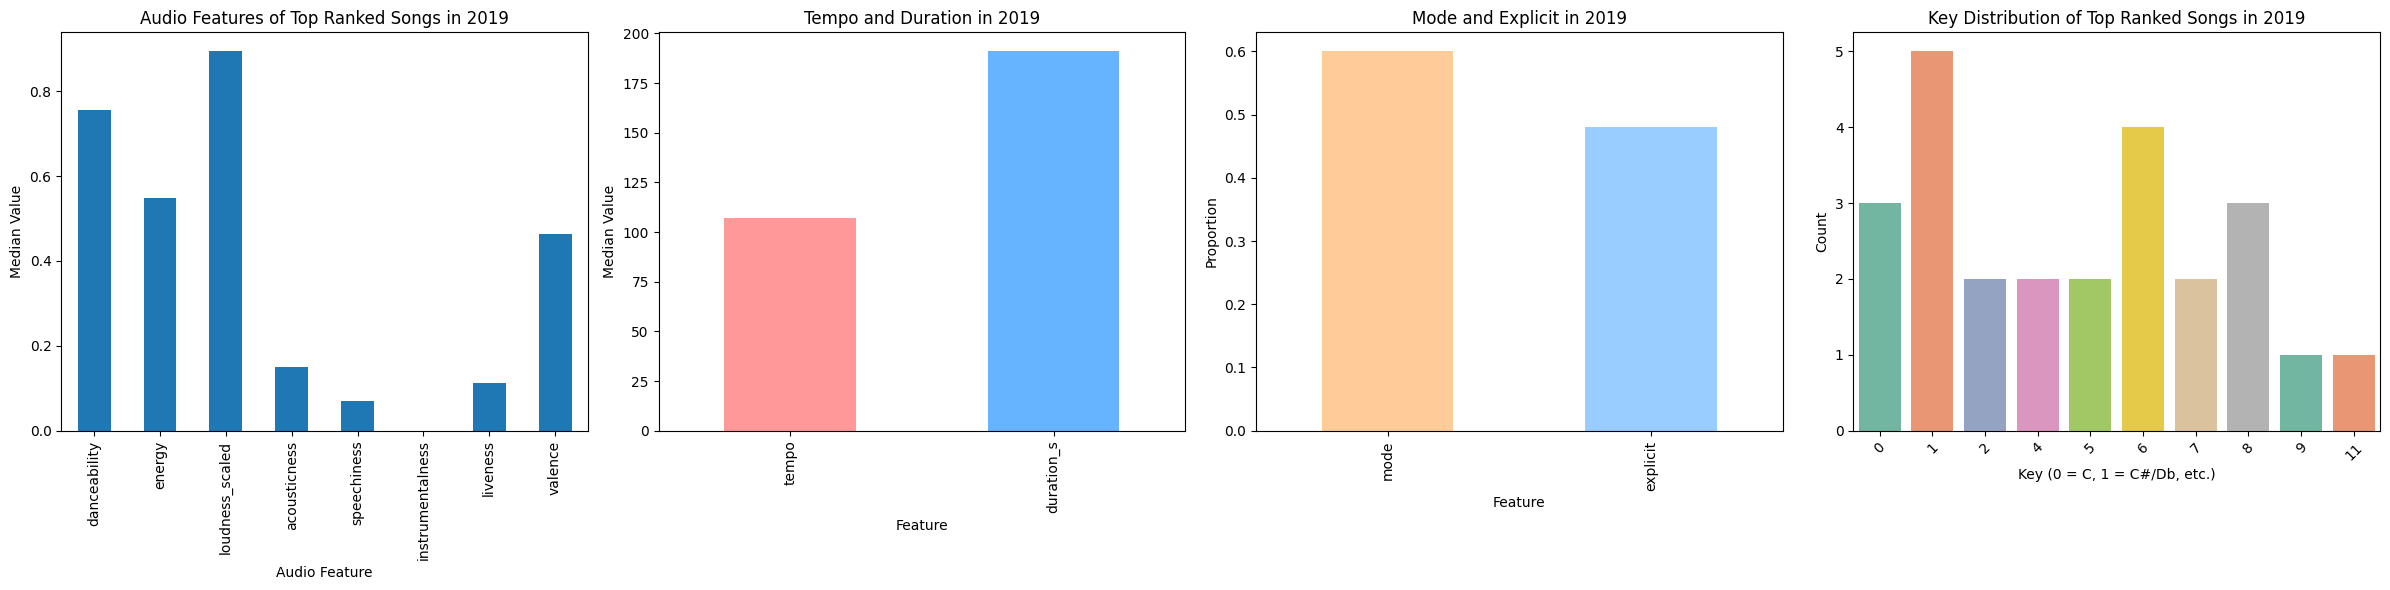

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




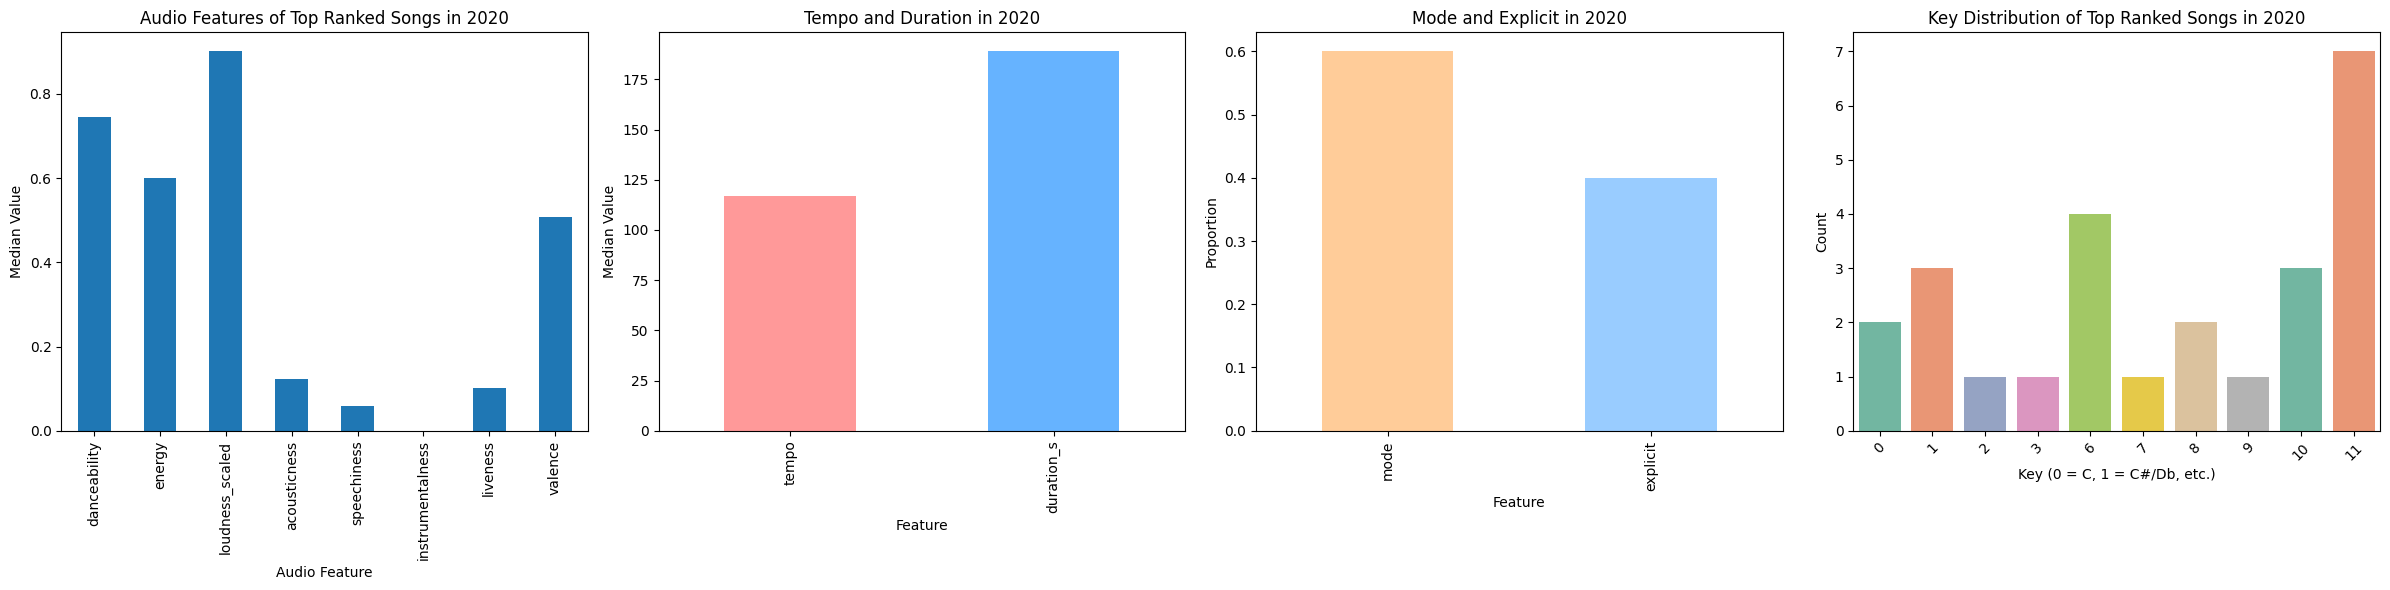

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




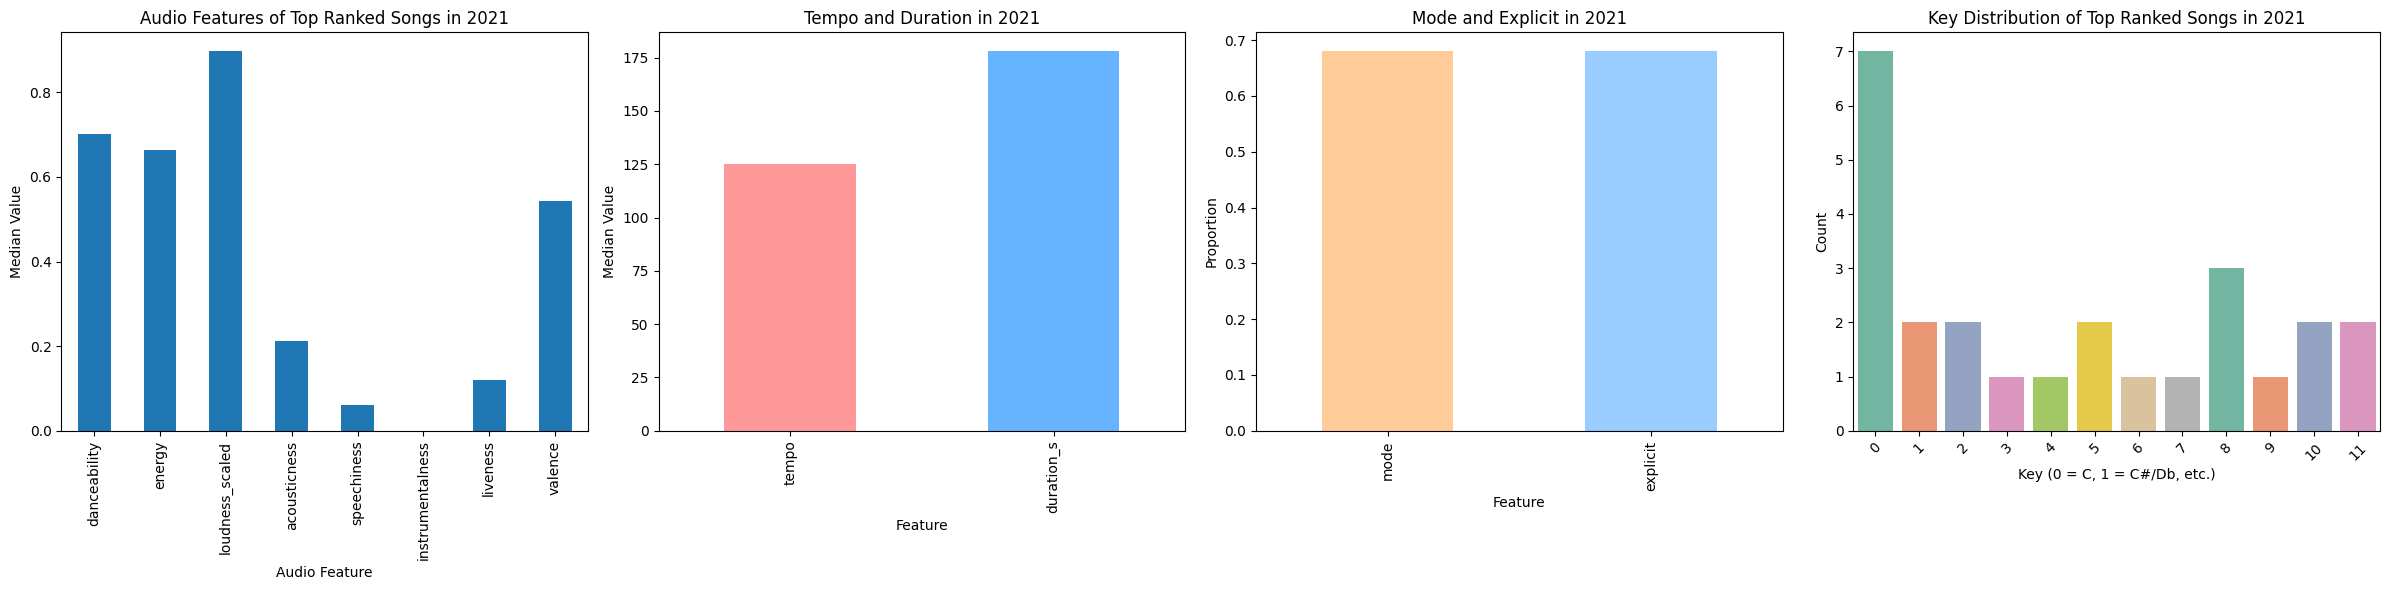

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




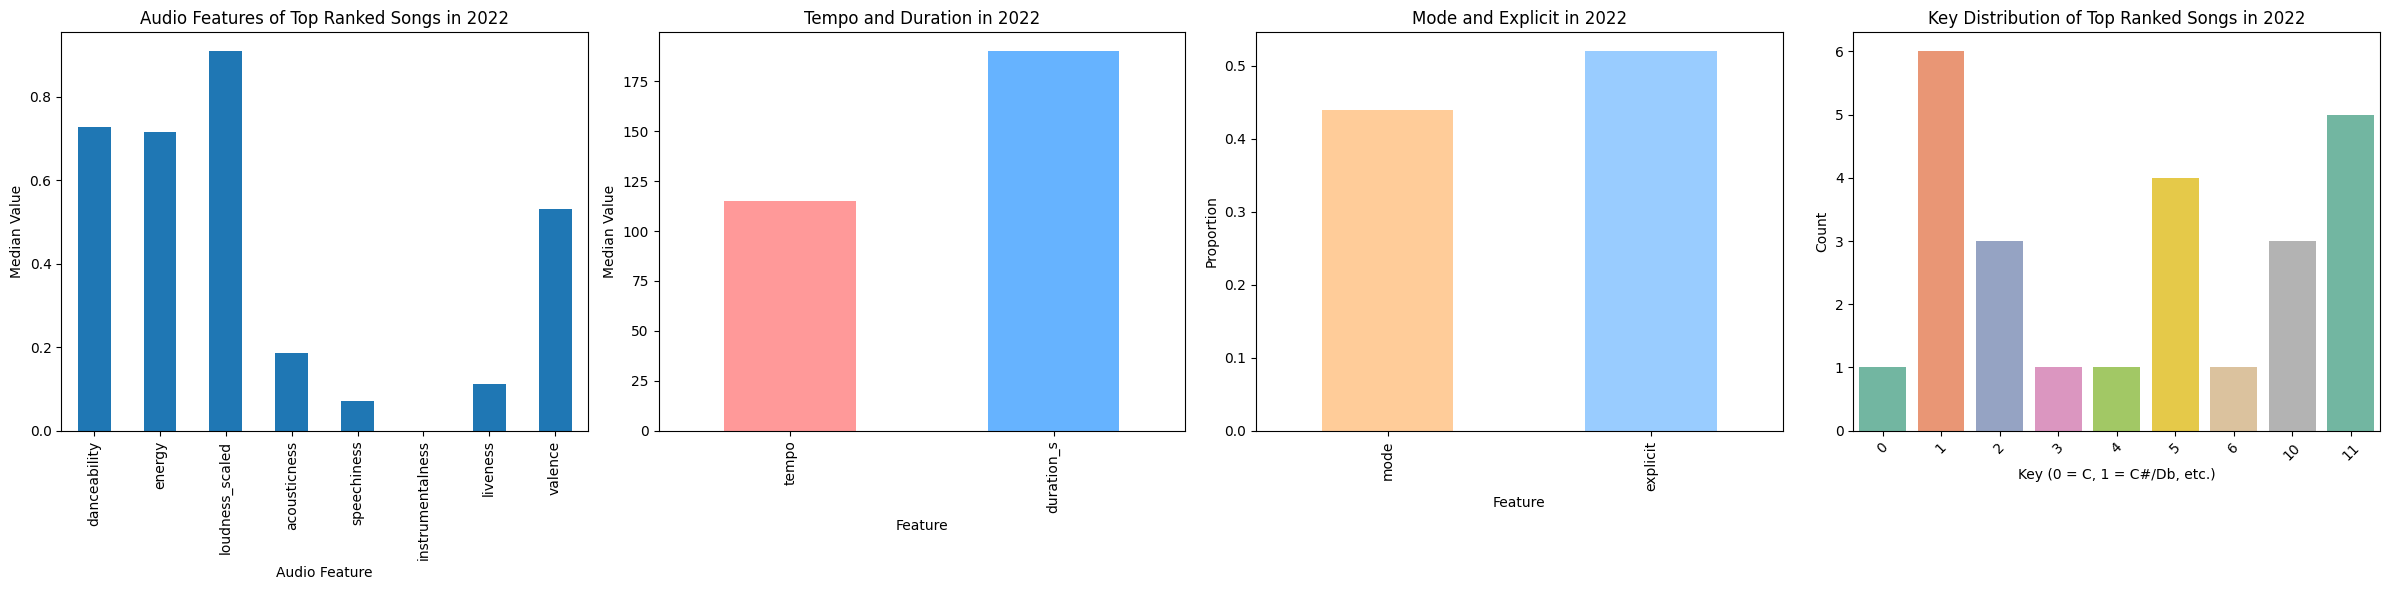

<ipython-input-47-adbe8696e79b>:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




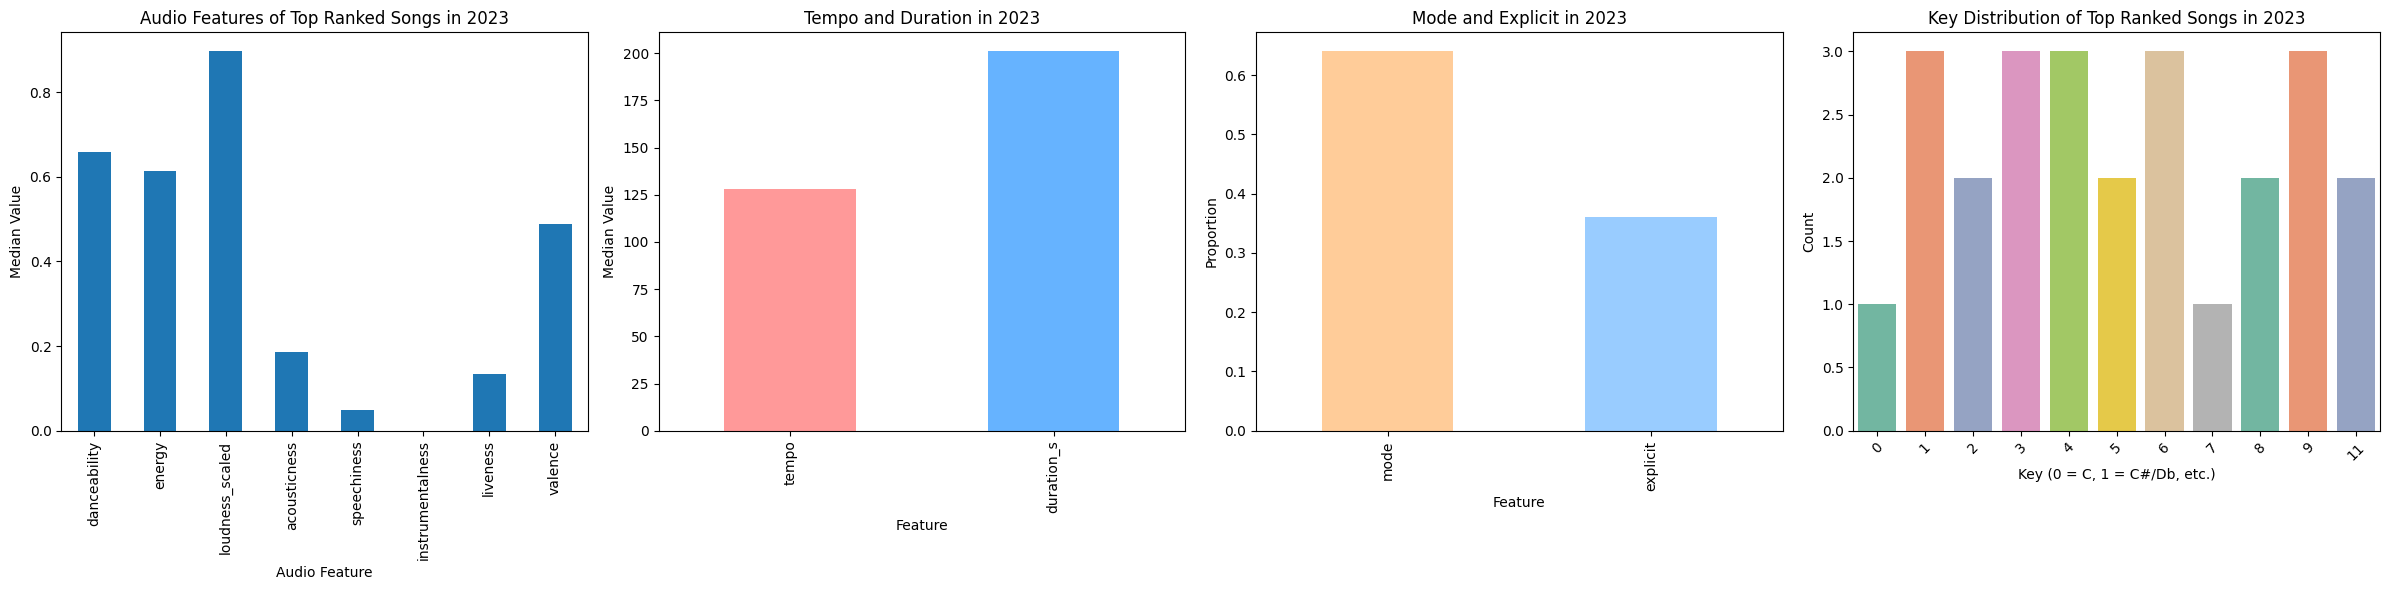

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot separately
main_audio_features = ['danceability', 'energy', 'loudness_scaled', 'acousticness', 'speechiness',
                       'instrumentalness', 'liveness', 'valence']
tempo_duration_features = ['tempo', 'duration_s']
binary_features = ['mode', 'explicit']

# Loop through each year and calculate the median of audio features for the top 10% ranked songs
for year in df['year'].unique():
    # Filter the songs for the specific year
    year_data = df[df['year'] == year]

    # Filter the top 10% ranked songs in that year
    top_ranked_songs = year_data[year_data['rank'] <= year_data['rank'].quantile(0.25)]

    # Calculate the median of the main audio features for the top-ranked songs
    top_ranked_audio_features_main = top_ranked_songs[main_audio_features].median()
    top_ranked_audio_features_tempo_duration = top_ranked_songs[tempo_duration_features].median()

    # Step 1: Create subplots for audio features, tempo/duration, binary features, and key distribution
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Plot 1: Main audio features of top-ranked songs (bar plot)
    top_ranked_audio_features_main.plot(kind='bar', ax=axes[0], title=f'Audio Features of Top Ranked Songs in {year}')
    axes[0].set_ylabel('Median Value')
    axes[0].set_xlabel('Audio Feature')

    # Plot 2: Tempo and Duration (separate scale)
    top_ranked_audio_features_tempo_duration.plot(kind='bar', ax=axes[1], color=['#ff9999', '#66b3ff'],
                                                  title=f'Tempo and Duration in {year}')
    axes[1].set_ylabel('Median Value')
    axes[1].set_xlabel('Feature')

    # Plot 3: Mode and Explicit (binary features)
    top_ranked_binary_features = top_ranked_songs[binary_features].mean()  # Binary features take the mean (proportion)
    top_ranked_binary_features.plot(kind='bar', ax=axes[2], color=['#ffcc99', '#99ccff'],
                                    title=f'Mode and Explicit in {year}')
    axes[2].set_ylabel('Proportion')
    axes[2].set_xlabel('Feature')

    # Plot 4: Key Distribution (categorical feature)
    sns.countplot(data=top_ranked_songs, x='key', ax=axes[3], palette='Set2')
    axes[3].set_title(f'Key Distribution of Top Ranked Songs in {year}')
    axes[3].set_xlabel('Key (0 = C, 1 = C#/Db, etc.)')
    axes[3].set_ylabel('Count')
    axes[3].tick_params(axis='x', rotation=45)

    # Step 4: Adjust layout and show plot
    plt.tight_layout()
    plt.show()


<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




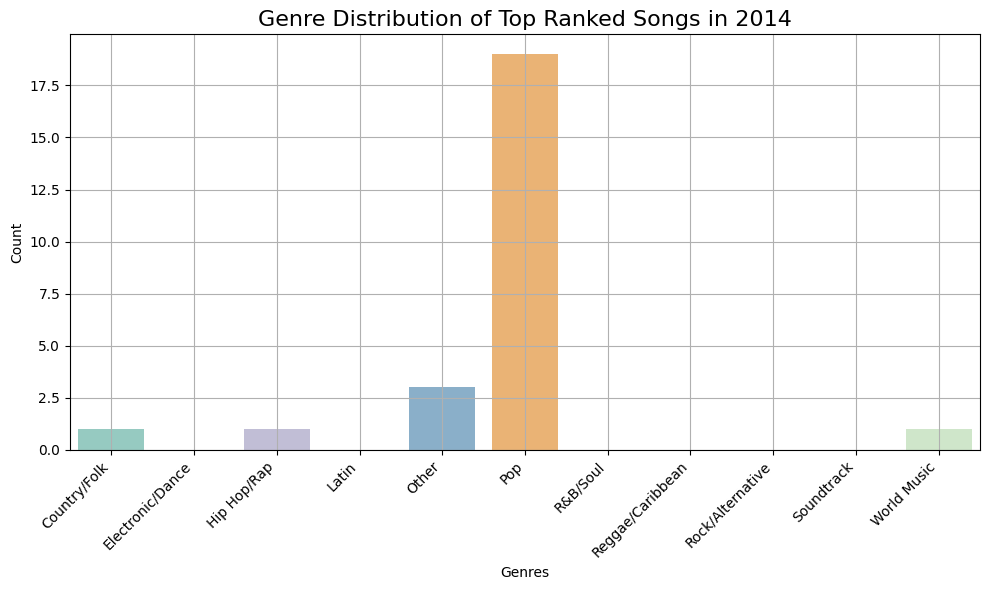

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




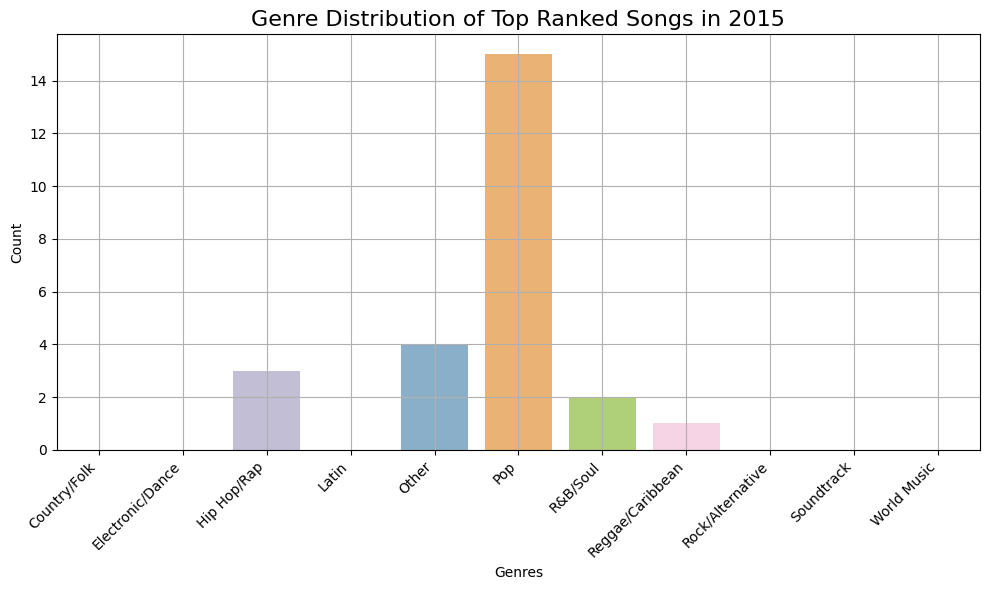

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




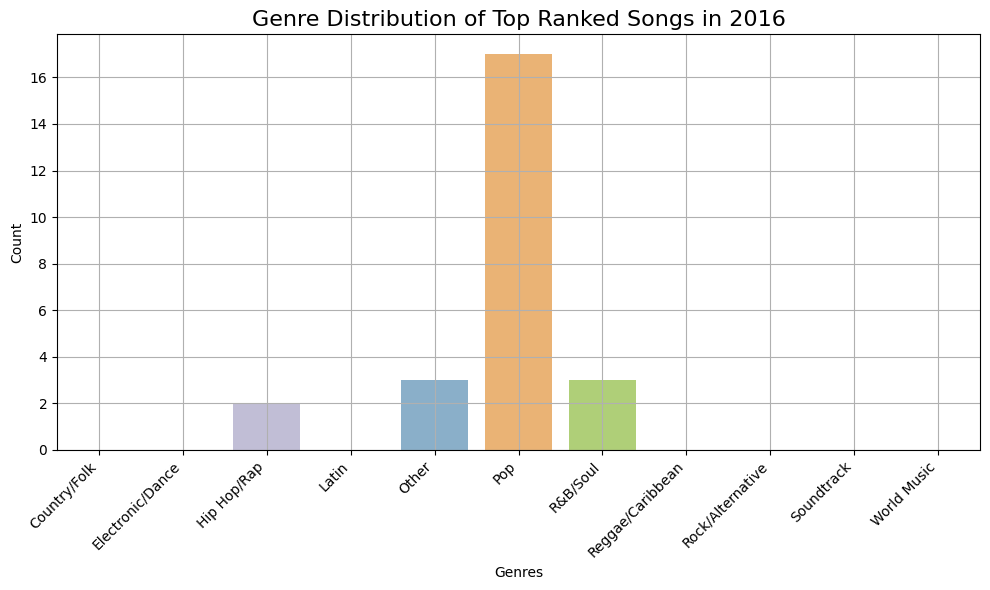

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




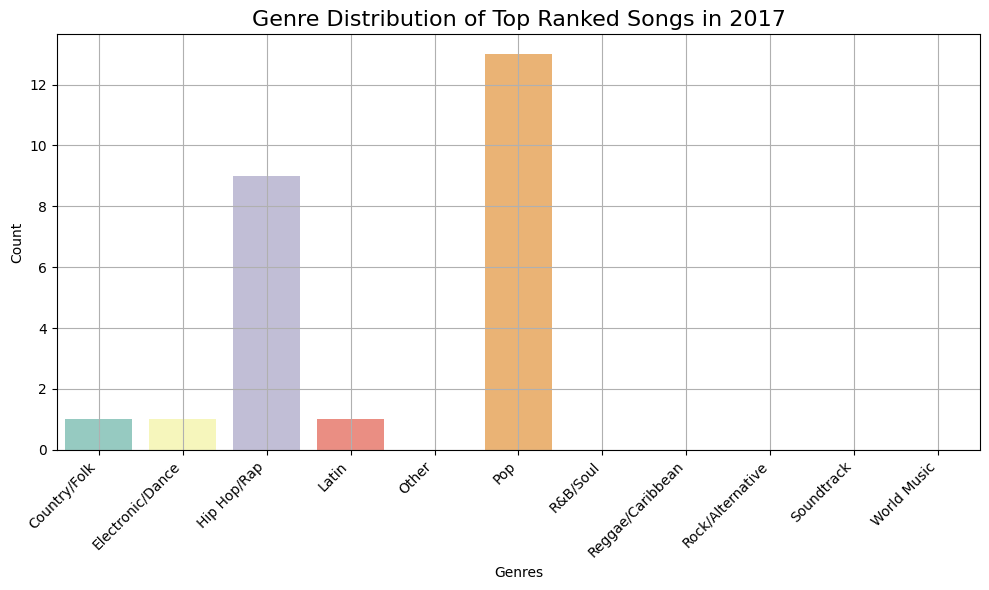

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




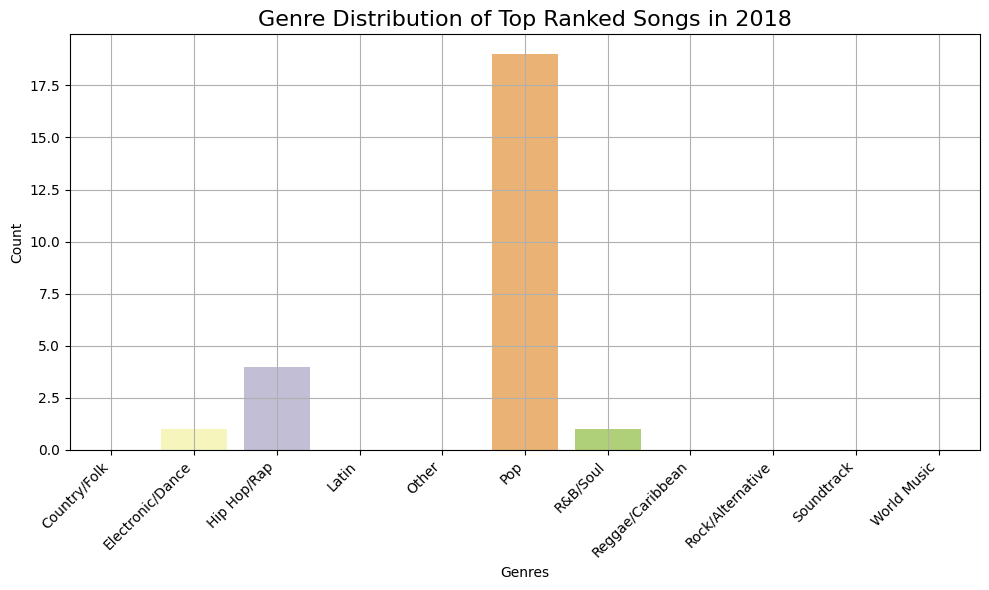

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




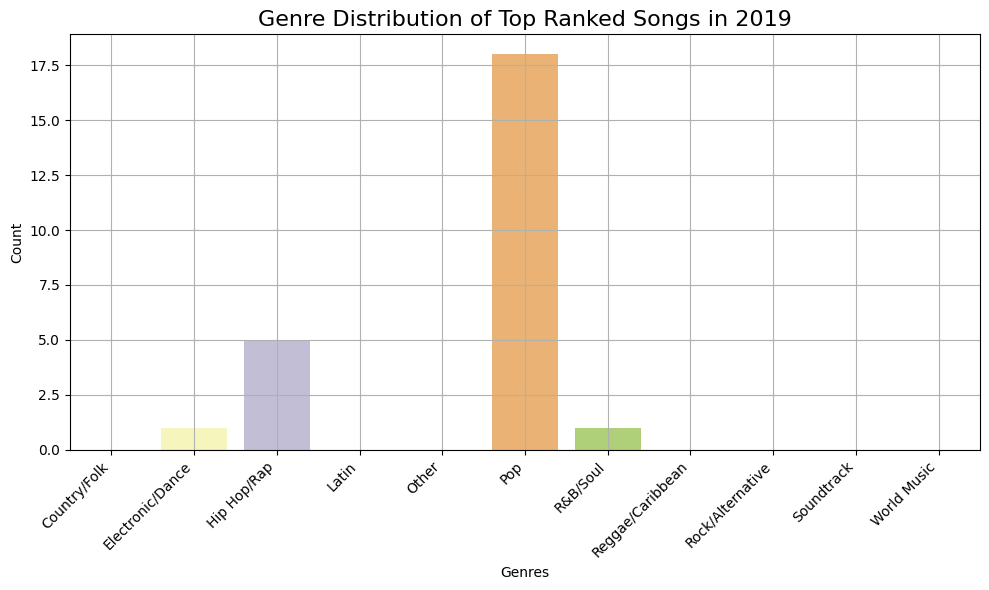

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




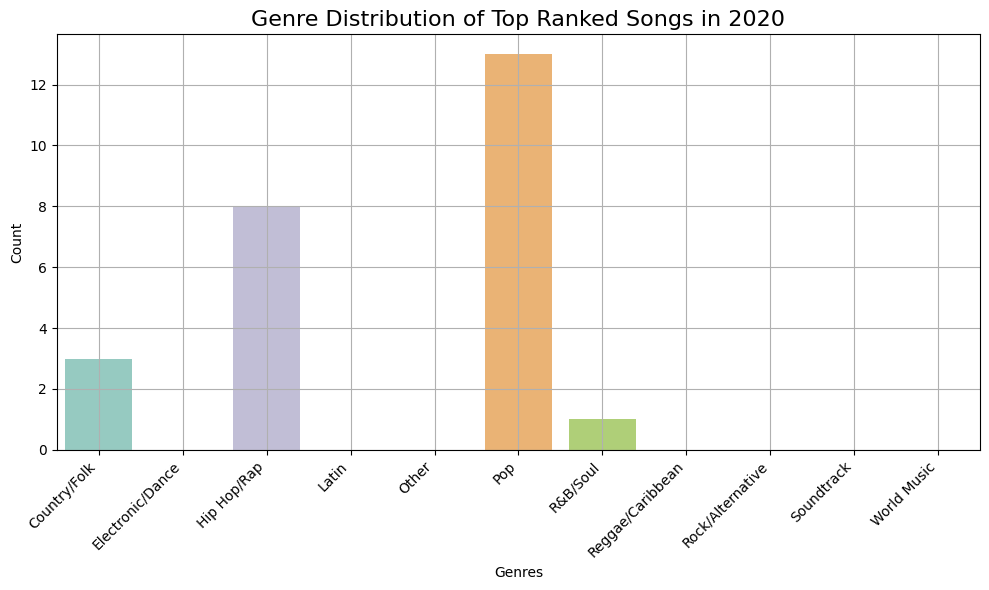

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




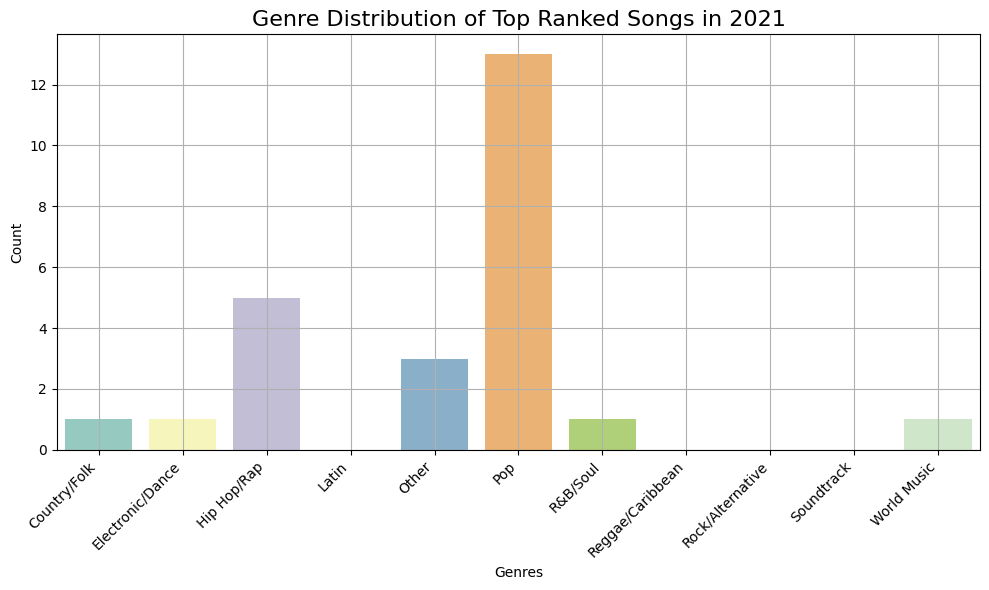

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




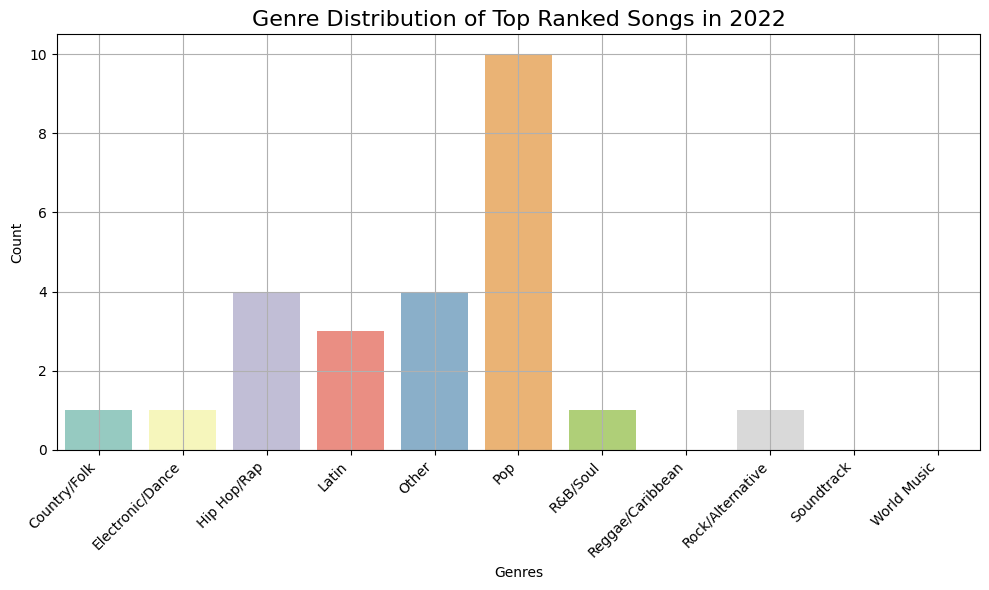

<ipython-input-48-a5d45f96c2a4>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




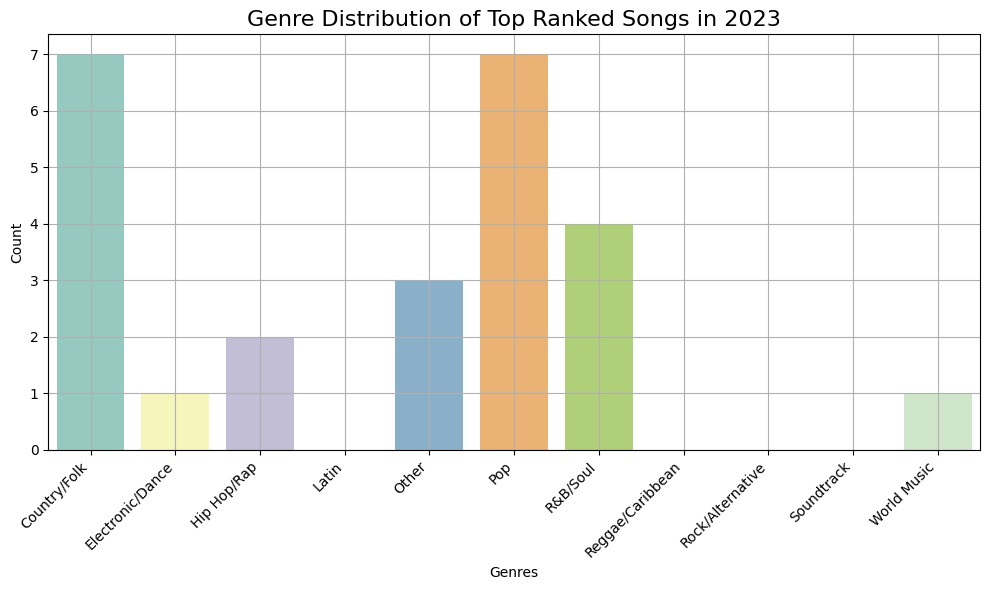

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each year and plot the genre distribution for the top 10% ranked songs
for year in df['year'].unique():
    # Filter the songs for the specific year
    year_data = df[df['year'] == year]

    # Filter the top 10% ranked songs in that year
    top_ranked_songs = year_data[year_data['rank'] <= year_data['rank'].quantile(0.25)]

    # Step 1: Create a figure for the genre distribution
    plt.figure(figsize=(10, 6))

    # Step 2: Create a count plot of genres for the top-ranked songs
    sns.countplot(data=top_ranked_songs, x='norm_genres', palette='Set3')

    # Step 3: Customize the plot with title and labels
    plt.title(f'Genre Distribution of Top Ranked Songs in {year}', fontsize=16)
    plt.xlabel('Genres')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate genre labels for better readability
    plt.grid(True)

    # Step 4: Show the plot
    plt.tight_layout()
    plt.show()
